# Описание проекта

**Задача исследования**:  
Мэтчинг: разработать алгоритм, который для всех товаров из выборки предложит несколько вариантов наиболее похожих товаров;


**Данные для исследования**:
- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72;

- `train.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов);

- `validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv;

- `validation_answer.csv `- правильные ответы к предыдущему файлу.

**Метрика**:
oценить качество алгоритма необходимо по метрике `accuracy@5`.


---
## Загрузка и чтение данных

### Подготовка к чтению данных

In [97]:
!apt -q install libomp-dev
!pip -q install faiss-gpu phik

Reading package lists...
Building dependency tree...
Reading state information...
libomp-dev is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [98]:
#  импортируем необходимые библиотеки.
import faiss
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import phik
import requests
import seaborn as sns
import time
import warnings
import zipfile

from phik.report import plot_correlation_matrix
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from urllib.parse import urlencode
from warnings import simplefilter


#зададим настройки
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:,.3f}'.format
sns.set_theme(style="darkgrid", palette="icefire")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore")

### Чтение данных

Загрузим имеющиеся для исследования данные:

In [99]:
def downloader(size: str='small'):
    if size not in ['small', 'large']:
        raise Exception('Unknown Argument')
    elif size == 'small':
        public_key = 'https://disk.yandex.ru/d/YQElc_cNQQLSOw'
    else:
        public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    with open('/content/data.zip', 'wb') as f:
        f.write(download_response.content)

    zip_path = ('/content/data.zip')

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()


# функция для вывода методов info() и msno.bar()
def info (df):
    display(df.info())
    msno.bar(df)

In [100]:
#Загрузим уменьшенный датасет
%%time
downloader('small')

CPU times: user 3.67 s, sys: 1.15 s, total: 4.81 s
Wall time: 20.1 s


- **Датафрейм `*base*`**

Считаем анонимизированный набор товаров и сохраним в переменную `product_base`:

In [101]:
%%time
product_base = pd.read_csv("base.csv", index_col=0)

#выведем 5 строк полученного датафрейма
product_base.head()

CPU times: user 6.21 s, sys: 390 ms, total: 6.6 s
Wall time: 7.93 s


0      1       2        3       4       5        6  \
Id                                                                       
4207931-base  -43.946 15.364  17.516 -132.311 157.064  -4.069 -340.631   
2710972-base  -73.005  4.923 -19.751 -136.529  99.907 -70.709 -567.402   
1371460-base  -85.566 -0.494 -48.375 -157.985  96.810 -81.710  -22.298   
3438601-base -105.564 15.394 -46.224 -158.115  79.514 -48.944  -93.713   
422798-base   -74.639 11.315 -40.204 -161.764  50.507 -80.776 -640.923   

                    7       8       9       10      11      12      13  \
Id                                                                       
4207931-base  -57.550 128.398  45.091 -126.844   4.495 -99.842  44.927   
2710972-base -128.890 109.915 201.472 -186.226  29.896 -99.771   0.126   
1371460-base   79.769 124.357 105.715 -149.808 -54.502 -21.038 -24.888   
3438601-base   38.581 123.398 110.324 -161.188 -68.520  -0.607  38.734   
422798-base    65.225 122.345 191.466 -156.984 -76.650 -75.675  12.624   

                  14      15      16      17       18      19       20  \
Id                                                                       
4207931-base 177.522 -12.292  38.470 105.358 -142.460 -80.163 -110.369   
2710972-base 136.190 -35.225 -30.321 -43.149 -162.852 -79.715  -75.785   
1371460-base 128.389 -58.558  34.863  19.784 -130.918 -79.032 -166.635   
3438601-base 120.743 -14.109  28.868 -29.859  -94.304 -79.340 -138.984   
422798-base  145.338 -35.774  11.599 -11.461 -201.354 -77.779 -120.968   

                    21       22     23     24      25       26     27  \
Id                                                                      
4207931-base 1,047.517  -69.595 66.314 84.874 813.770  -81.039 16.163   
2710972-base 1,507.231  -69.655 43.641 -4.780 813.770   43.977 11.925   
1371460-base 1,507.231   -8.496 61.205 25.895 813.770 -140.769 20.873   
3438601-base 1,507.231 -131.885 70.031 32.737 813.770  -62.371 13.763   
422798-base    548.737   19.852 17.943 27.063 813.770  -85.484 21.236   

                   28      29      30       31      32         33      34  \
Id                                                                          
4207931-base  -98.245 159.534  27.555 -209.184  62.060   -529.295 114.598   
2710972-base  -50.229 166.008 -59.505 -115.333  72.183   -735.671  96.322   
1371460-base -123.958 126.348  11.714 -125.025 152.686 -1,018.470 -22.445   
3438601-base  -31.872 139.553   9.836 -150.221  80.140   -537.184   3.092   
422798-base   -95.071 132.611  13.526 -160.477 104.719   -304.174 -15.385   

                  35      36       37       38      39      40     41  \
Id                                                                      
4207931-base  90.470 -20.257 -164.768 -133.314 -41.253 -10.251  8.289   
2710972-base  85.796 -22.030 -147.545 -108.383 -45.085 -15.004 -1.533   
1371460-base  73.898   9.191 -156.519  -92.186 -34.927 -13.277 16.026   
3438601-base 129.699 -63.429 -169.027 -119.770 -28.638  -8.315  2.752   
422798-base   91.419 -36.475 -157.440 -102.832 -56.783 -19.969 -0.598   

                   42      43      44     45       46       47     48      49  \
Id                                                                              
4207931-base -131.313  75.704 -16.483 40.771 -146.097 -143.408 49.808  63.434   
2710972-base  -46.457 197.579 -56.200 60.299 -102.653 -108.968 58.512  -9.678   
1371460-base  -33.854 119.605 -52.525 71.205 -178.703  -88.278 30.501  16.652   
3438601-base -160.294  85.087 -18.252 90.374    1.480 -121.983 65.853   8.355   
422798-base  -222.229  33.442 -56.092 71.276   -8.714  -86.099  8.489 -14.959   

                  50      51     52       53     54     55       56      57  \
Id                                                                            
4207931-base -30.250  20.470 78.080 -128.915 92.328 63.886 -141.175 142.903   
2710972-base -85.448 -68.686 71.590 -232.426 91.707 63.291 -137.336 -47.125   
1371460-base -8

<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       291813 non-null  float64
 1   1       291813 non-null  float64
 2   2       291813 non-null  float64
 3   3       291813 non-null  float64
 4   4       291813 non-null  float64
 5   5       291813 non-null  float64
 6   6       291813 non-null  float64
 7   7       291813 non-null  float64
 8   8       291813 non-null  float64
 9   9       291813 non-null  float64
 10  10      291813 non-null  float64
 11  11      291813 non-null  float64
 12  12      291813 non-null  float64
 13  13      291813 non-null  float64
 14  14      291813 non-null  float64
 15  15      291813 non-null  float64
 16  16      291813 non-null  float64
 17  17      291813 non-null  float64
 18  18      291813 non-null  float64
 19  19      291813 non-null  float64
 20  20      291813 non-null  float64
 21 

None

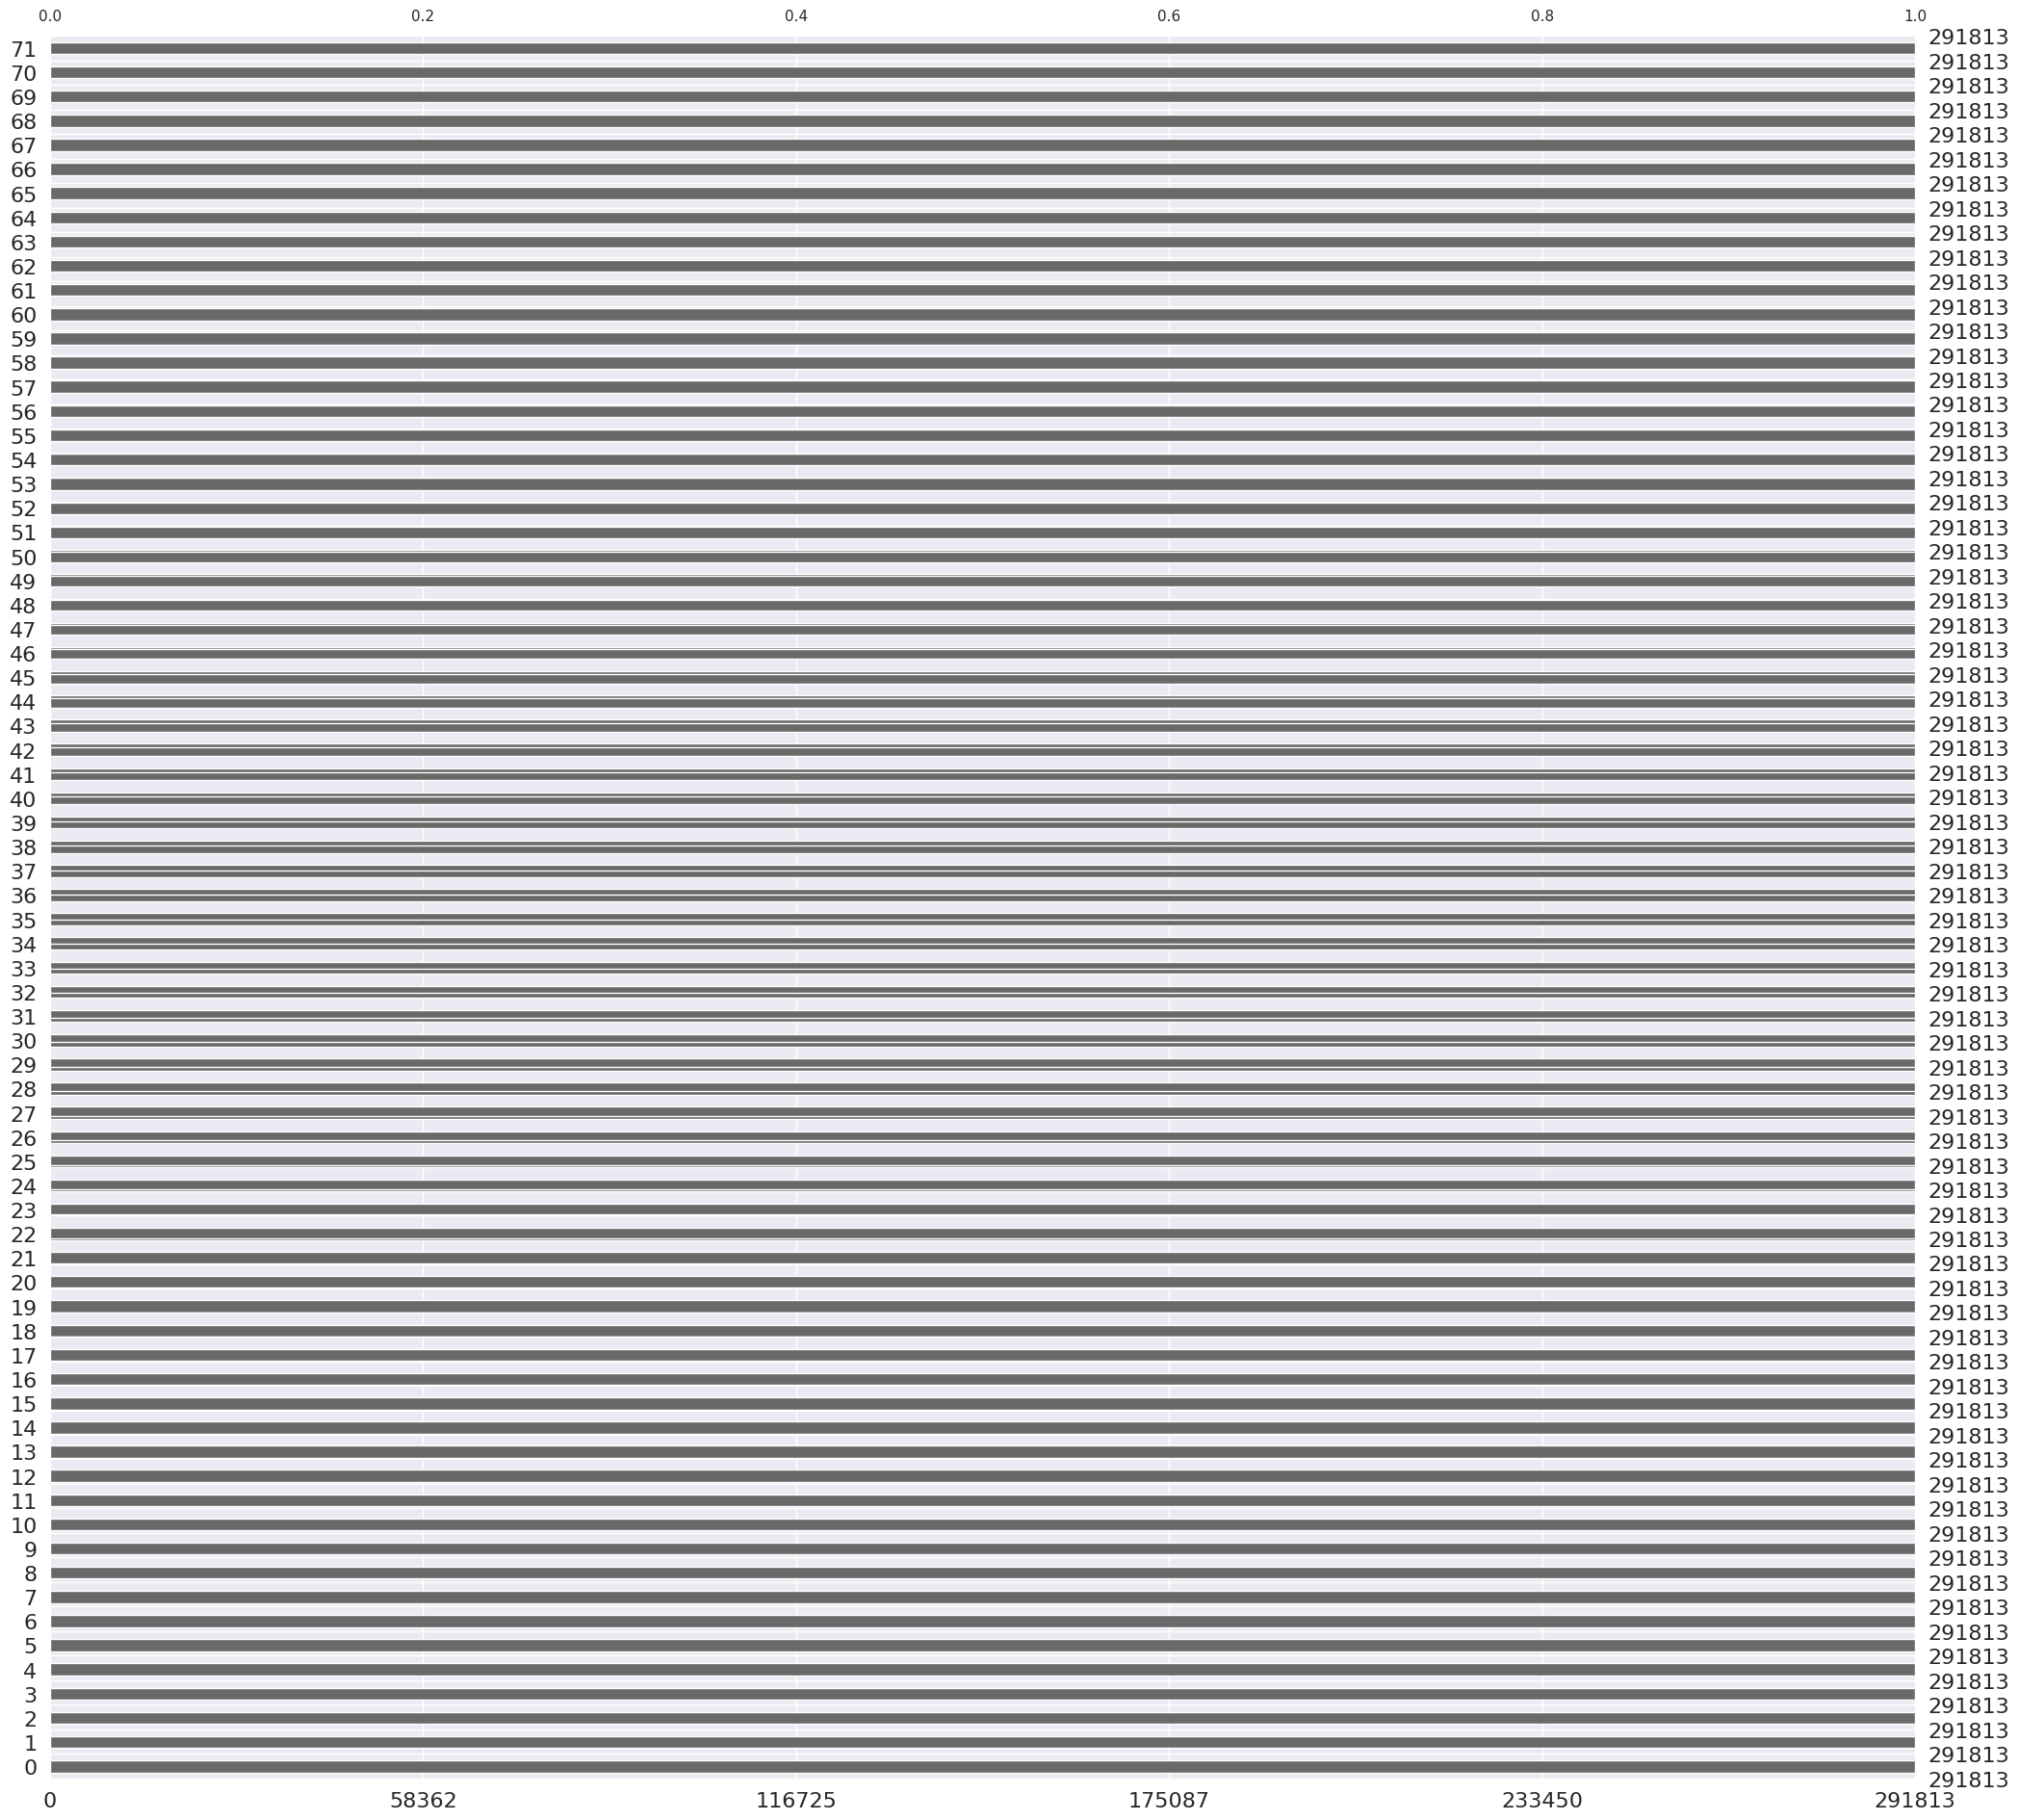

In [102]:
# ознакомимся с данными
info(product_base)

- **Датафрейм `*train*`**

Считаем  обучающий датасет  и сохраним в переменную `product_train`:

In [103]:
product_train = pd.read_csv("train.csv", index_col=0)
product_train.head()

0      1       2        3       4       5        6       7  \
Id                                                                              
109249-query -24.021  3.123 -80.948 -112.330 191.090 -66.903 -759.626 -75.284   
34137-query  -82.034  8.116  -8.793 -182.972  56.645 -52.598  -55.720 130.059   
136121-query -75.720 -0.223 -86.186 -162.064 114.320 -53.395 -117.261 -24.858   
105191-query -56.581  5.094 -46.943 -149.039 112.436 -76.821 -324.996 -32.833   
63983-query  -52.726  9.027 -92.830 -113.111 134.125 -42.423 -759.626   8.261   

                   8       9       10       11       12      13      14  \
Id                                                                        
109249-query 120.551 131.132 -149.211 -102.312   21.388  11.278 143.221   
34137-query  129.383  76.203 -137.799   33.302   -2.868 -34.319 189.065   
136121-query 124.808 112.190 -200.926  -38.865  -80.611  14.344 156.621   
105191-query 119.479 120.075  -61.347  -28.671 -102.790 -36.194 157.190   
63983-query  119.490 172.365 -186.641  -84.944  -92.340 -30.230 167.862   

                  15      16       17       18      19       20        21  \
Id                                                                          
109249-query -22.012  -3.618  -16.005 -133.382 -78.894  -65.691   407.774   
34137-query  -19.338 -14.208  -71.110 -157.748 -78.701  -91.742 1,054.206   
136121-query -22.498 -26.359 -109.035 -106.927 -79.747  -69.877 1,507.231   
105191-query -33.318   7.448  -47.231 -178.046 -78.787 -106.235 1,507.231   
63983-query  -22.636   0.015   -9.796 -213.102 -78.590  -98.728 1,250.424   

                  22      23      24      25       26     27       28      29  \
Id                                                                              
109249-query -11.661  67.008  24.975 813.770   40.051 17.933  -75.436 149.817   
34137-query  -41.846 102.129  72.559 813.770  -37.958 17.599 -159.975 140.025   
136121-query -20.058  34.335  23.592 813.770  -49.504 22.166  -85.740 134.836   
105191-query -63.414  38.099 -89.795 813.770 -107.432 10.053  -71.917 147.740   
63983-query  -43.892  86.288  -1.550 813.770 -110.357 24.056  -96.578 156.582   

                  30       31      32       33      34     35      36  \
Id                                                                      
109249-query -23.414 -178.096 133.786 -906.571 113.356 83.942 -16.593   
34137-query   -8.819 -147.055 113.820 -529.295  70.675 55.977   8.818   
136121-query -69.570 -139.887  67.377 -341.782  54.161 81.892  36.421   
105191-query -18.751 -143.796  67.207 -366.139 112.188 78.145 -41.085   
63983-query   45.124 -123.889 118.035 -607.947  52.311 76.748 -14.162   

                   37       38      39      40     41       42      43  \
Id                                                                       
109249-query -146.521 -120.238 -27.342  -8.846  1.028 -175.648 167.736   
34137-query  -134.148  -73.680 -57.567  -4.338 -3.271 -144.499 144.650   
136121-query -159.996 -131.916 -20.495 -13.977 -2.355 -216.229 238.836   
105191-query -132.757  -89.445 -19.267 -14.866  7.776 -104.302  74.623   
63983-query  -143.539 -124.886 -64.783 -17.707 15.447  -53.554 174.382   

                  44     45       46       47      48       49      50  \
Id                                                                       
109249-query -32.932 47.861 -196.248 -118.810  -4.763 -114.878  37.397   
34137-query  -37.903 58.914 -105.363 -125.668  19.367  -29.088 -35.021   
136121-query -56.612 43.367    7.192 -159.484 -19.338  -51.410  36.820   
105191-query -59.875 76.406  -77.797  -92.017  19.337  -37.923  37.271   
63983-query  -23.141 76.419  -73.358 -128.125 -34.571   -2.757  44.028   

                  51     52       53     54     55       56      57       58  \
Id                                                                             
109249-query -55.617 56.627 -108.433 87.373 76.513 -136.271   3.653 -164.575   
34137-query   26.628 55.718

In [104]:
product_train.index.nunique()

9756

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9999 non-null   float64
 1   1       9999 non-null   float64
 2   2       9999 non-null   float64
 3   3       9999 non-null   float64
 4   4       9999 non-null   float64
 5   5       9999 non-null   float64
 6   6       9999 non-null   float64
 7   7       9999 non-null   float64
 8   8       9999 non-null   float64
 9   9       9999 non-null   float64
 10  10      9999 non-null   float64
 11  11      9999 non-null   float64
 12  12      9999 non-null   float64
 13  13      9999 non-null   float64
 14  14      9999 non-null   float64
 15  15      9999 non-null   float64
 16  16      9999 non-null   float64
 17  17      9999 non-null   float64
 18  18      9999 non-null   float64
 19  19      9999 non-null   float64
 20  20      9999 non-null   float64
 21  21      9999 non-null   

None

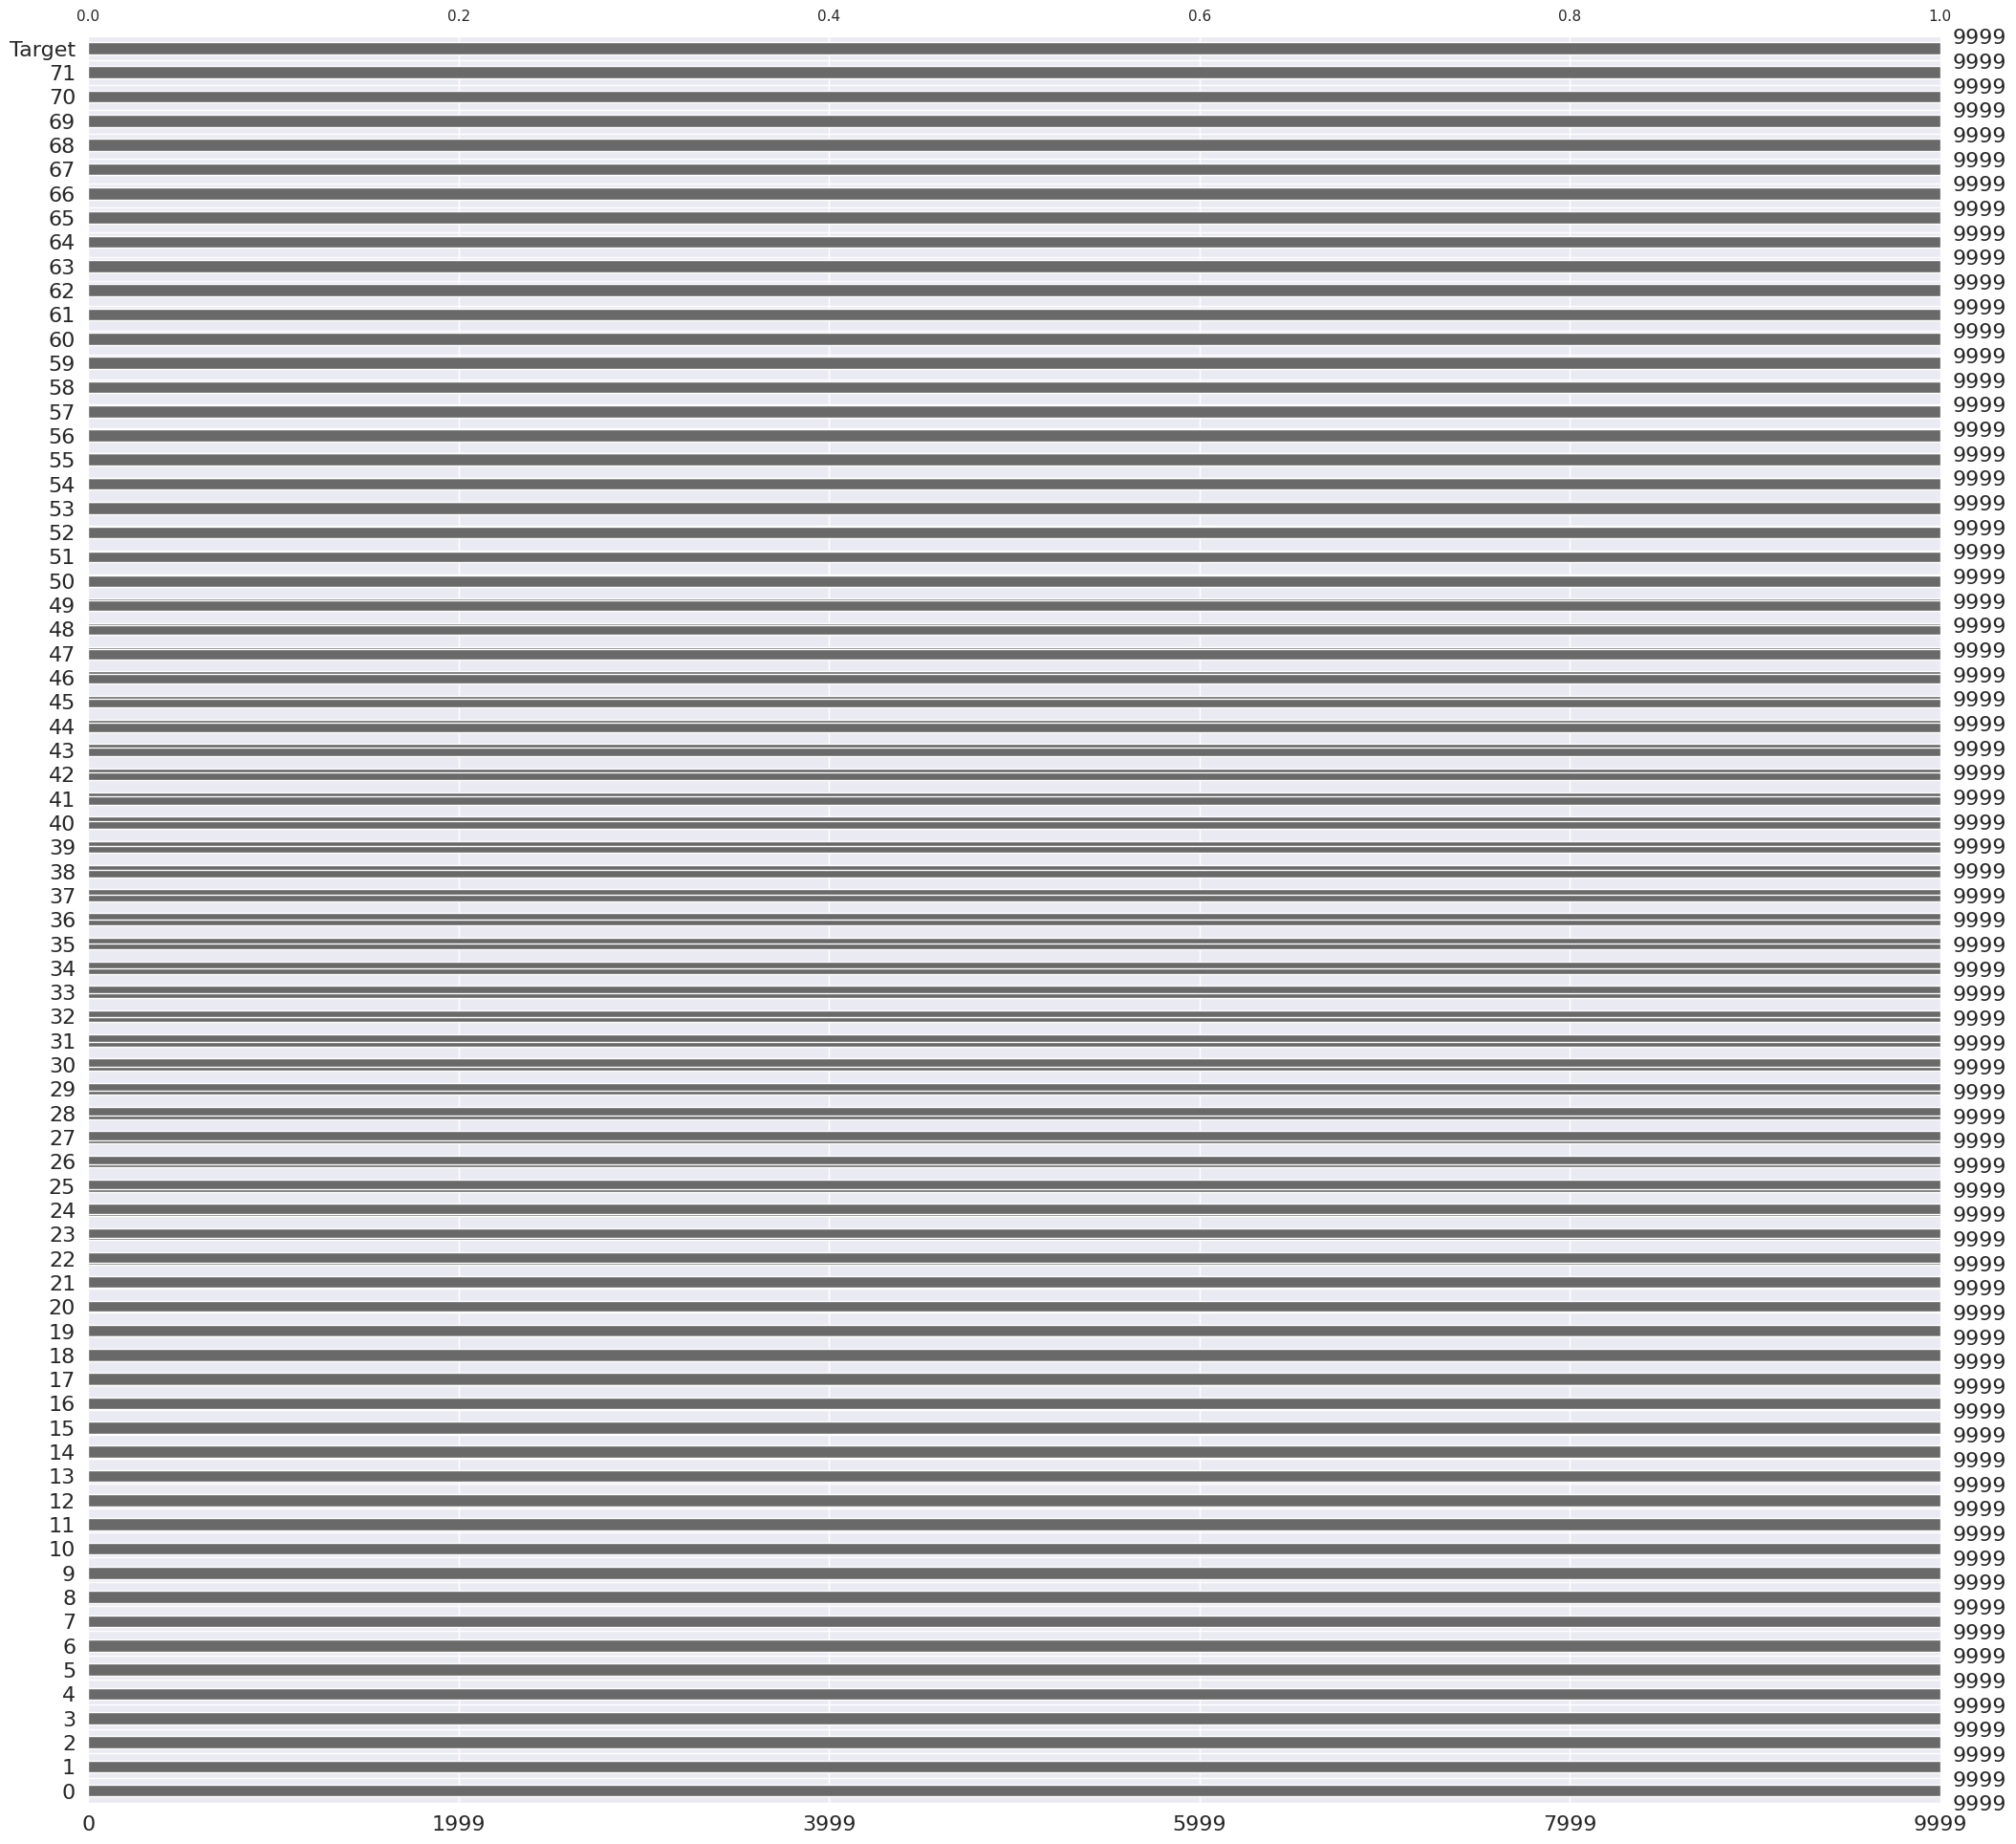

In [105]:
#ознакомимся с данными
info(product_train)

- **Датафрейм `*validation*` и `*validation_answer*`**

Считаем  валидационные датасеты  и сохраним в переменные `product_valid` и `product_valid_answer`:

In [106]:
product_valid = pd.read_csv("validation.csv", index_col=0)
product_valid_answer = pd.read_csv("validation_answer.csv", index_col=0)
display(product_valid.head())
product_valid_answer.head()

0      1       2        3       4        5        6  \
Id                                                                        
196680-query  -59.383  8.563 -28.203 -134.225  82.737 -150.572 -129.179   
134615-query -103.912  9.743 -15.210 -116.373 137.699  -85.530 -776.123   
82675-query  -117.923 -3.505 -64.299 -155.187 156.821  -34.082 -537.424   
162076-query  -90.881  4.889 -39.648 -131.750  62.362 -105.593 -347.132   
23069-query   -66.947 10.563 -73.782 -149.398   2.939  -51.289 -587.189   

                   7       8       9       10       11       12      13  \
Id                                                                        
196680-query  23.671 125.666 108.810 -129.484 -178.983 -109.600  -8.800   
134615-query  44.482 114.671  95.231 -166.036  -66.360  -36.001   3.264   
82675-query   54.079 121.974  59.321  -90.083    4.987  -52.515  52.530   
162076-query -83.352 133.913 201.146 -193.193  -31.962  -11.191 -28.481   
23069-query   -2.764 126.561 131.901 -131.936  -35.795 -155.980  -2.110   

                  14      15      16      17       18      19      20  \
Id                                                                      
196680-query 172.960 -20.794 -30.066 -14.890 -213.474 -81.443 -92.559   
134615-query  73.069 -29.385  22.246  62.498 -114.180 -80.017 -56.034   
82675-query  140.474  -4.861 -18.064 -36.537 -137.924 -79.661 -70.733   
162076-query 157.140 -39.514 -20.432  30.671 -131.632 -79.842 -74.223   
23069-query  137.724 -11.544 -12.958   2.028 -129.130 -79.461 -72.883   

                    21      22     23      24      25      26     27       28  \
Id                                                                              
196680-query 1,507.231  96.508 87.975  55.863 813.770   1.648 16.160  -77.401   
134615-query   914.812 -23.072 64.592  47.074 813.770   1.761 24.459 -177.638   
82675-query  1,507.231  -7.058 26.214  -2.779 813.770 -69.704 16.081  -90.433   
162076-query 1,507.231 -75.136 34.678 -14.997 401.380 -29.015 17.789  -87.425   
23069-query  1,507.231 -47.113  7.837  -8.623 813.770 -60.252 11.591  -82.795   

                  29      30       31      32       33     34     35      36  \
Id                                                                             
196680-query 166.087  -7.086 -114.406 116.564 -481.587 40.186 73.085 -37.582   
134615-query 157.880 -15.649 -174.117  37.698 -701.606 18.383 81.502  22.231   
82675-query  137.941  24.971 -138.866  92.287 -735.671 68.335 78.208  14.044   
162076-query 160.816 -13.625 -137.019  89.404 -388.662 -0.447 73.494   3.996   
23069-query  134.844   4.765 -114.479  83.150 -156.250 41.853 42.160 -58.566   

                   37       38      39      40     41       42      43  \
Id                                                                       
196680-query -140.108 -113.260 -64.863 -16.001  7.224   -5.792 154.656   
134615-query -129.419 -117.698 -53.364  -4.395 11.109 -109.880 102.263   
82675-query  -147.517 -113.900 -18.749  -8.779 -8.737 -177.383 156.102   
162076-query -144.555 -125.874 -35.733  -9.979  2.092 -114.457 158.609   
23069-query  -146.396  -90.595 -53.295 -12.213 -8.683 -142.693  71.629   

                  44     45       46       47      48      49      50      51  \
Id                                                                              
196680-query -34.691 52.748  -34.977 -160.460 -28.526  11.437 107.387  33.118   
134615-query -47.269 52.336   31.618   13.088   0.388 -55.594 -37.935 -46.971   
82675-query  -35.756 65.318 -262.908  -96.018  55.713  22.165 151.101 -24.815   
162076-query -58.275 96.417 -166.107  -36.611  95.944 -43.663  33.869  30.896   
23069-query  -57.669 55.122   10.183 -100.191 -45.053 -46.878  10.418 106.135   

                 52       53     54     55       56      57       58       59  \
Id                                                                              
196680-query 56.679  -43.842 95.183 51.950 -123.311 -10.645  -52.291 -525.623 

Expected
Id                        
196680-query  1087368-base
134615-query   849674-base
82675-query   4183486-base
162076-query  2879258-base
23069-query    615229-base

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float64
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 21  21      10000 non-null 

None

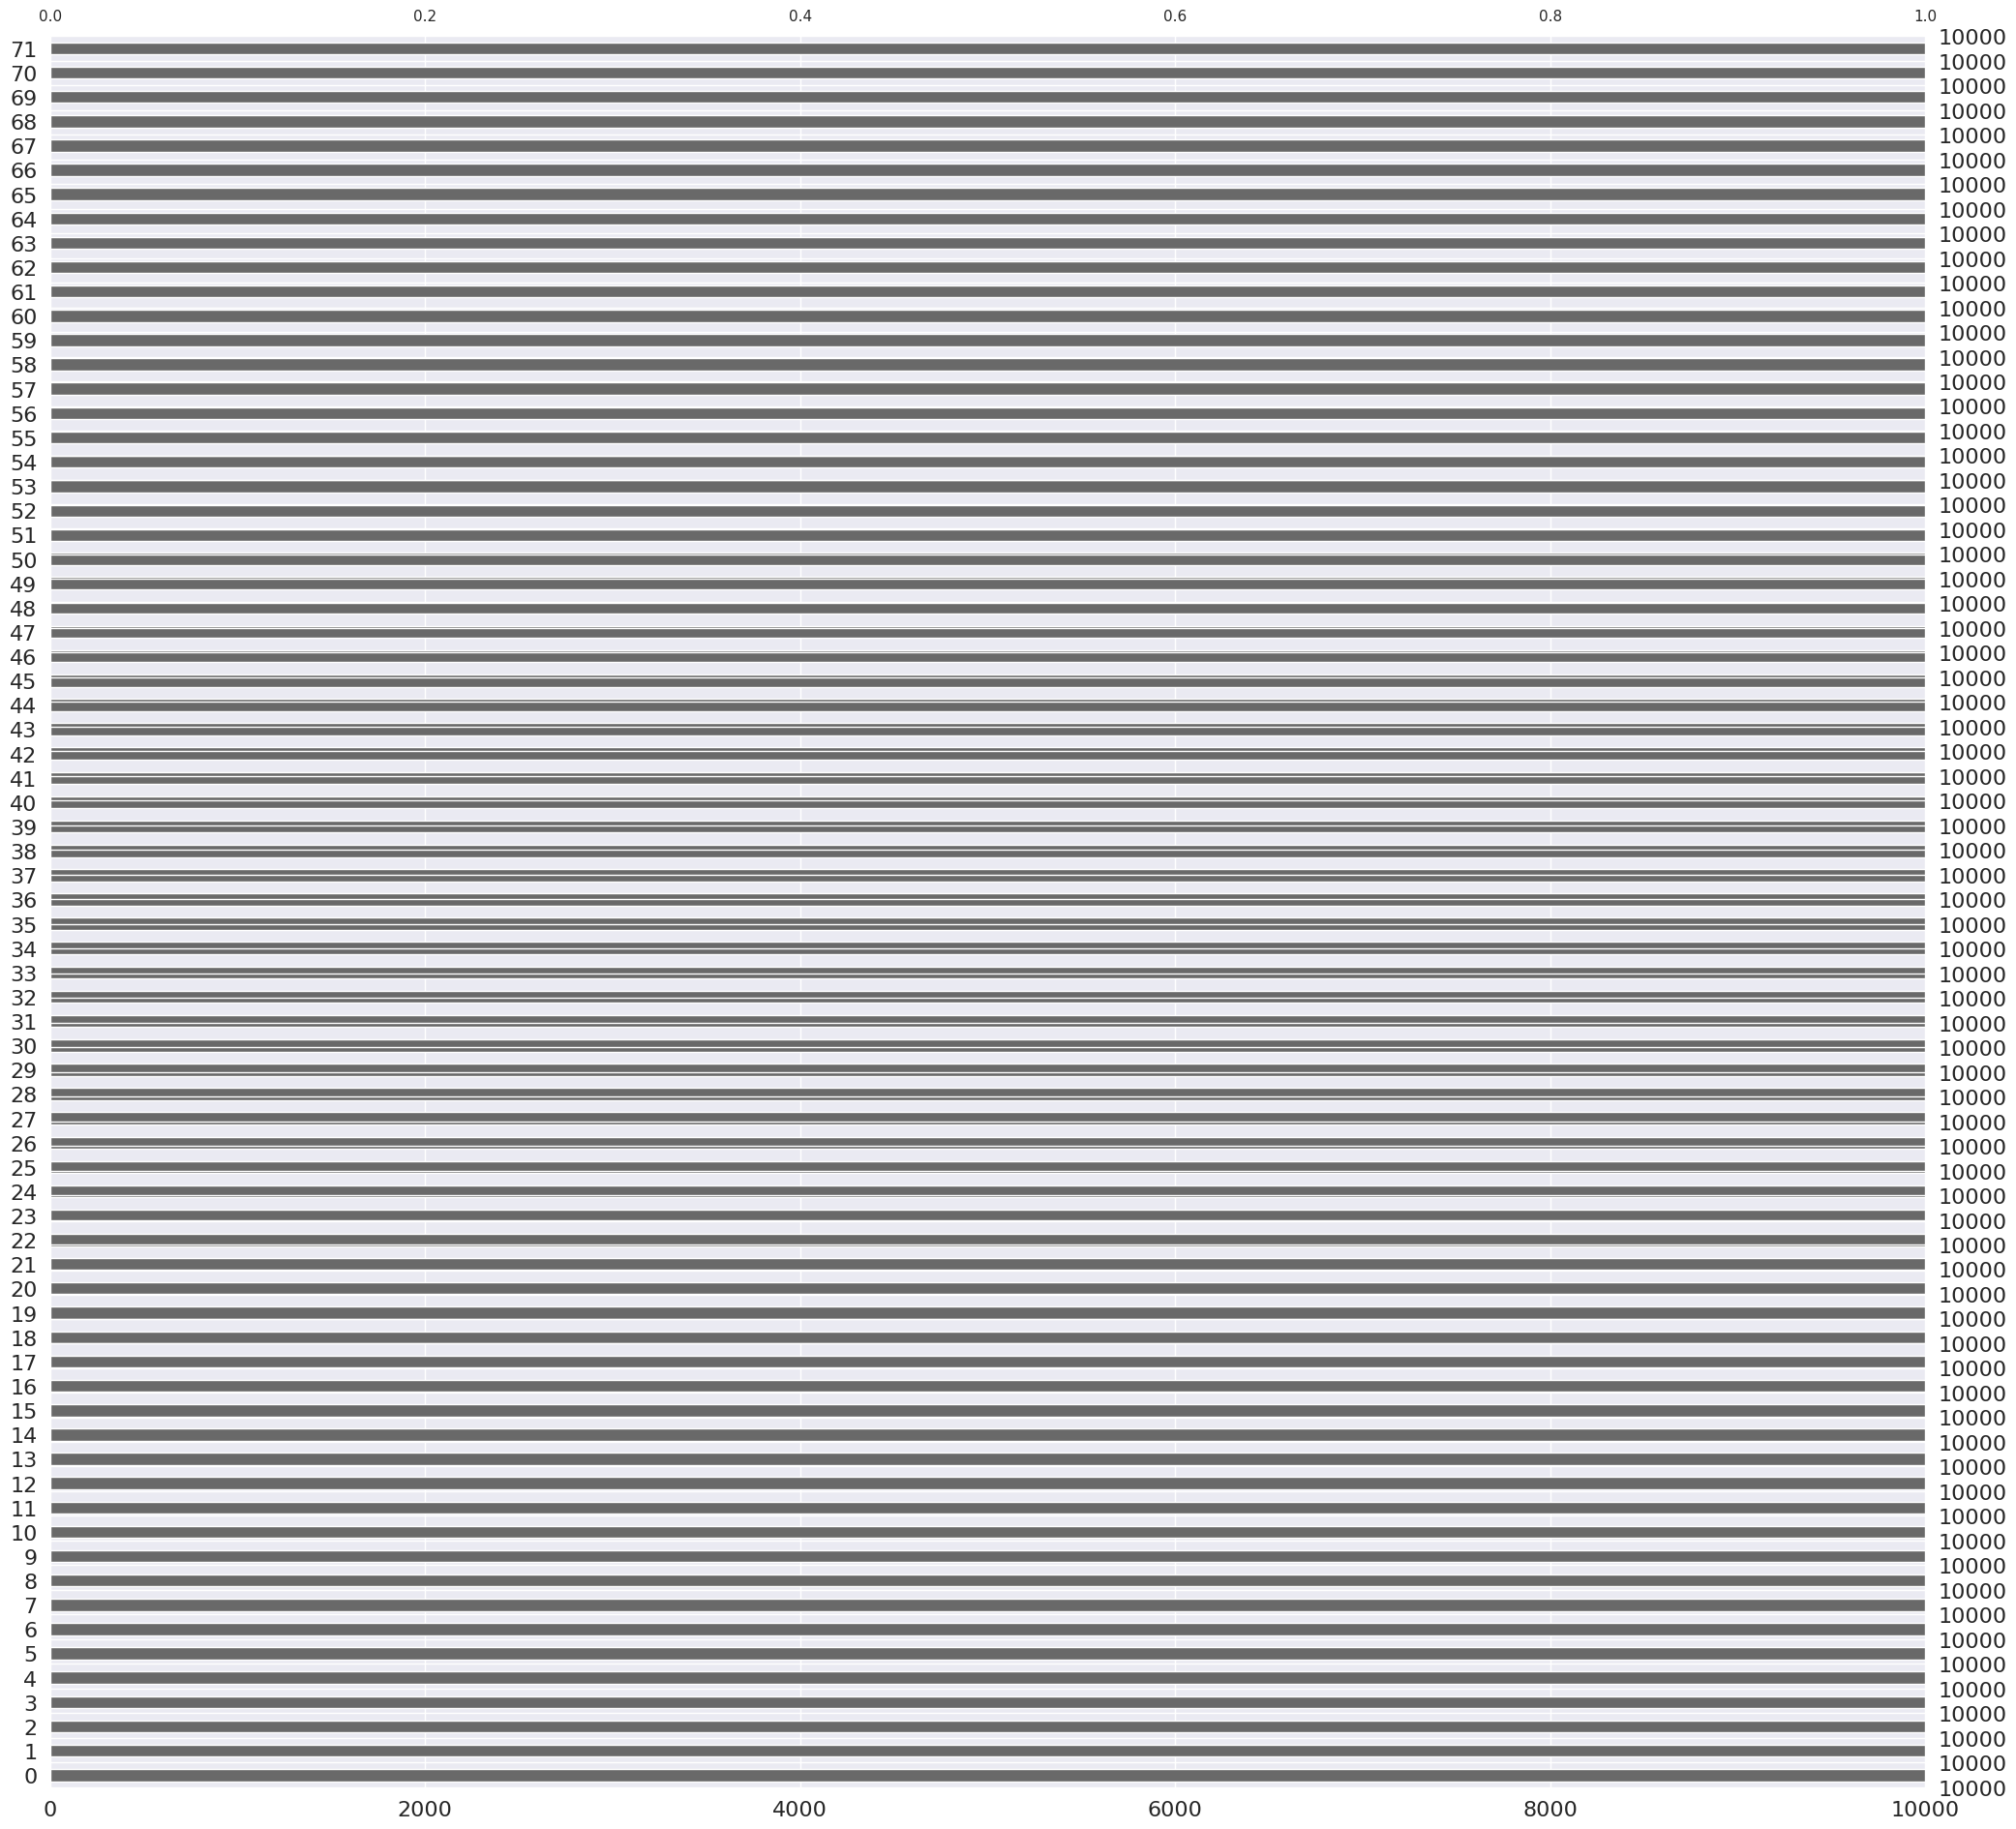

In [107]:
#ознакомимся с данными
info(product_valid)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Expected  10000 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB


None

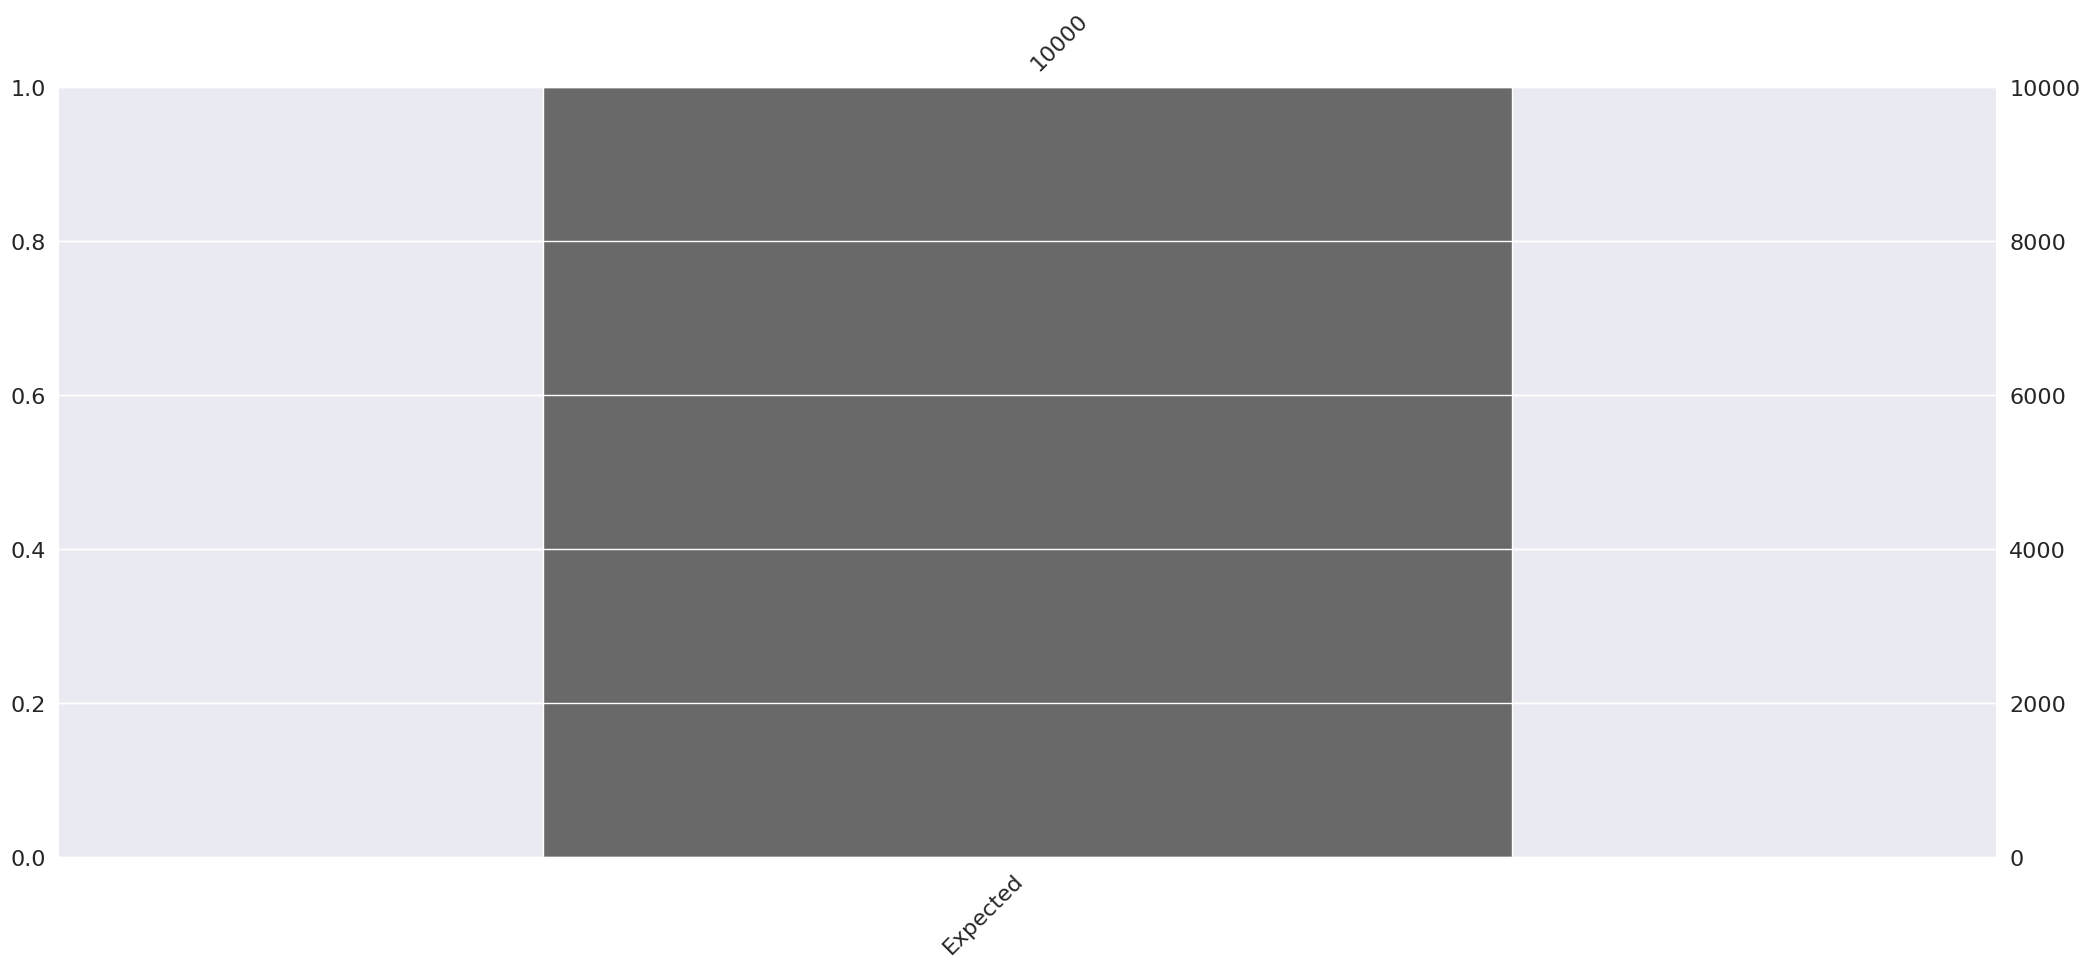

In [108]:
#ознакомимся с данными
info(product_valid_answer)

**Вывод:**

Для проведения исследования получены следующие данные:

  * `product_base` — анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72. В выборке 291 813 объектов;

- `product_train` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов). В выборке 9 999 объектов;

- `product_valid` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из product_base. В выборке 10 000 объектов;

- `product_valid_answer`- правильные ответы к предыдущему файлу. В выборке 10 000 объектов

Предварительно можно утверждать, что данных достаточно для проведения исследования.
    
В датасетах отсутствуют пропущенные значения и имеется корректный тип данных.

---

## Предобработка данных

Выполним предобработку данных.

In [109]:
# сохраним копию датафрейма до изменений
product_train_unprocessed = product_train.copy()

### Проверка пропусков

Гистограммы `msno` показали отсутствие пропущенных значений в датафреймах, дополнительной обработки не требуется.

### Проверка явных дубликатов

Проверим наличие явных дубликатов в датафреймах.

In [110]:
print("Product_base кол-во дубликатов:", product_base.duplicated().sum())
print("Product_train кол-во дубликатов:", product_train.duplicated().sum())
print("Product_valid кол-во дубликатов:", product_valid.duplicated().sum())
print("Product_valid_answer кол-во дубликатов:", product_valid_answer.duplicated().sum())

Product_base кол-во дубликатов: 11278
Product_train кол-во дубликатов: 243
Product_valid кол-во дубликатов: 265
Product_valid_answer кол-во дубликатов: 360


**Вывод:**

Датафреймы содержат явные дубликаты - это может означать, что одному искомому товару соответствует несколько товаров в выборке.

Сохраним дубликаты в датафреймах.

---

**Вывод раздела**

Для корректного проведения исследования выполнена предобработка данных:

- изучены пропуски в датафреймах;
- проверены дубликаты.

---

## Исследовательский анализ данных

Проведём исследовательский анализ всех признаков датафрейма `product_train`.

In [111]:
def visualize_feature_distribution(df, feature):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # вывод метода describe()
    display(df[feature].describe())

    # построение гистограммы распределения
    df[feature].plot(kind='hist', bins=20, ax=axes[0])
    axes[0].set_title(f'Гистограмма распределения признака {feature}', fontsize=14)
    axes[0].set_ylabel('Частота встречаемости')
    axes[0].set_xlabel('Наблюдаемые значения')

    # построение коробчатой диаграммы
    df[feature].plot(kind='box', ax=axes[1], rot=0)
    axes[1].set_title(f'Разброс значений признака {feature}', fontsize=14)
    axes[1].set_xlabel('Категория')
    axes[1].set_ylabel('Наблюдаемые значения')

    plt.tight_layout()
    plt.show()

count   9,999.000
mean      -85.470
std        25.986
min      -173.033
25%      -103.446
50%       -85.177
75%       -67.438
max         5.052
Name: 0, dtype: float64

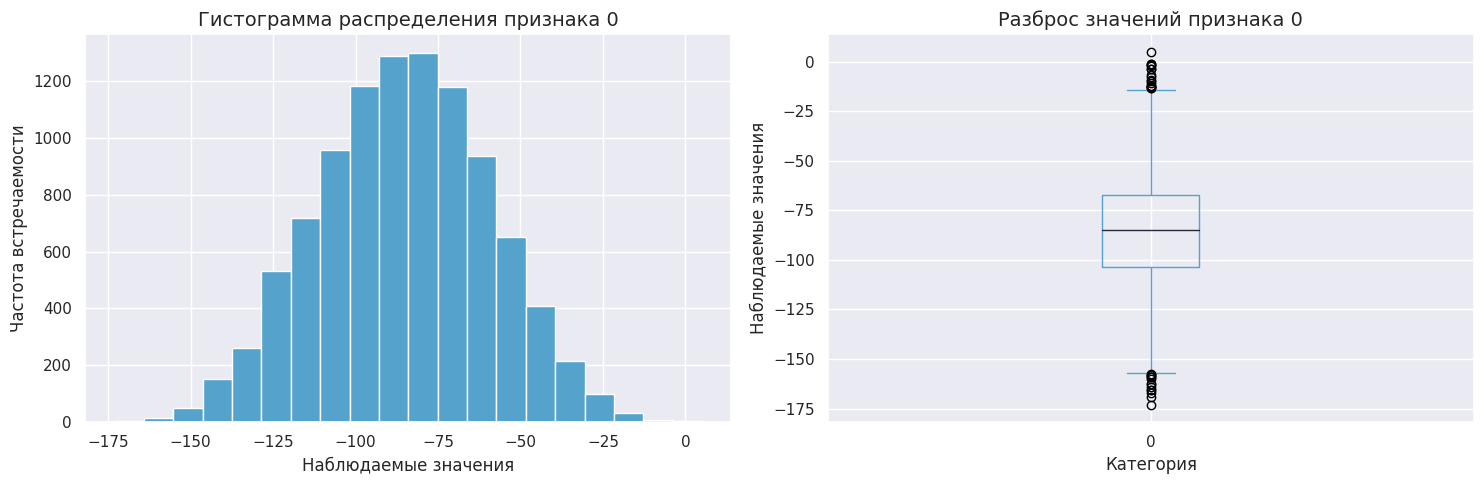

count   9,999.000
mean        7.608
std         4.986
min       -11.561
25%         4.179
50%         7.592
75%        10.990
max        26.742
Name: 1, dtype: float64

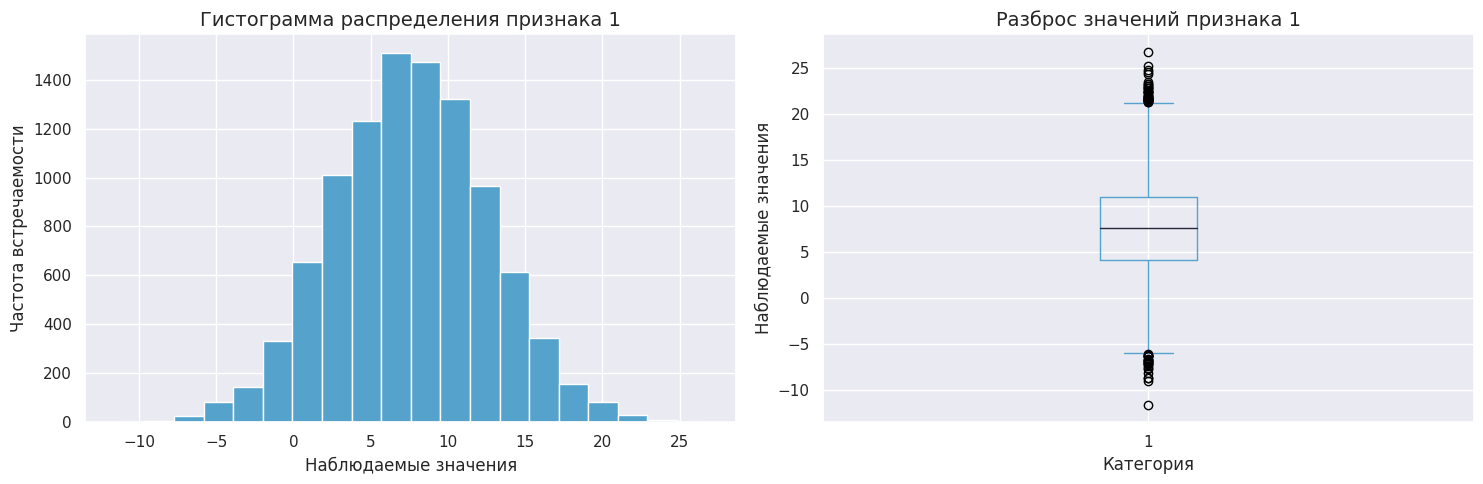

count   9,999.000
mean      -43.886
std        39.319
min      -187.293
25%       -69.991
50%       -43.010
75%       -17.224
max       134.860
Name: 2, dtype: float64

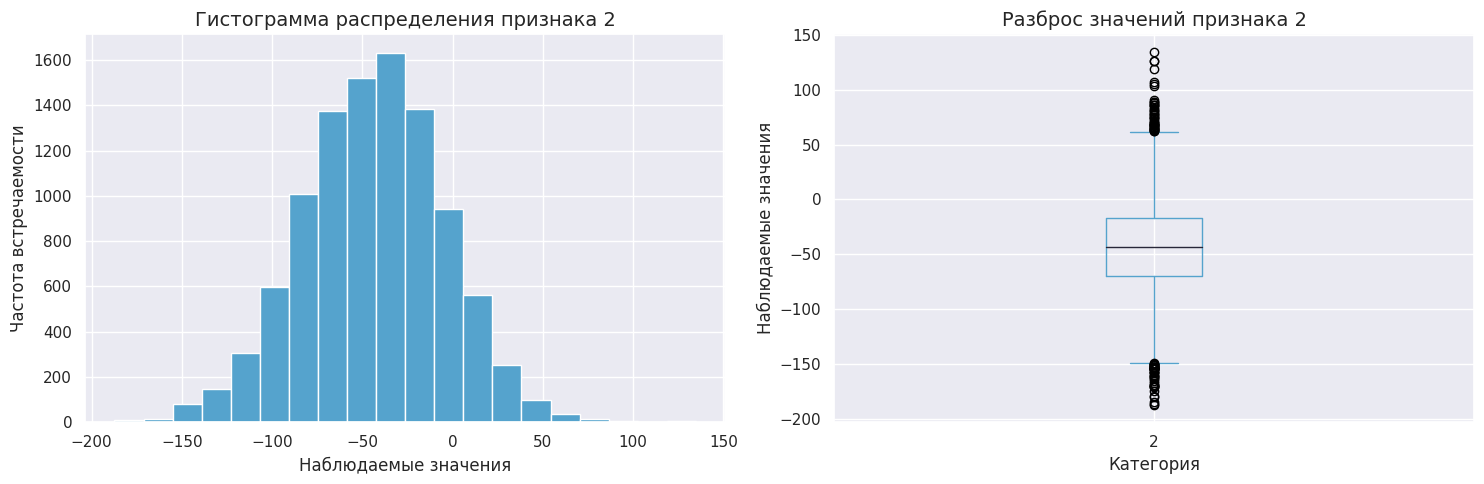

count   9,999.000
mean     -146.204
std        20.310
min      -219.725
25%      -160.033
50%      -146.576
75%      -132.676
max       -71.195
Name: 3, dtype: float64

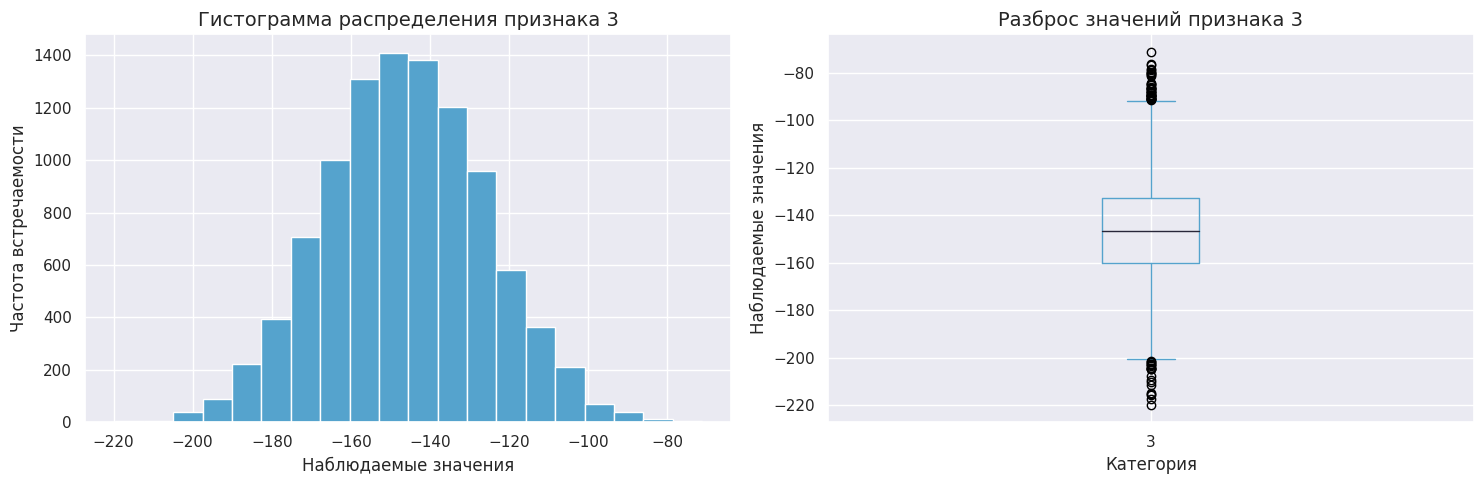

count   9,999.000
mean      111.980
std        47.600
min       -71.243
25%        79.712
50%       112.233
75%       144.053
max       297.369
Name: 4, dtype: float64

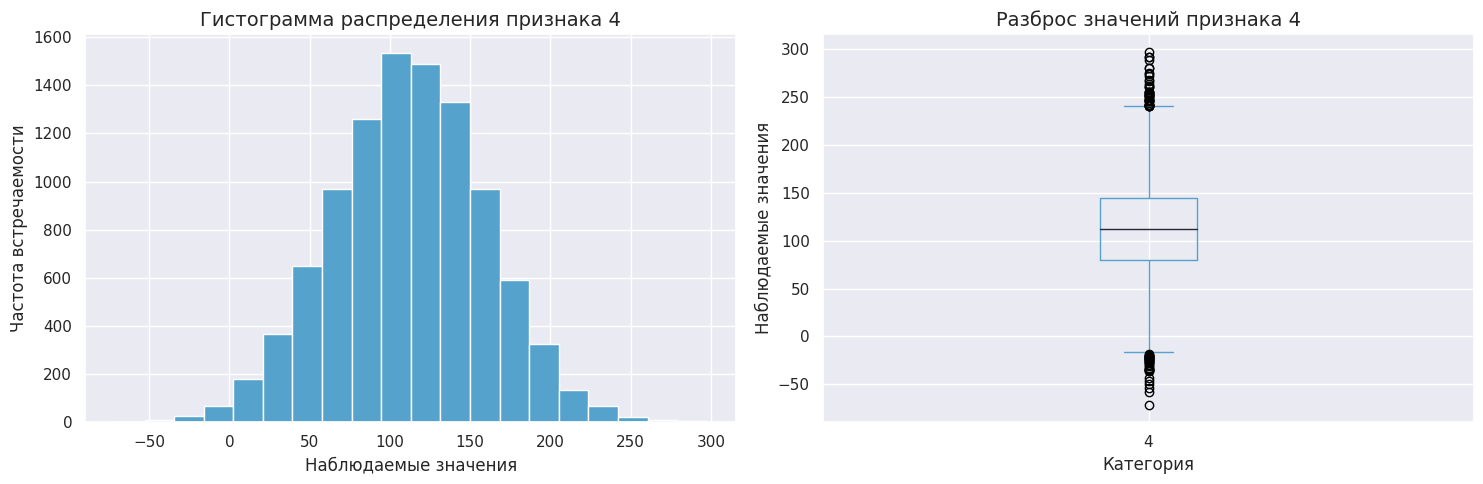

count   9,999.000
mean      -73.679
std        28.744
min      -184.962
25%       -93.620
50%       -74.031
75%       -54.169
max        31.379
Name: 5, dtype: float64

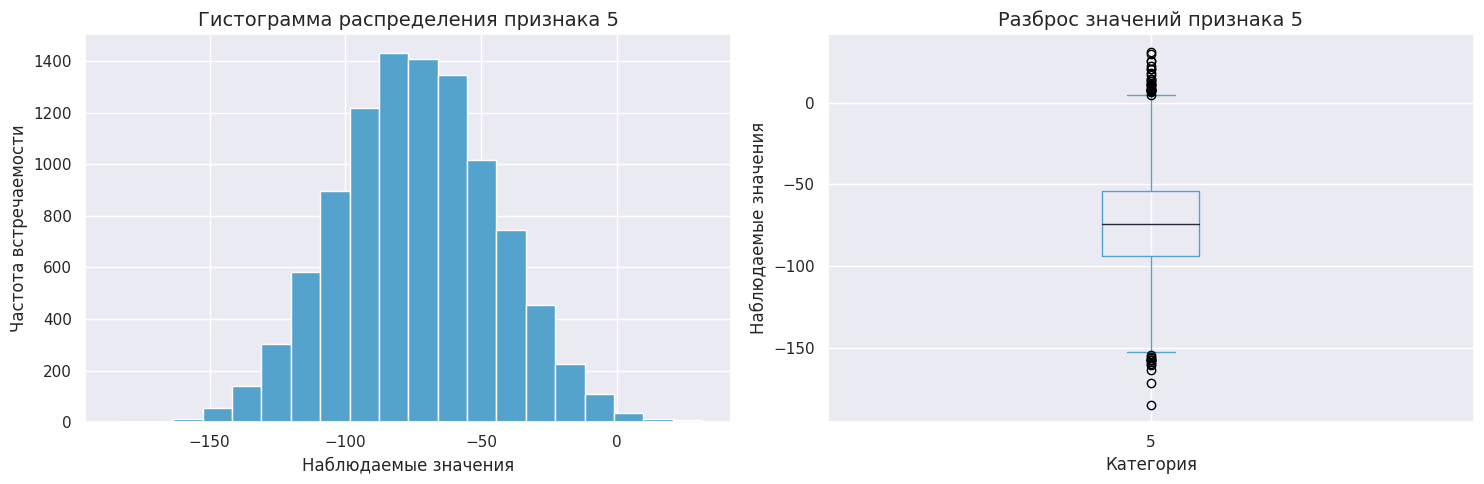

count   9,999.000
mean     -443.891
std       281.494
min      -791.444
25%      -757.629
50%      -517.673
75%      -203.438
max       109.632
Name: 6, dtype: float64

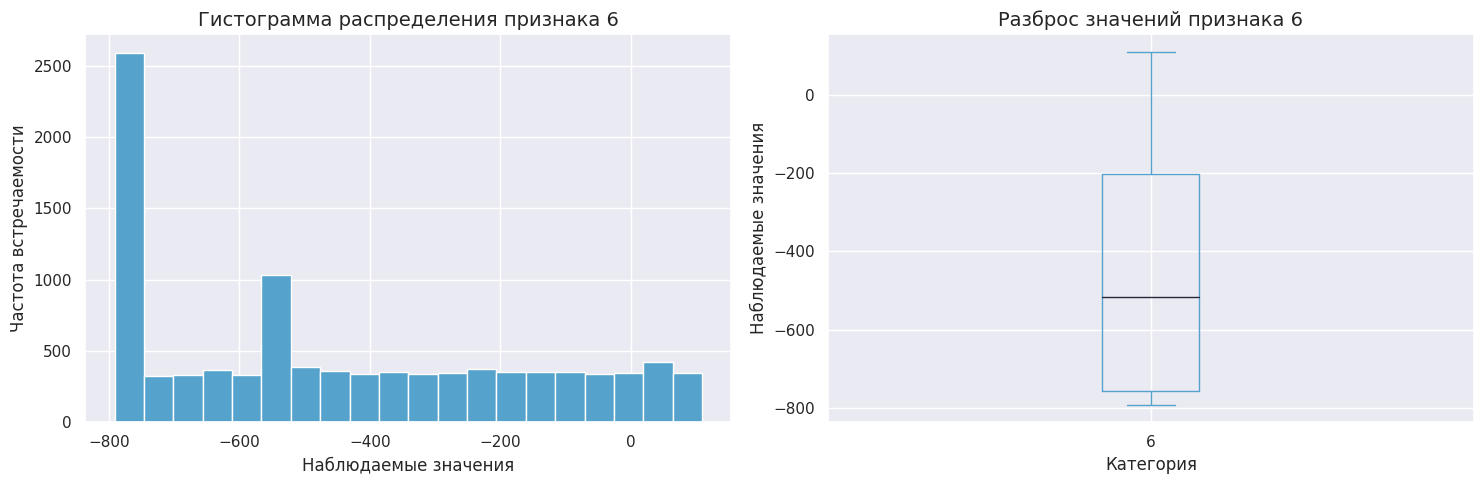

count   9,999.000
mean       21.821
std        66.450
min      -250.681
25%       -21.344
50%        22.234
75%        66.437
max       261.413
Name: 7, dtype: float64

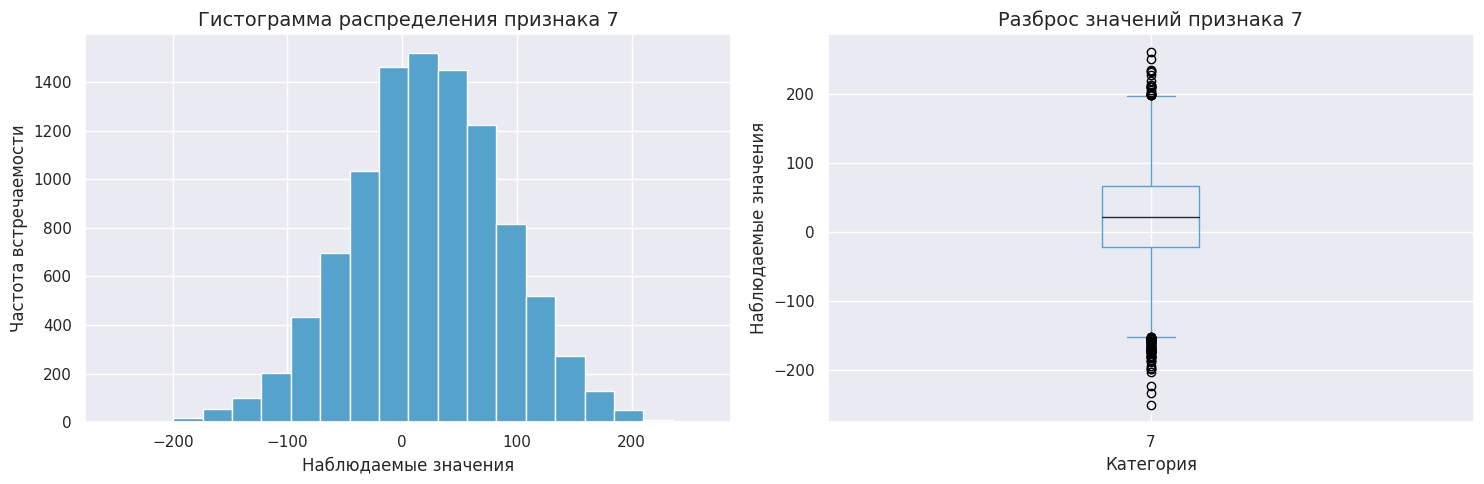

count   9,999.000
mean      123.107
std         6.419
min        99.002
25%       118.788
50%       123.003
75%       127.499
max       145.178
Name: 8, dtype: float64

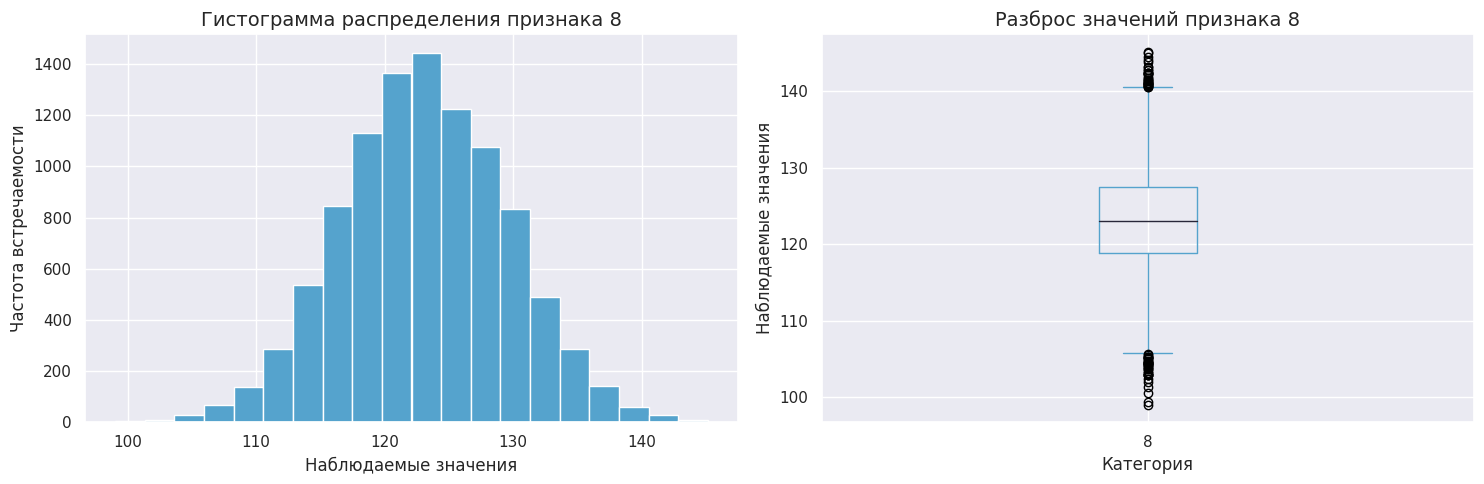

count   9,999.000
mean      126.418
std        64.858
min      -113.105
25%        81.960
50%       126.280
75%       169.960
max       353.215
Name: 9, dtype: float64

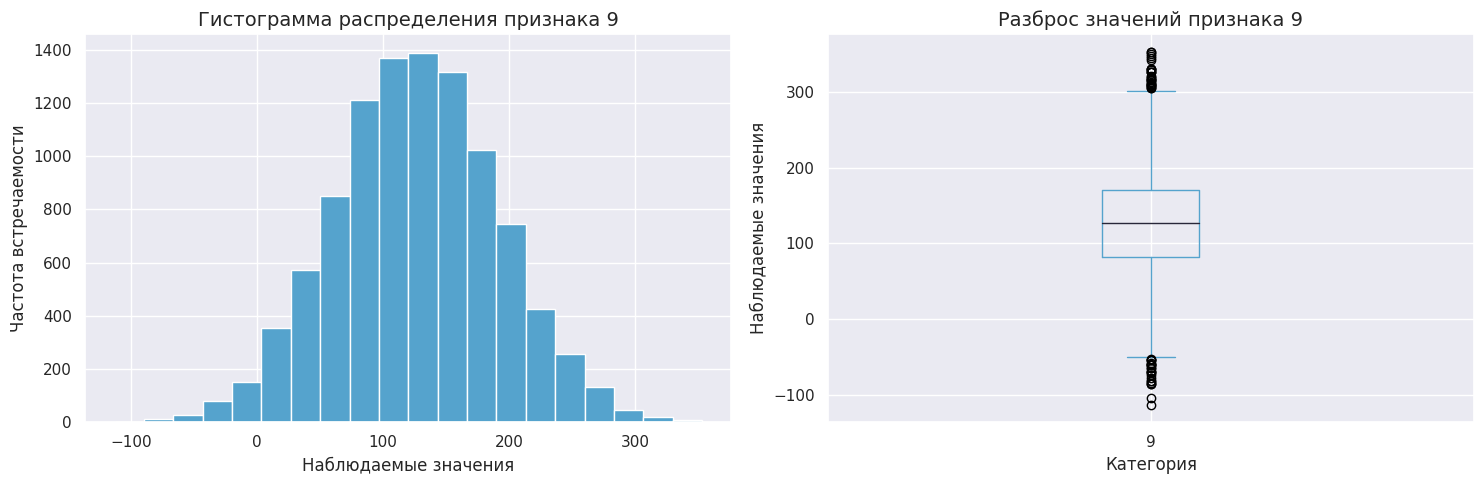

count   9,999.000
mean     -140.639
std        41.385
min      -287.203
25%      -168.316
50%      -140.114
75%      -112.591
max        14.706
Name: 10, dtype: float64

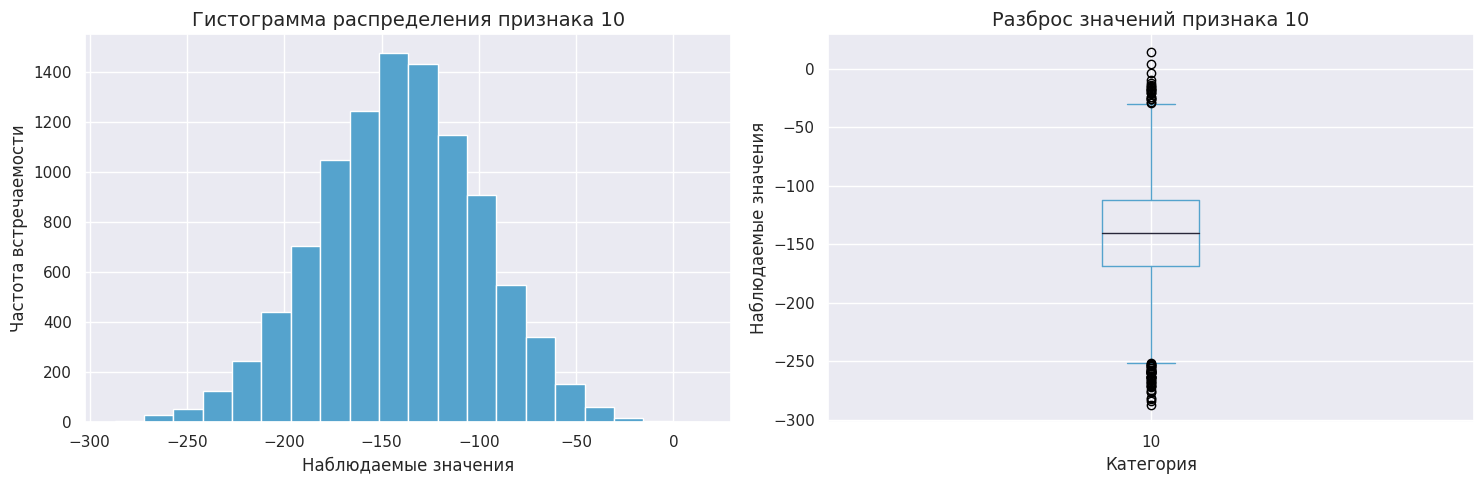

count   9,999.000
mean      -69.335
std        51.226
min      -344.521
25%      -103.138
50%       -68.799
75%       -35.206
max       133.852
Name: 11, dtype: float64

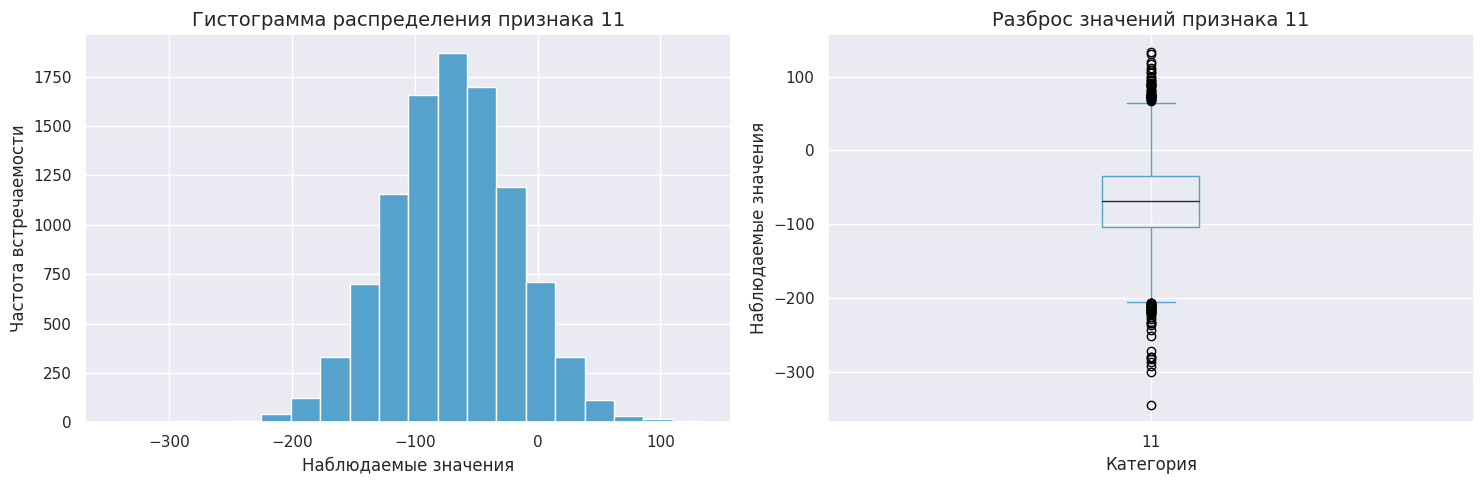

count   9,999.000
mean      -42.287
std        40.947
min      -201.855
25%       -70.147
50%       -41.110
75%       -14.515
max        89.710
Name: 12, dtype: float64

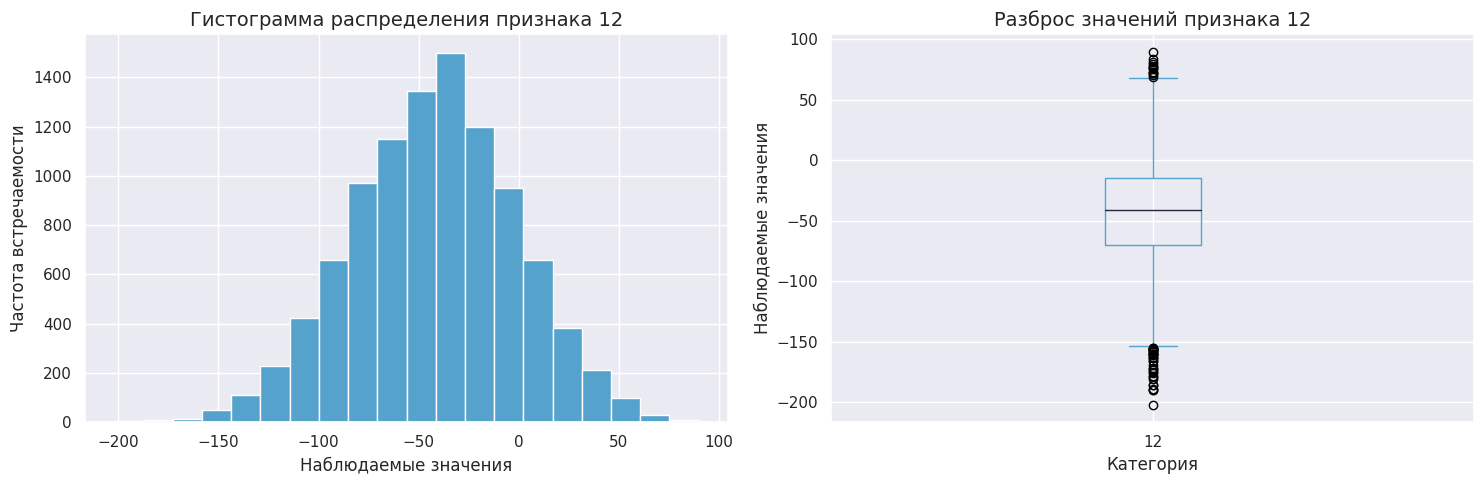

count   9,999.000
mean        5.943
std        37.525
min      -128.040
25%       -19.432
50%         6.031
75%        31.545
max       134.725
Name: 13, dtype: float64

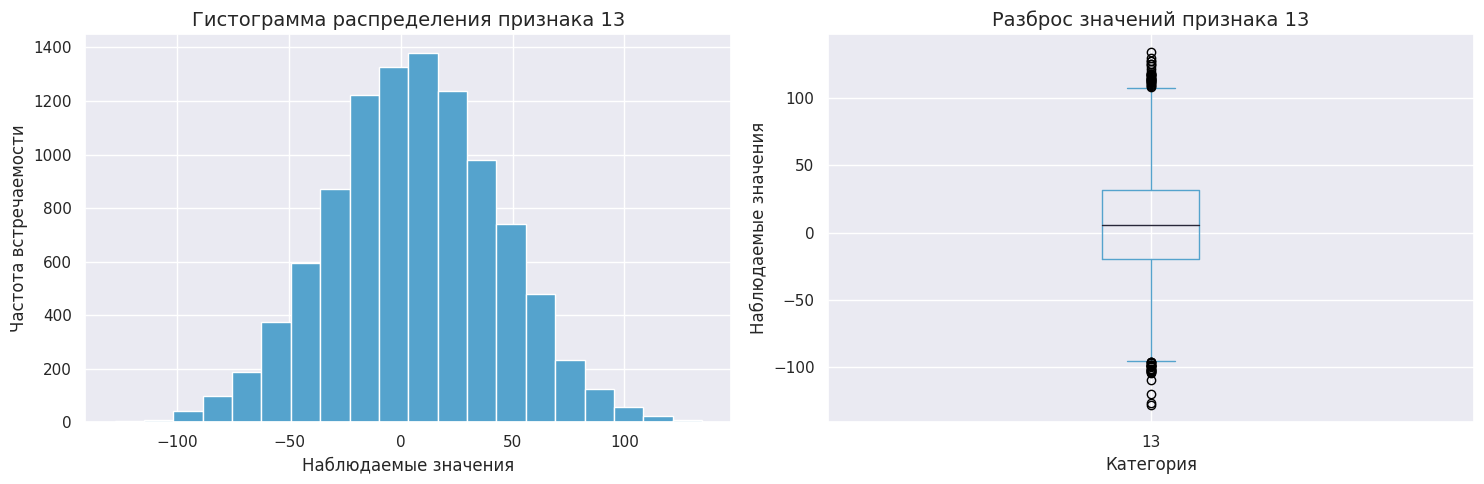

count   9,999.000
mean      149.113
std        34.055
min        21.577
25%       126.442
50%       150.225
75%       172.528
max       278.276
Name: 14, dtype: float64

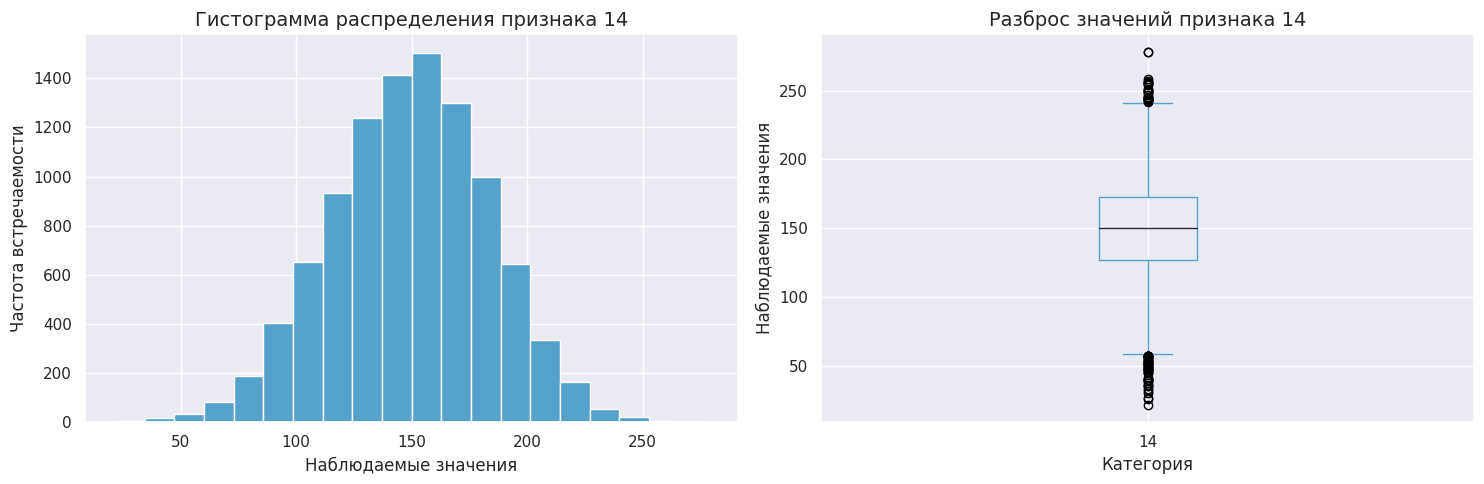

count   9,999.000
mean      -23.937
std        13.016
min       -77.179
25%       -32.289
50%       -23.807
75%       -15.527
max        30.951
Name: 15, dtype: float64

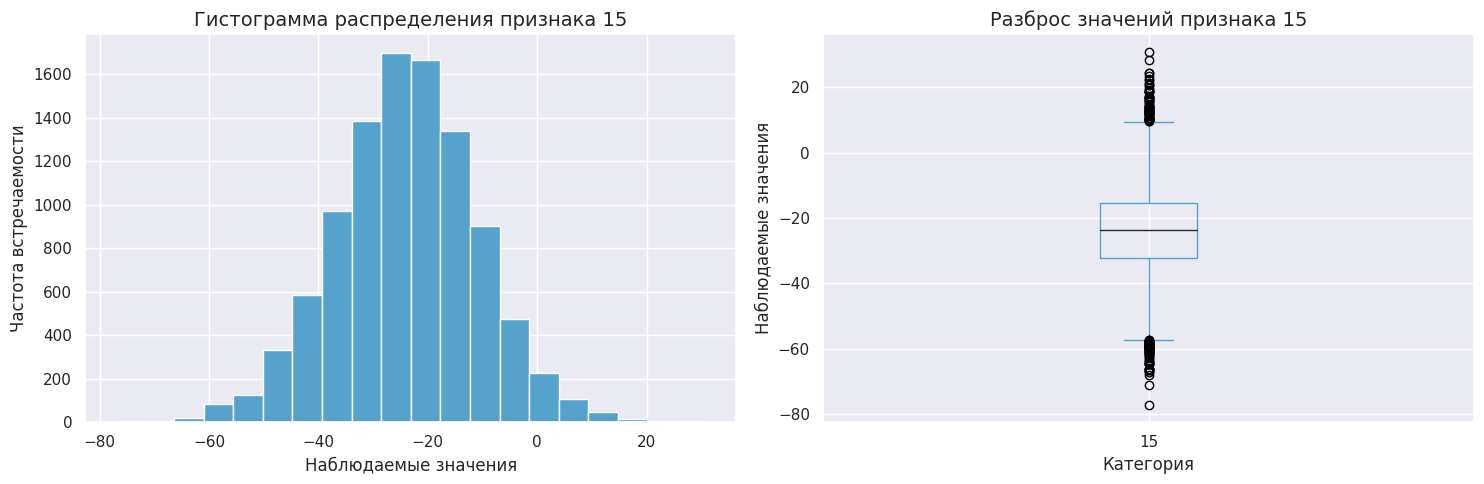

count   9,999.000
mean       -1.953
std        20.951
min       -70.051
25%       -16.294
50%        -2.042
75%        11.982
max        88.696
Name: 16, dtype: float64

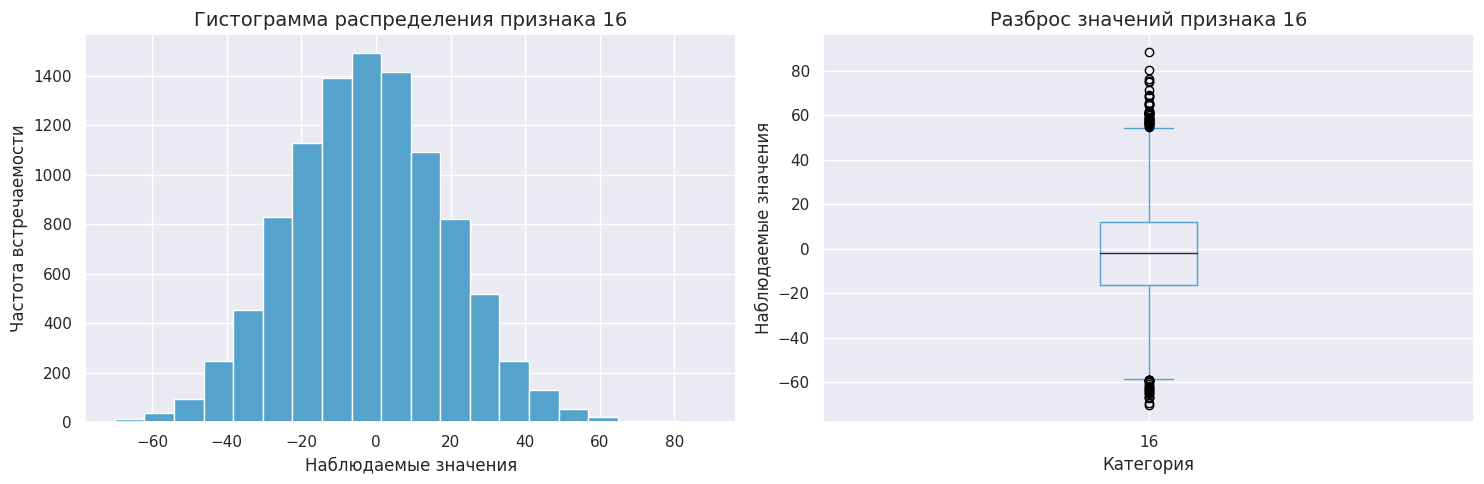

count   9,999.000
mean      -13.266
std        54.944
min      -222.328
25%       -49.631
50%       -12.336
75%        24.029
max       189.463
Name: 17, dtype: float64

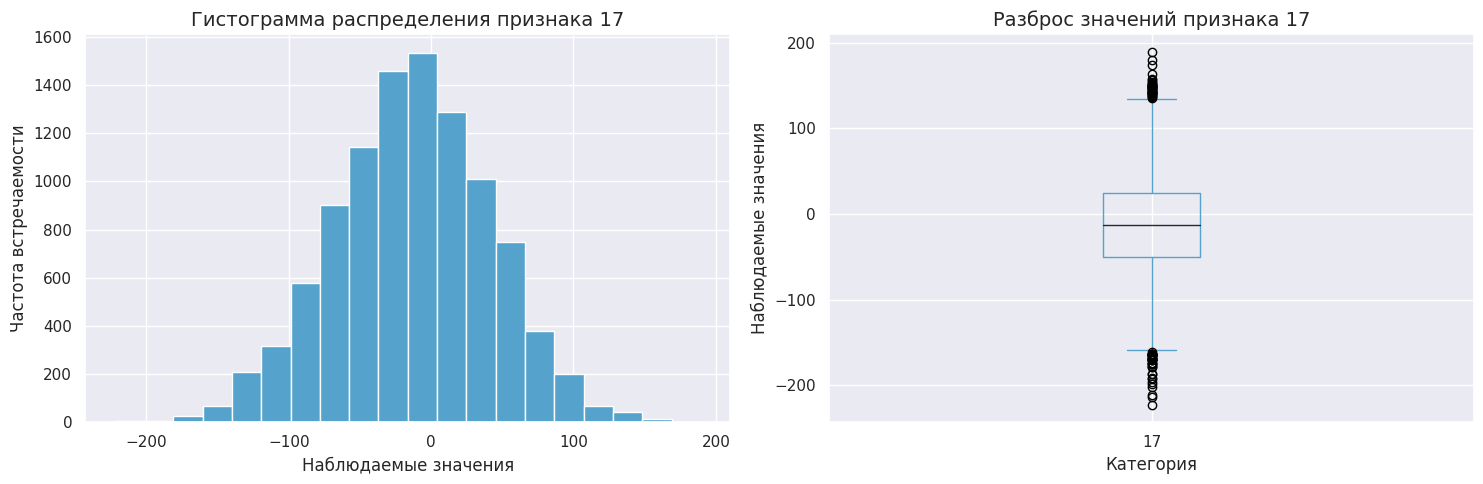

count   9,999.000
mean     -138.189
std        48.968
min      -329.598
25%      -171.157
50%      -138.570
75%      -106.152
max        82.684
Name: 18, dtype: float64

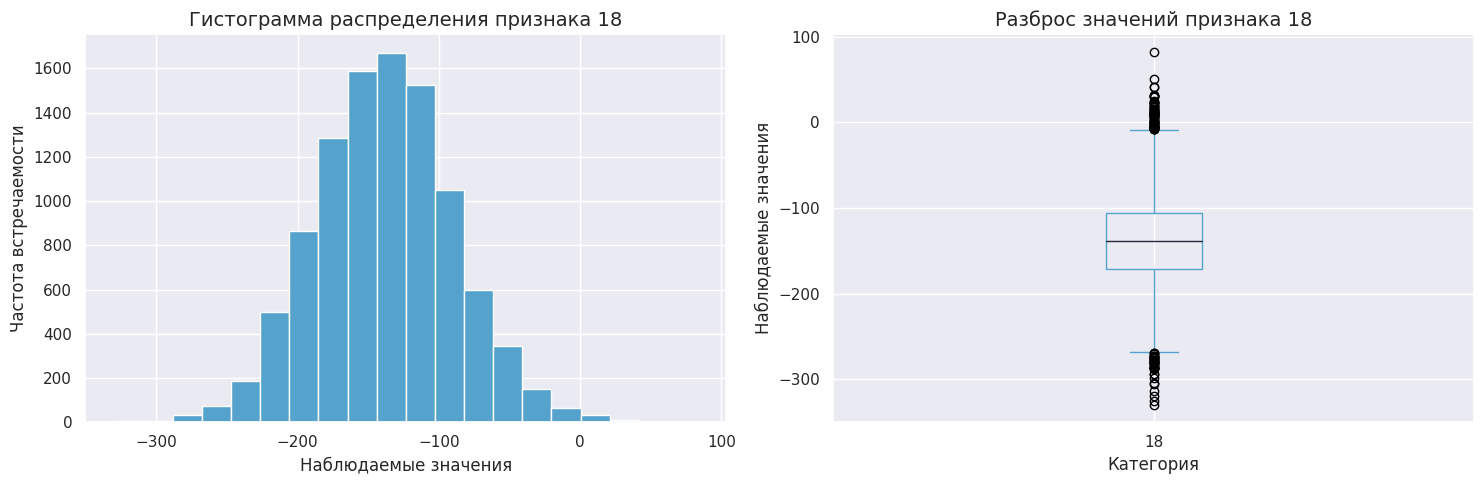

count   9,999.000
mean      -79.180
std         0.778
min       -82.253
25%       -79.682
50%       -79.155
75%       -78.655
max       -76.700
Name: 19, dtype: float64

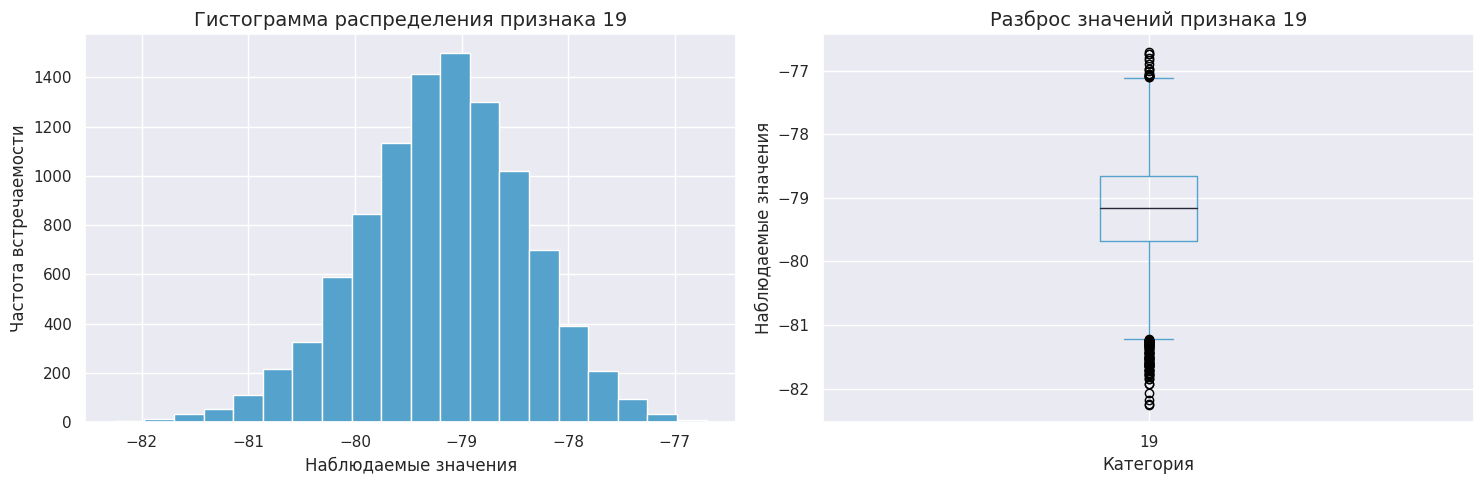

count   9,999.000
mean      -97.465
std        28.254
min      -228.986
25%      -115.317
50%       -96.681
75%       -78.146
max         0.244
Name: 20, dtype: float64

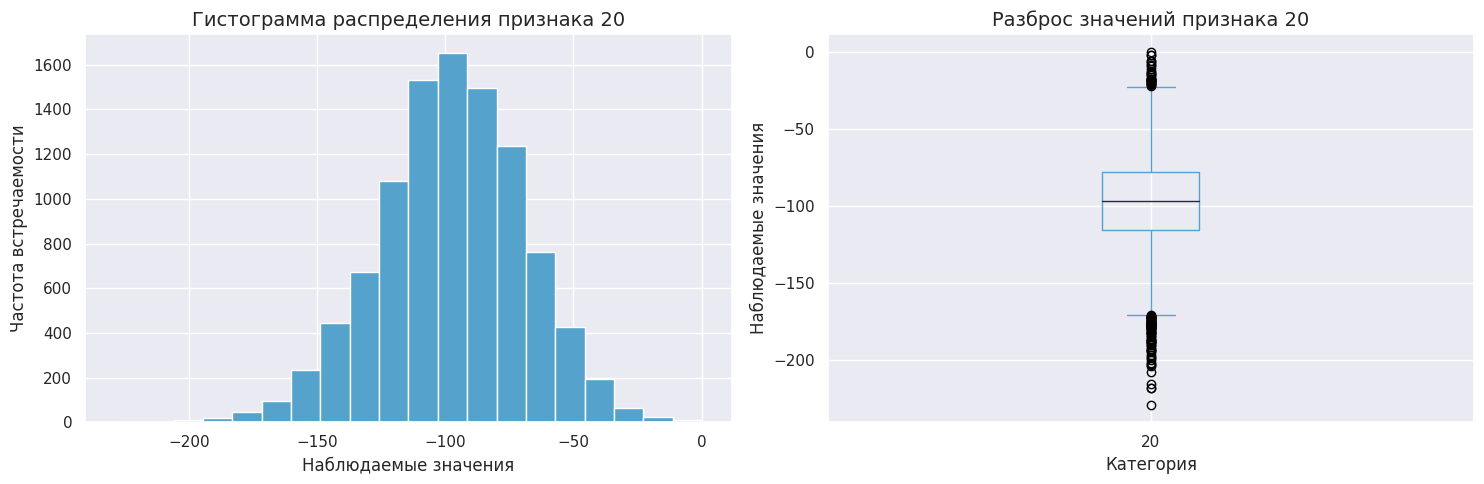

count   9,999.000
mean    1,299.002
std       371.743
min       136.900
25%     1,248.126
50%     1,507.231
75%     1,507.231
max     1,556.087
Name: 21, dtype: float64

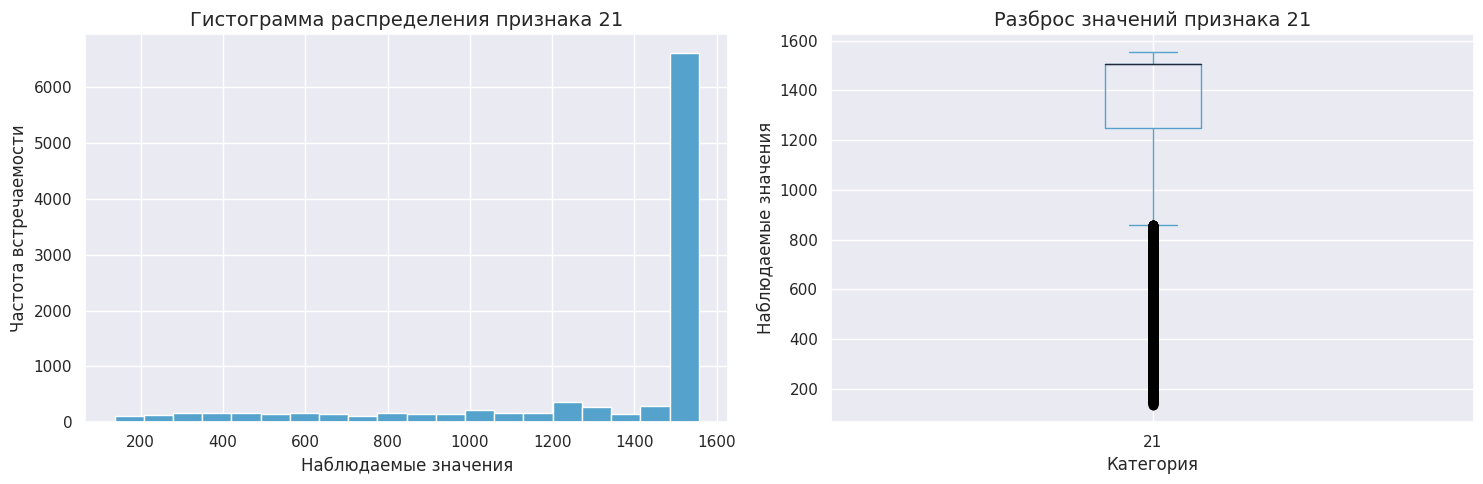

count   9,999.000
mean       -3.538
std        50.213
min      -174.593
25%       -37.117
50%        -3.494
75%        30.375
max       193.884
Name: 22, dtype: float64

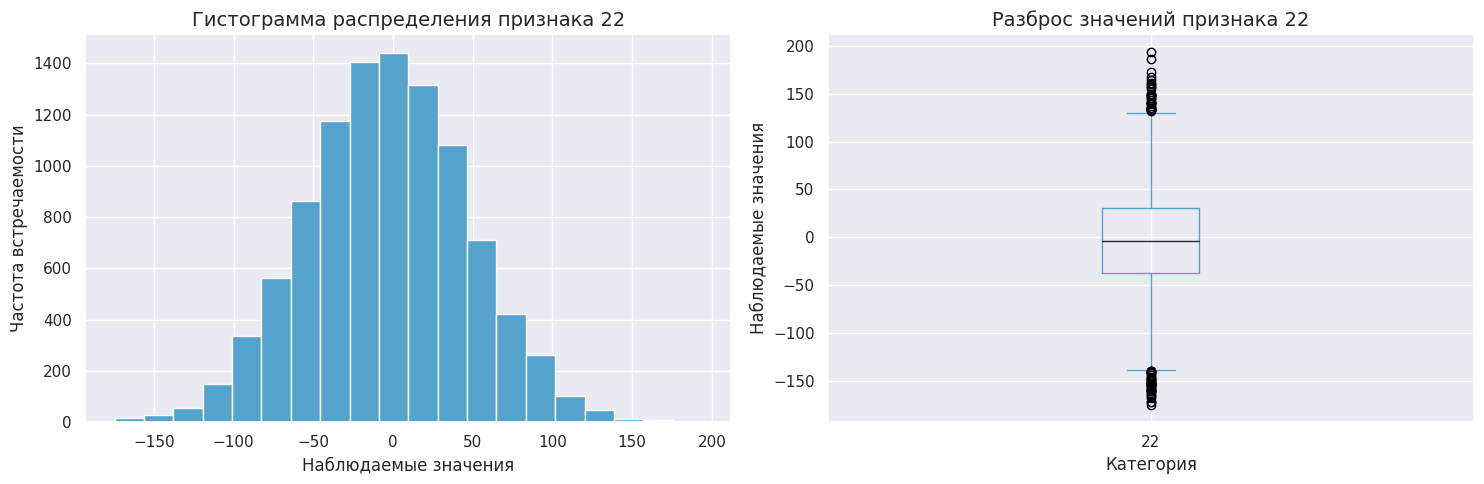

count   9,999.000
mean       56.512
std        35.452
min       -75.980
25%        32.634
50%        56.087
75%        79.851
max       193.121
Name: 23, dtype: float64

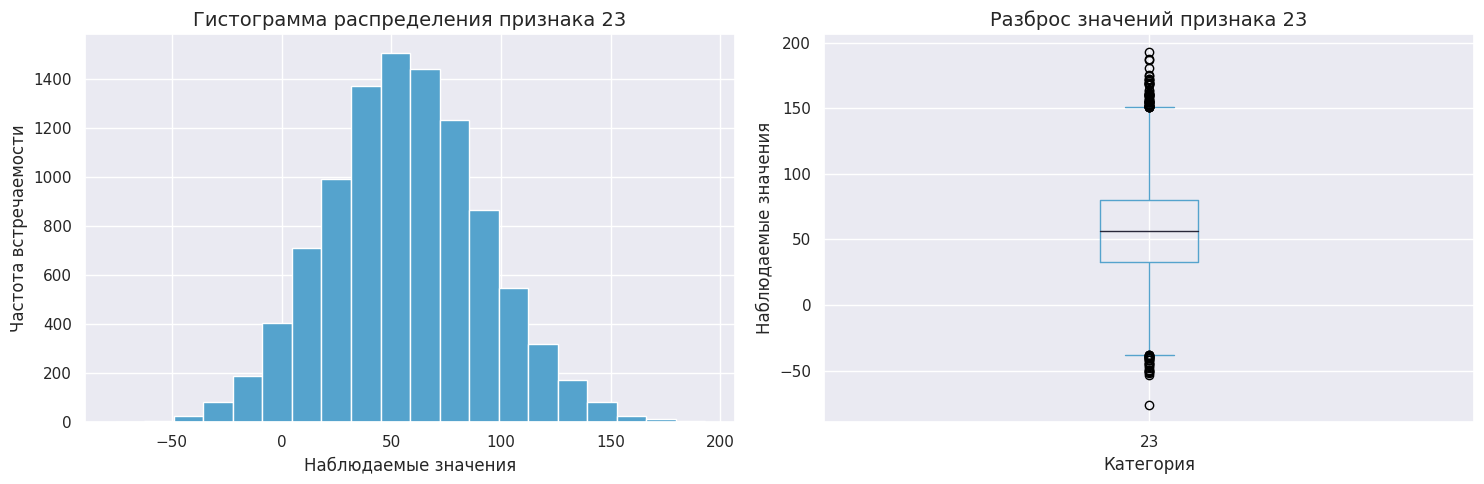

count   9,999.000
mean       23.048
std        41.190
min      -120.501
25%        -5.999
50%        23.236
75%        52.222
max       148.892
Name: 24, dtype: float64

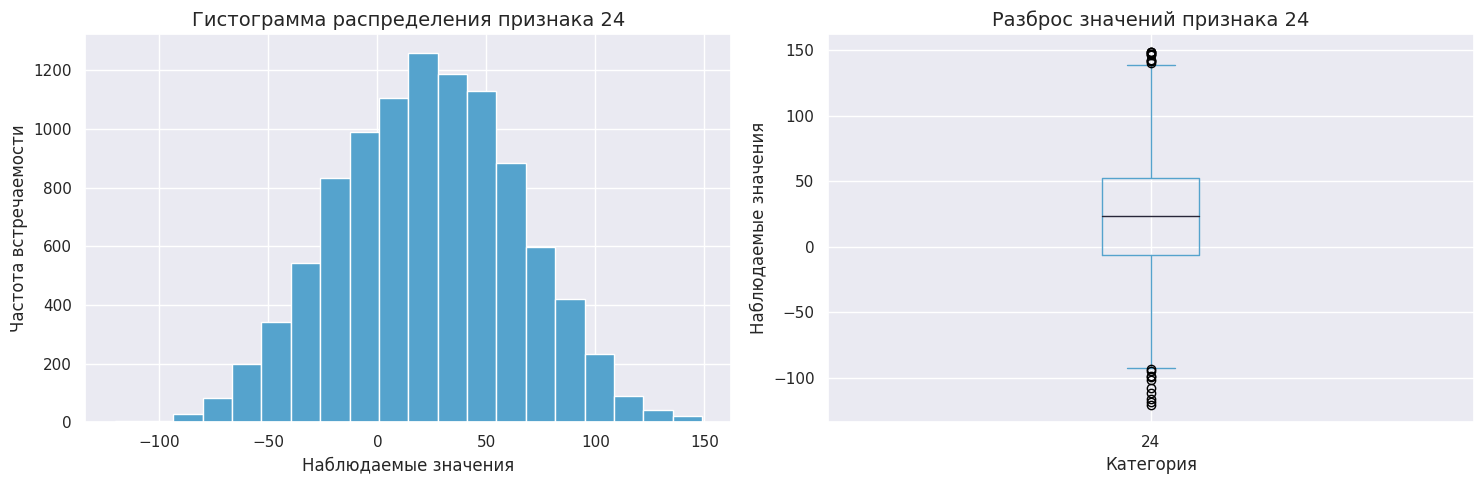

count   9,999.000
mean      741.741
std       193.164
min       -61.641
25%       813.770
50%       813.770
75%       813.770
max       845.477
Name: 25, dtype: float64

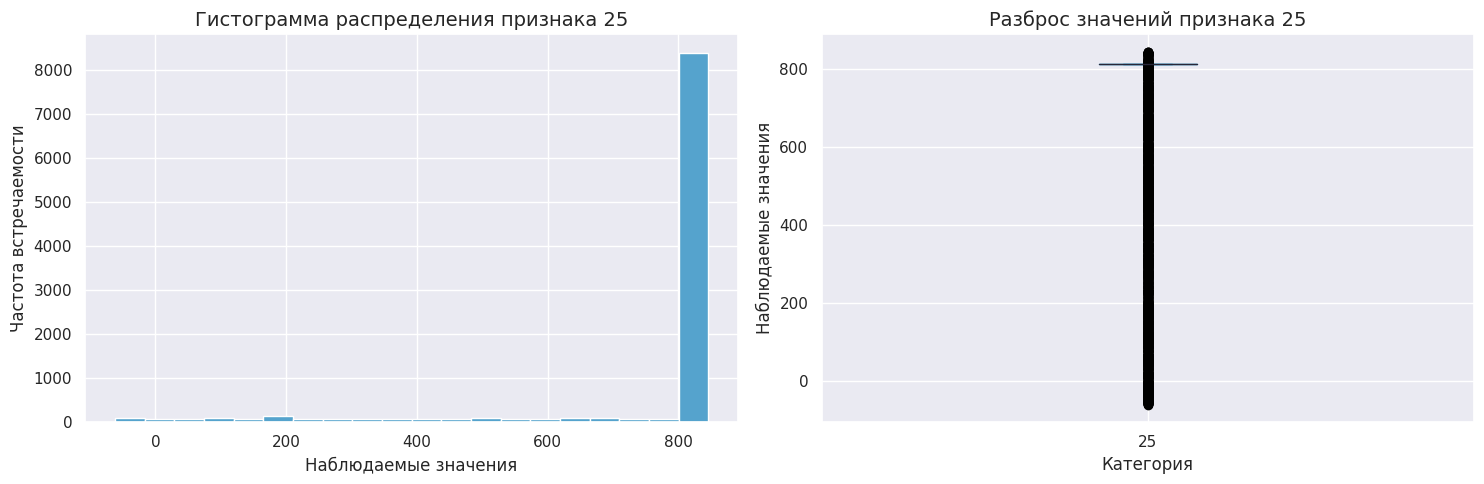

count   9,999.000
mean      -64.888
std        63.594
min      -318.193
25%      -106.627
50%       -65.237
75%       -22.826
max       202.054
Name: 26, dtype: float64

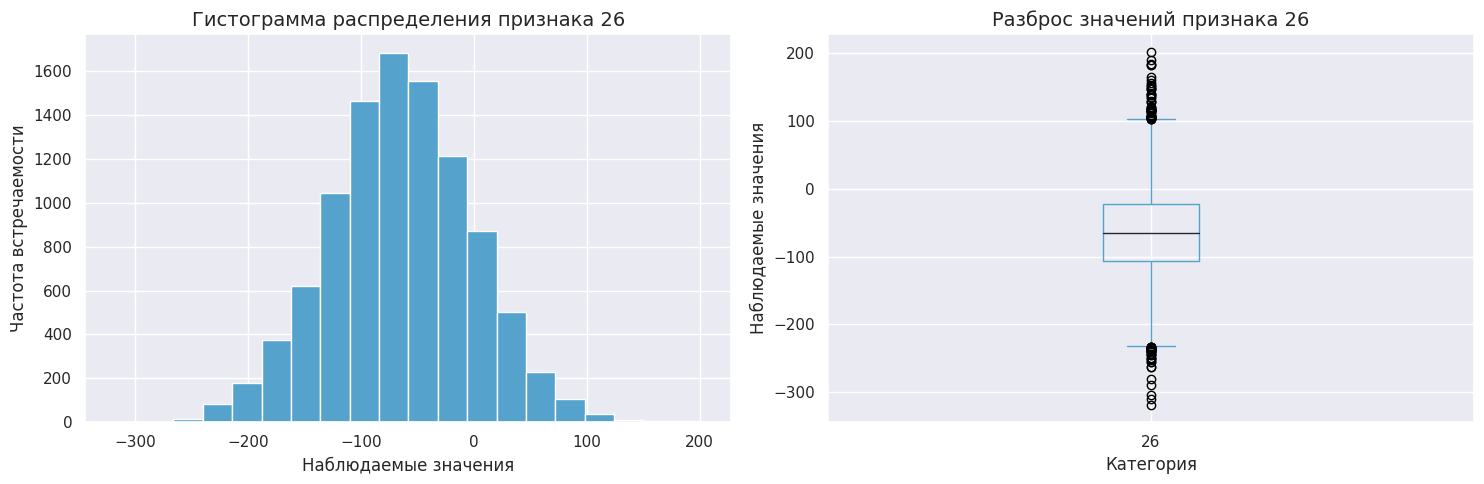

count   9,999.000
mean       16.298
std         4.813
min        -4.306
25%        13.132
50%        16.367
75%        19.539
max        35.142
Name: 27, dtype: float64

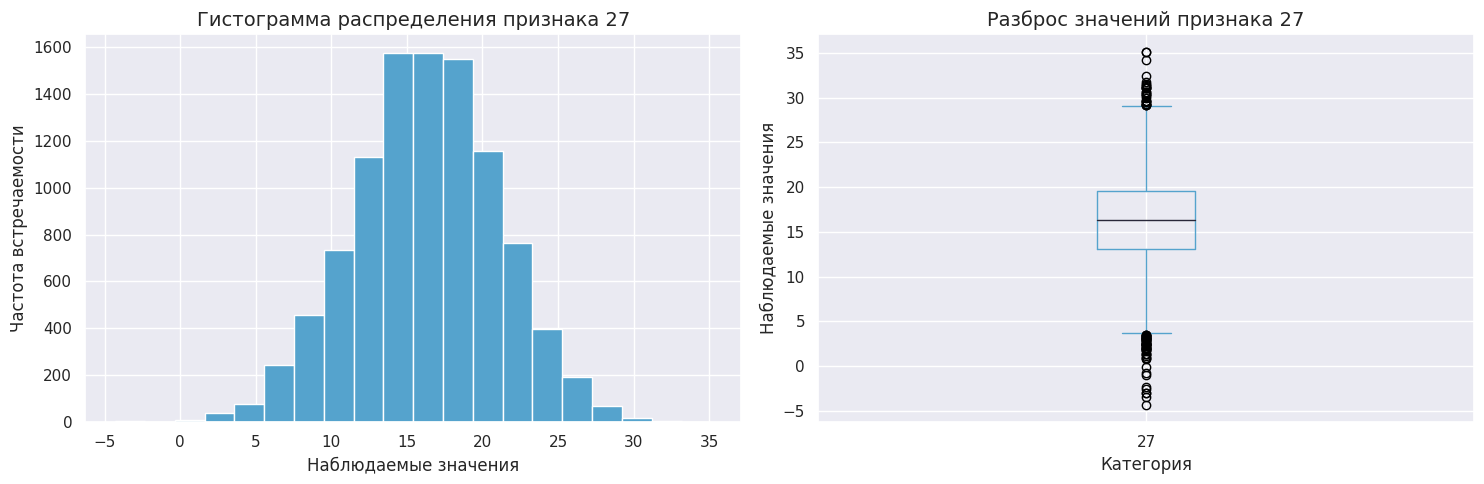

count   9,999.000
mean      -86.455
std        48.752
min      -269.042
25%      -119.624
50%       -87.253
75%       -53.618
max       107.758
Name: 28, dtype: float64

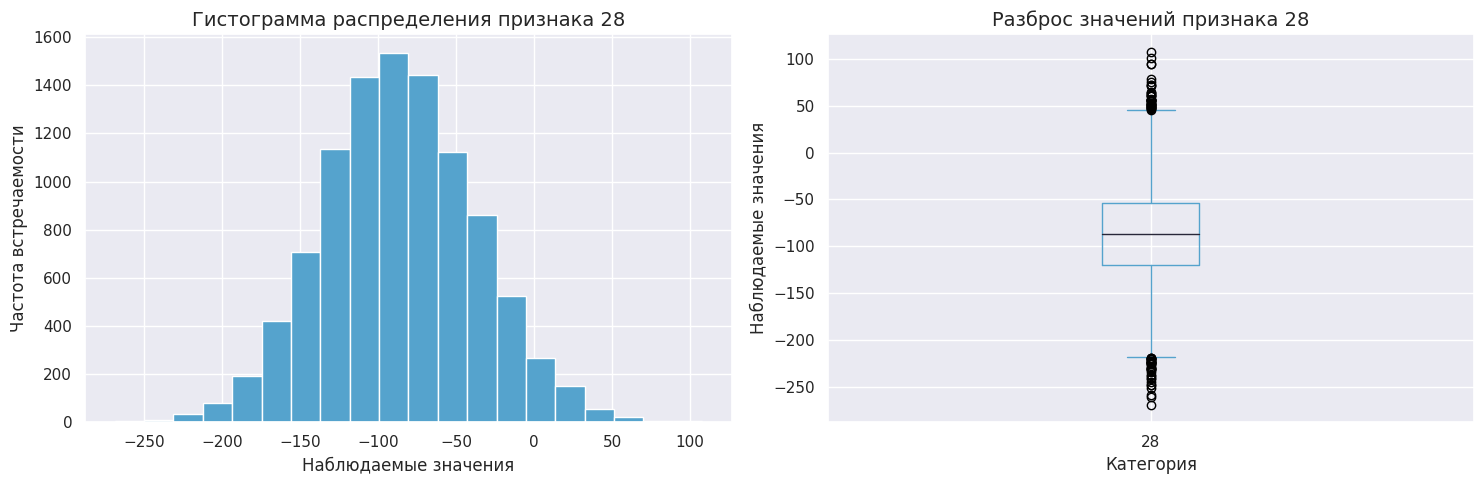

count   9,999.000
mean      152.170
std        10.352
min       114.099
25%       145.391
50%       152.007
75%       158.905
max       193.917
Name: 29, dtype: float64

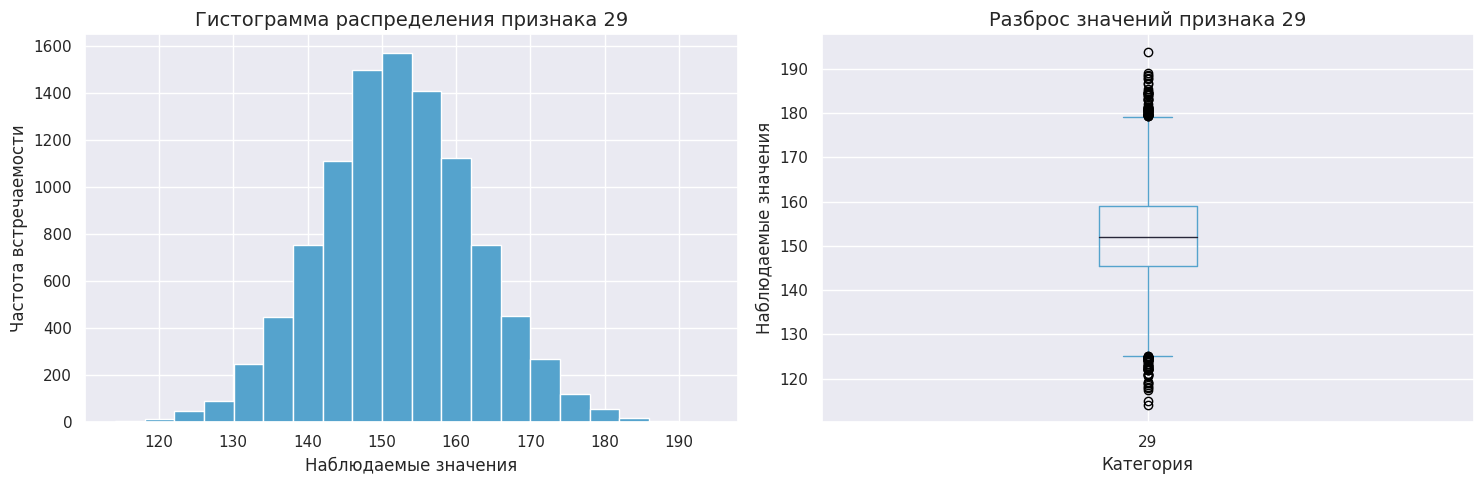

count   9,999.000
mean      -13.677
std        29.425
min      -125.440
25%       -32.951
50%       -13.045
75%         6.303
max        77.790
Name: 30, dtype: float64

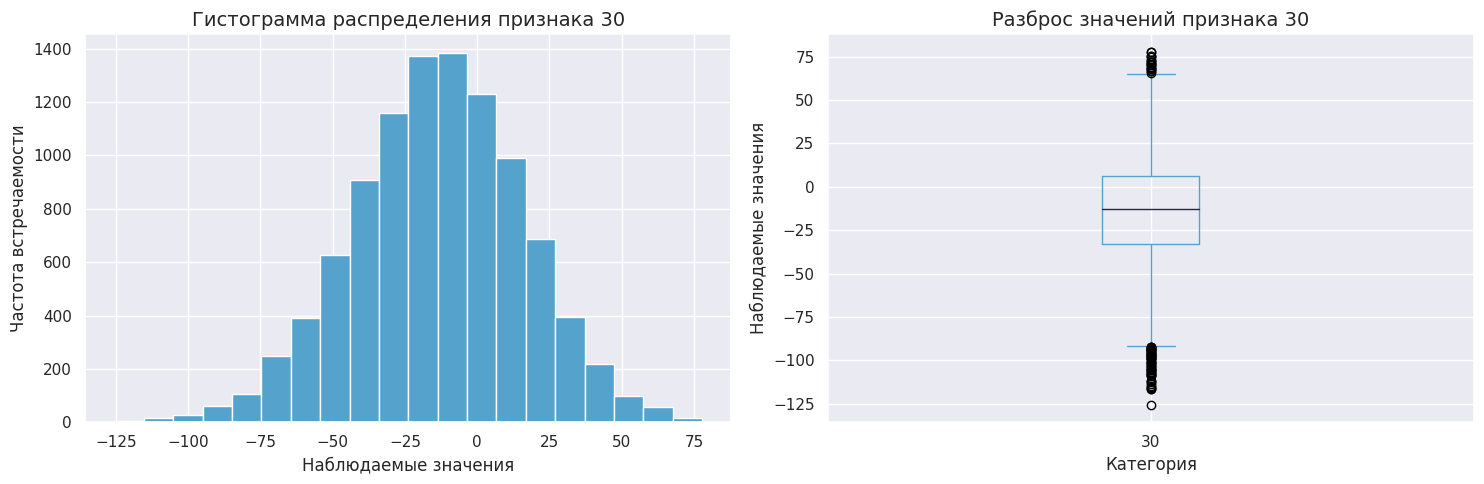

count   9,999.000
mean     -144.462
std        36.344
min      -261.523
25%      -169.026
50%      -145.153
75%      -119.740
max        -3.318
Name: 31, dtype: float64

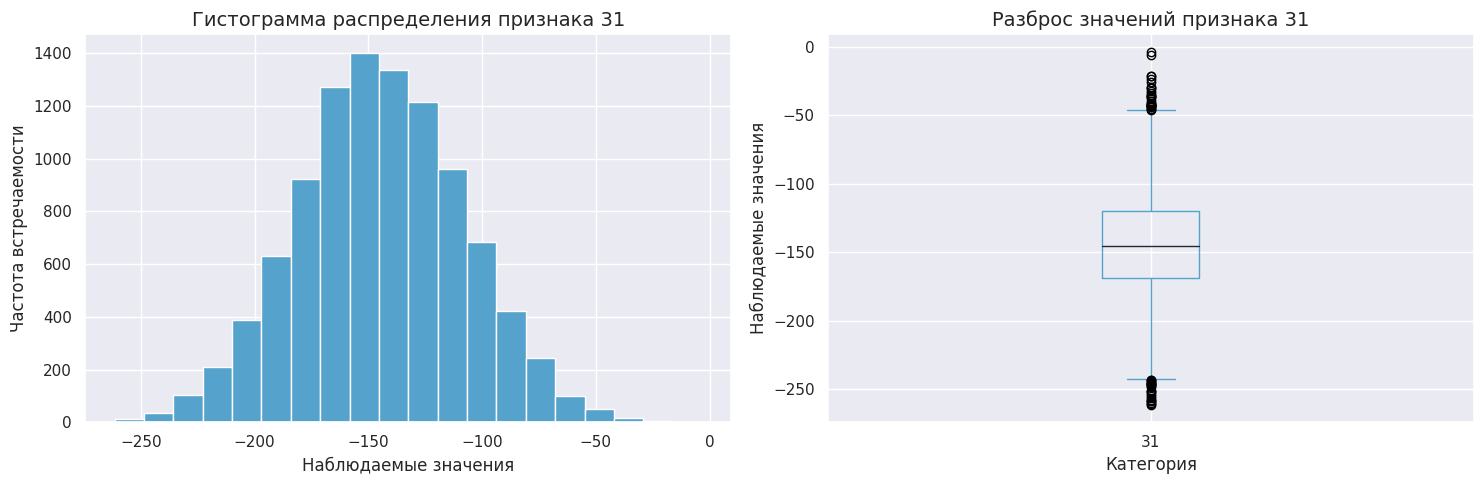

count   9,999.000
mean       89.452
std        28.545
min       -12.177
25%        69.573
50%        89.687
75%       109.346
max       198.147
Name: 32, dtype: float64

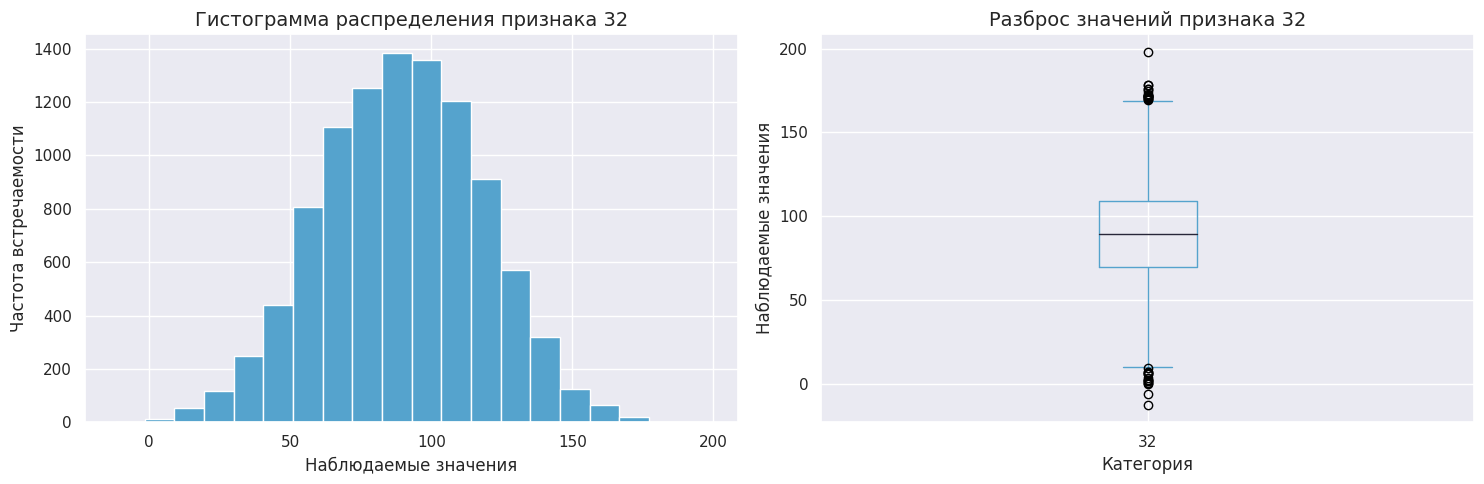

count    9,999.000
mean      -585.523
std        273.877
min     -1,043.160
25%       -803.391
50%       -579.590
75%       -344.268
max       -137.647
Name: 33, dtype: float64

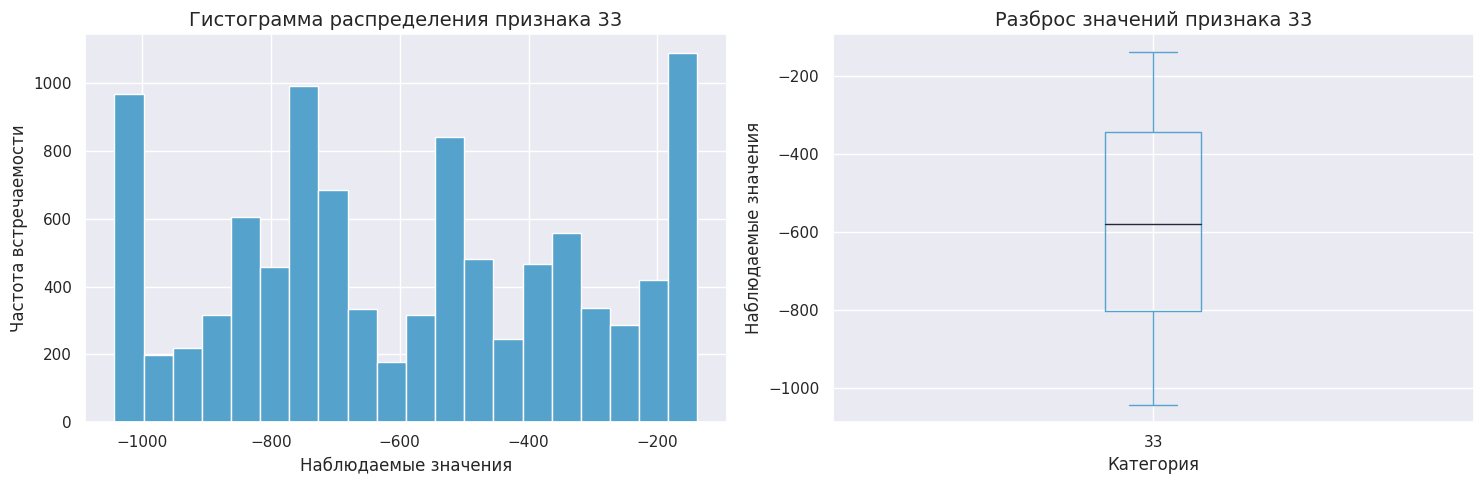

count   9,999.000
mean       36.489
std        39.165
min      -112.780
25%         9.817
50%        36.210
75%        63.508
max       164.170
Name: 34, dtype: float64

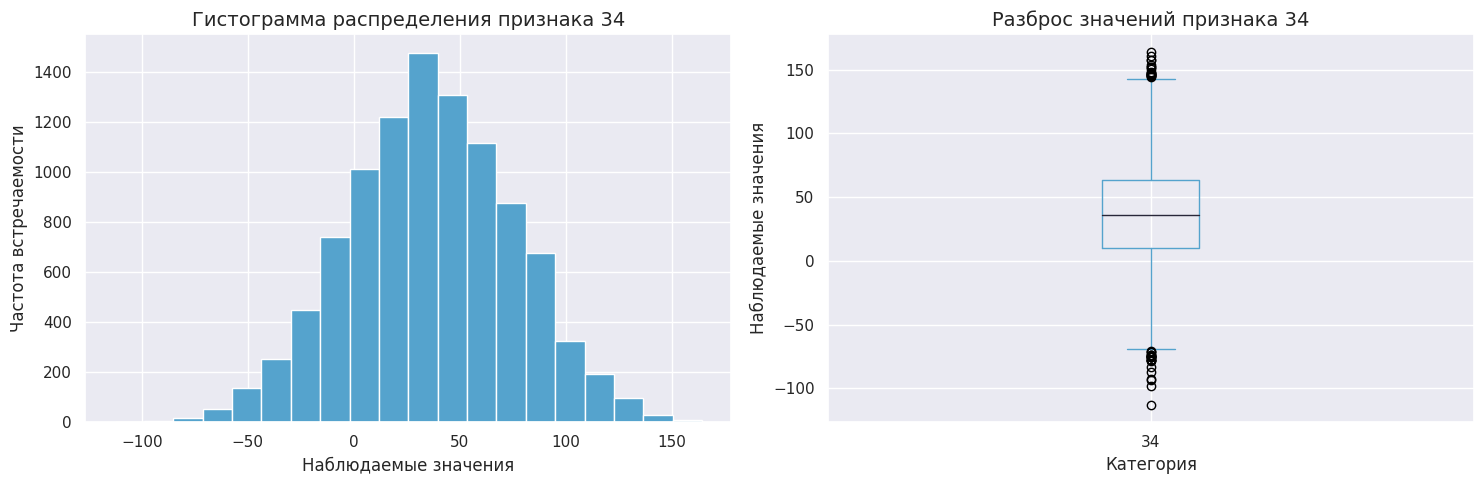

count   9,999.000
mean       73.109
std        19.798
min        -1.459
25%        60.199
50%        72.962
75%        85.952
max       148.037
Name: 35, dtype: float64

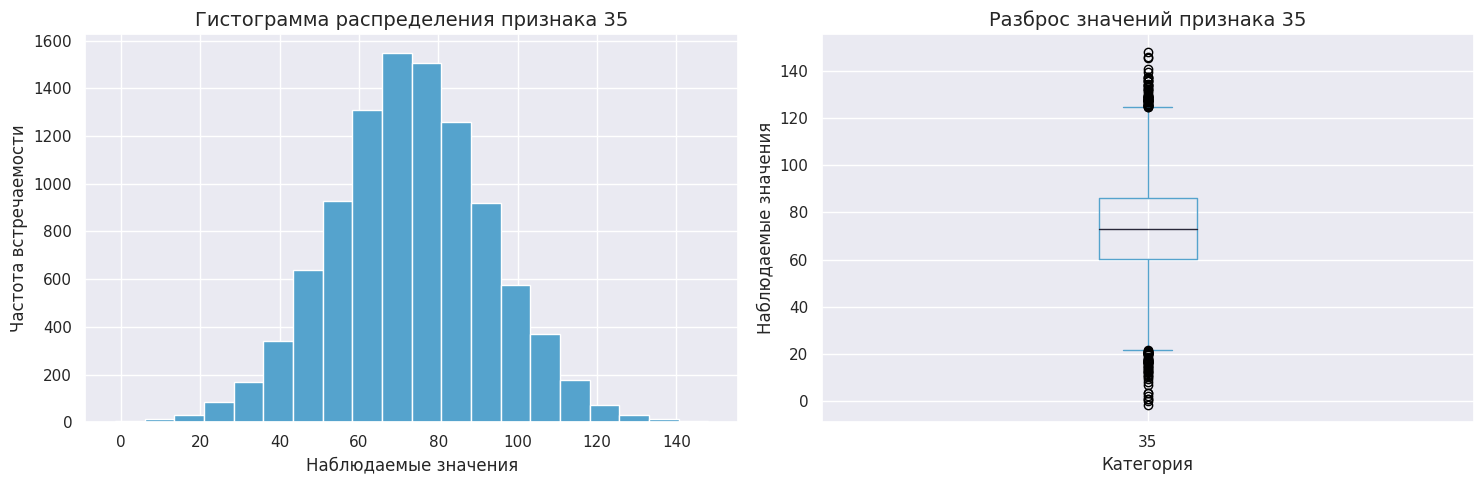

count   9,999.000
mean      -13.967
std        25.525
min      -108.400
25%       -31.081
50%       -13.700
75%         3.643
max        78.403
Name: 36, dtype: float64

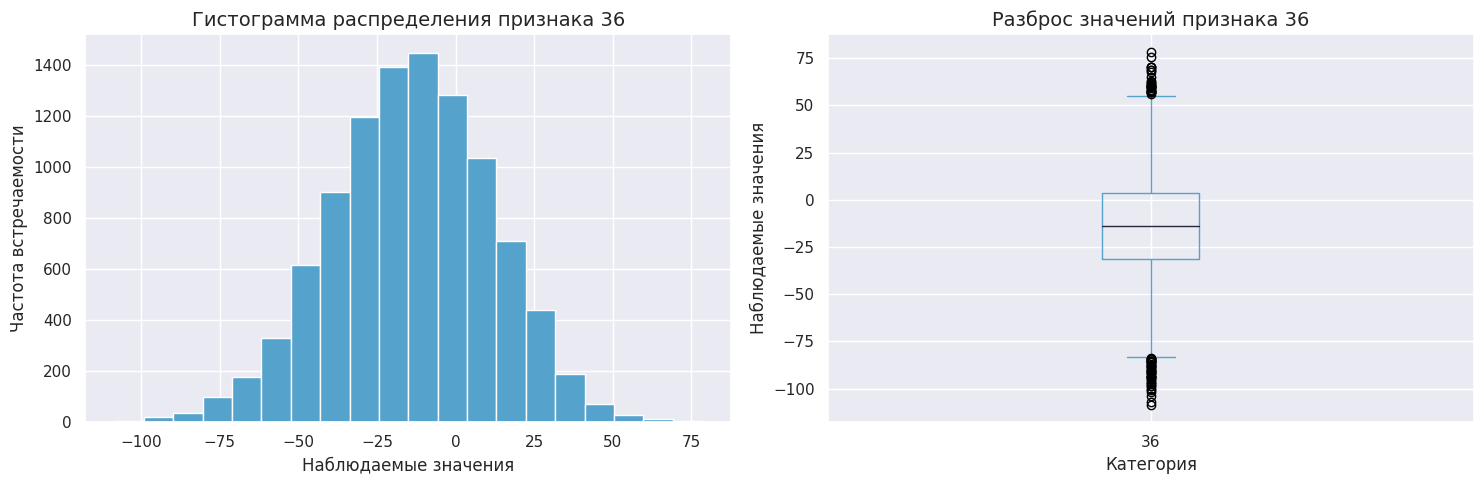

count   9,999.000
mean     -146.521
std        10.250
min      -188.974
25%      -153.293
50%      -146.426
75%      -139.506
max      -108.274
Name: 37, dtype: float64

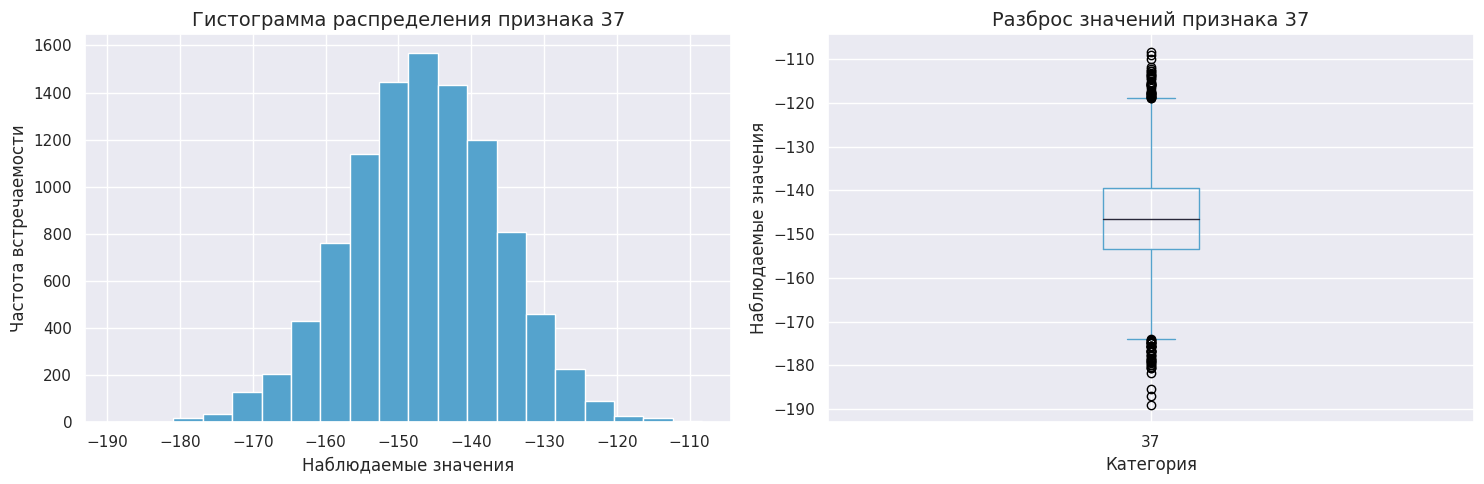

count   9,999.000
mean     -118.313
std        13.653
min      -163.110
25%      -127.523
50%      -118.221
75%      -109.041
max       -68.438
Name: 38, dtype: float64

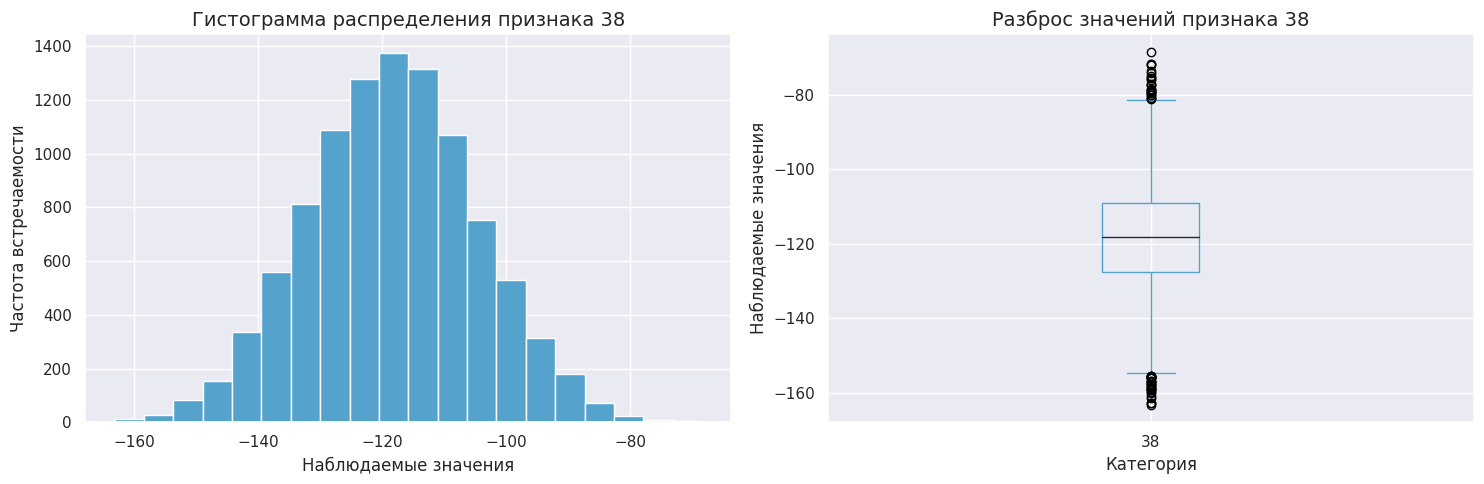

count   9,999.000
mean      -41.206
std        19.885
min      -123.062
25%       -54.565
50%       -41.423
75%       -27.679
max        29.400
Name: 39, dtype: float64

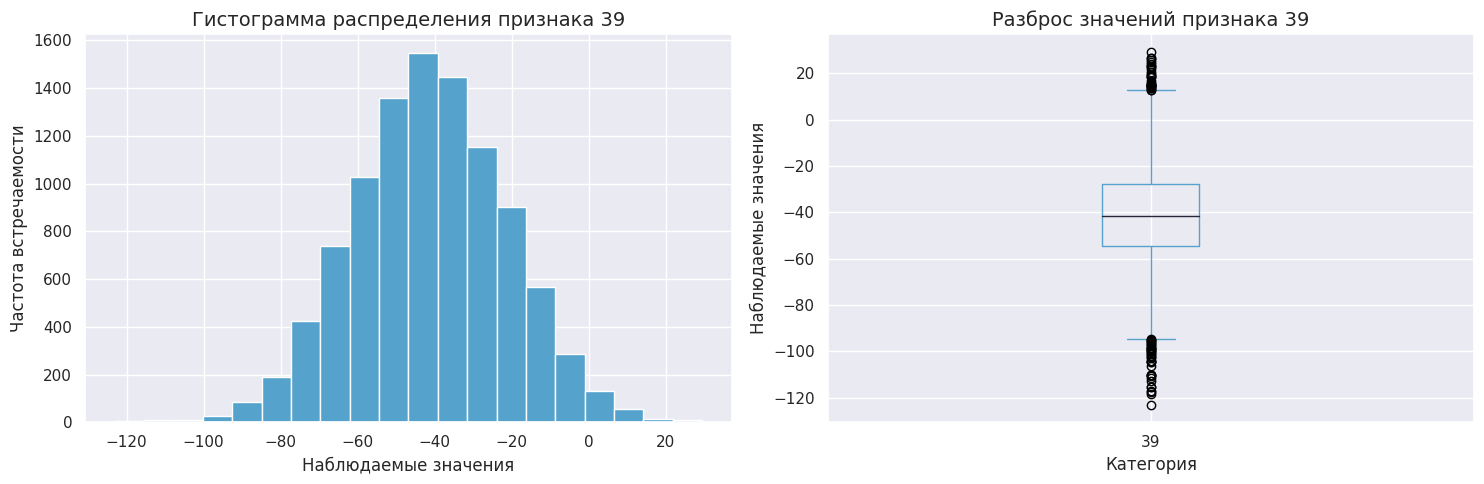

count   9,999.000
mean       -9.363
std         8.330
min       -43.014
25%       -14.942
50%        -9.275
75%        -3.762
max        21.992
Name: 40, dtype: float64

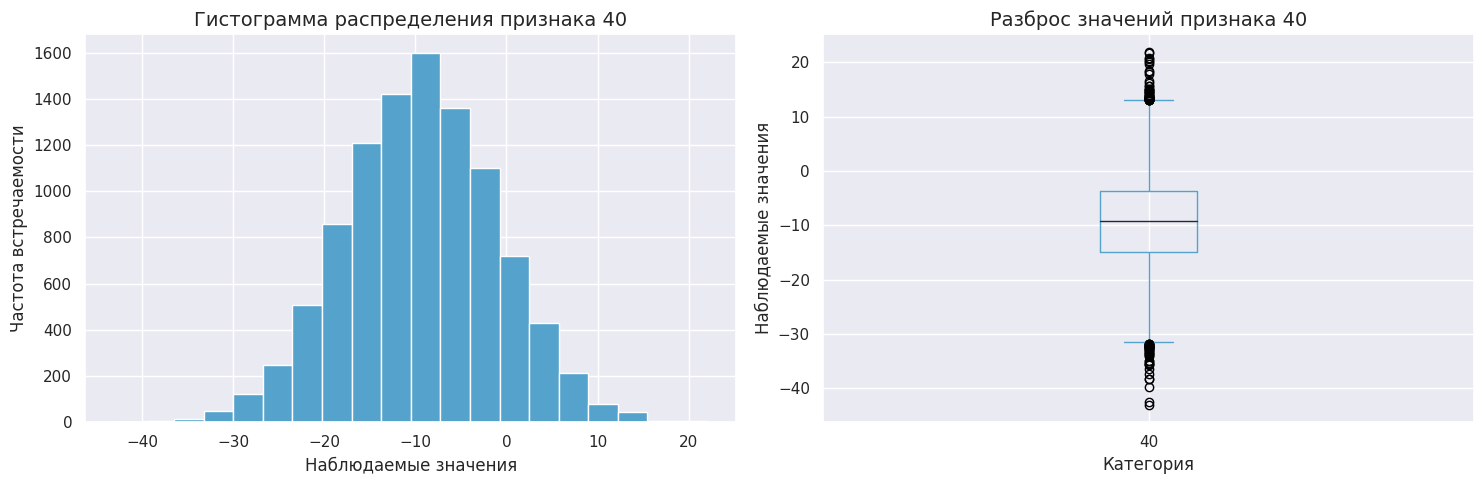

count   9,999.000
mean        4.184
std         5.937
min       -16.524
25%         0.084
50%         4.277
75%         8.267
max        23.780
Name: 41, dtype: float64

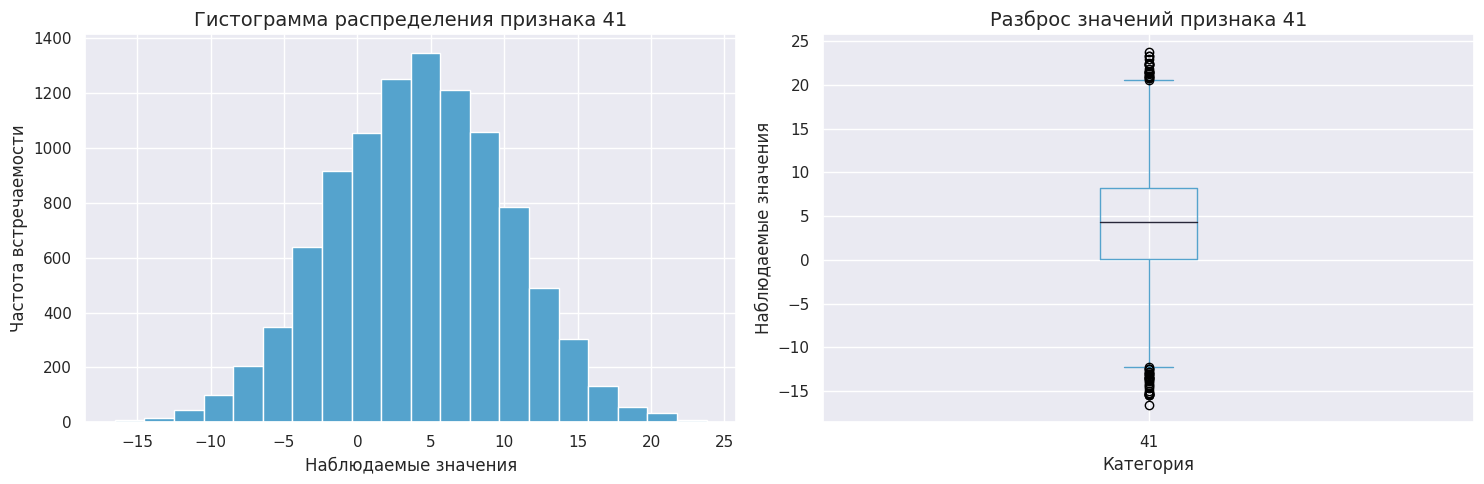

count   9,999.000
mean     -104.603
std        55.887
min      -307.126
25%      -141.943
50%      -105.948
75%       -66.677
max        96.573
Name: 42, dtype: float64

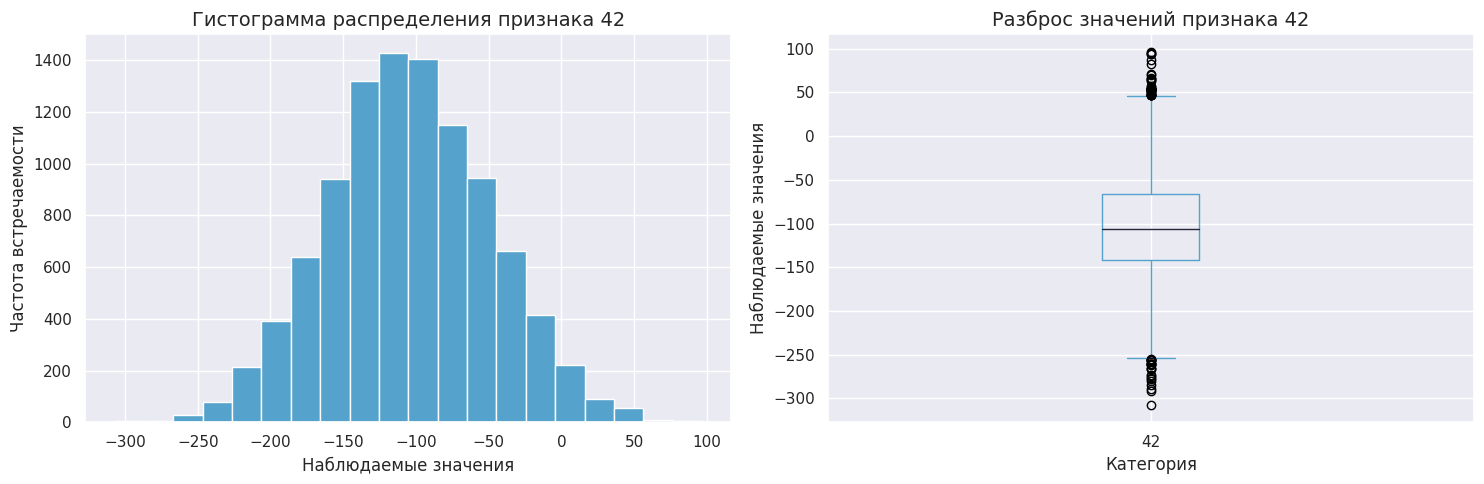

count   9,999.000
mean      122.199
std        48.254
min       -73.530
25%        88.564
50%       122.184
75%       154.548
max       286.051
Name: 43, dtype: float64

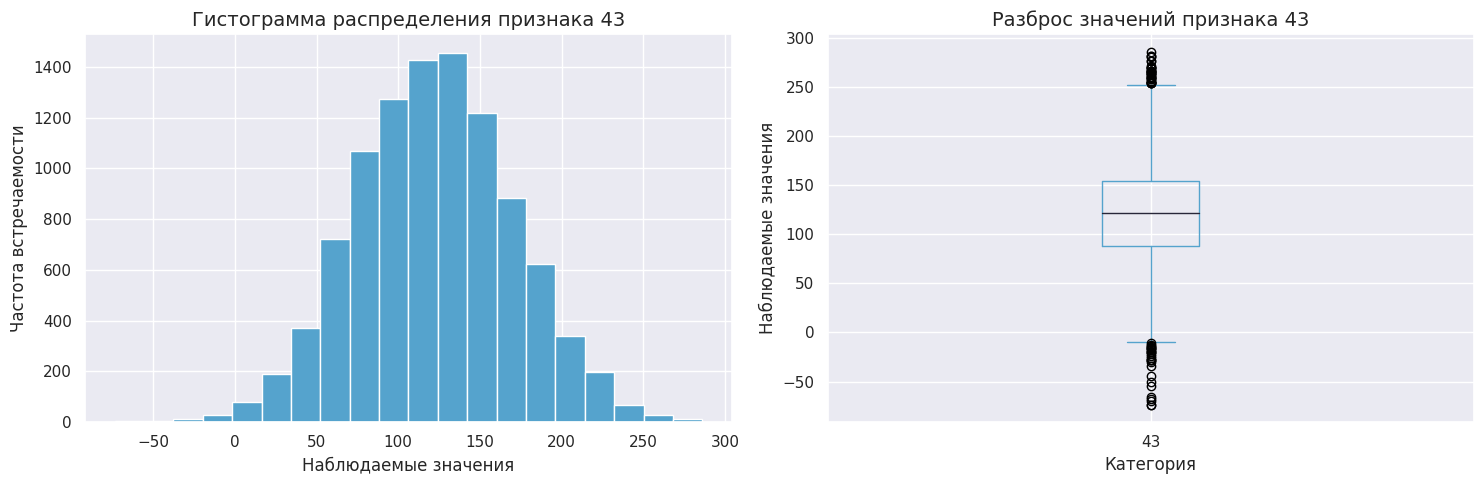

count   9,999.000
mean      -40.441
std        14.846
min       -63.099
25%       -54.118
50%       -39.736
75%       -26.825
max       -16.057
Name: 44, dtype: float64

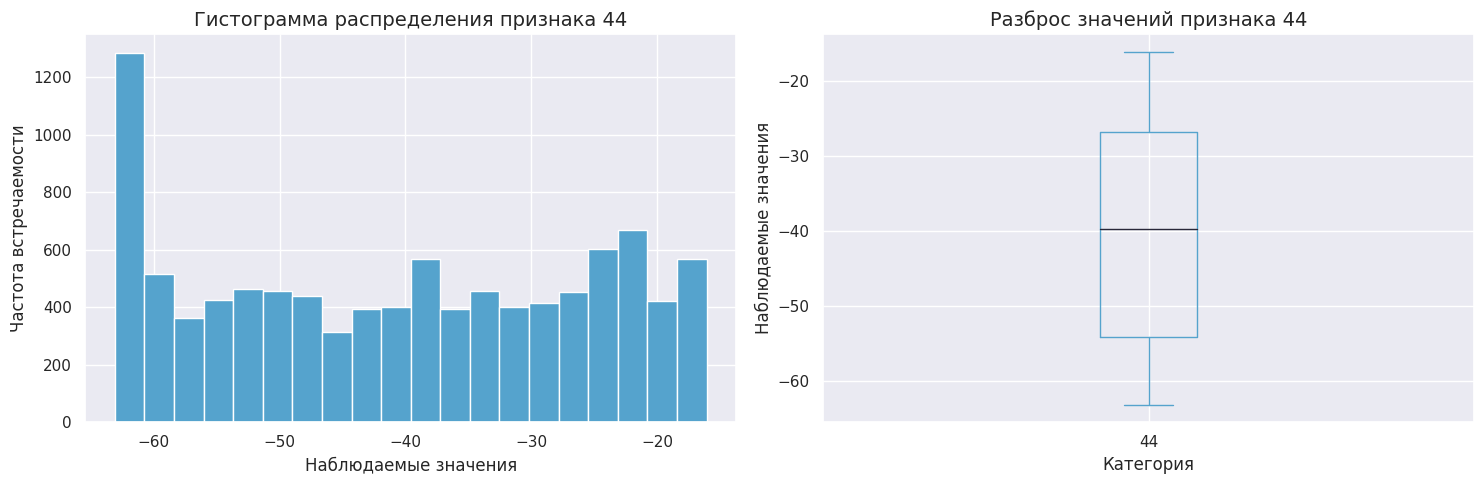

count   9,999.000
mean       59.494
std        30.872
min       -40.430
25%        38.388
50%        59.610
75%        80.943
max       178.600
Name: 45, dtype: float64

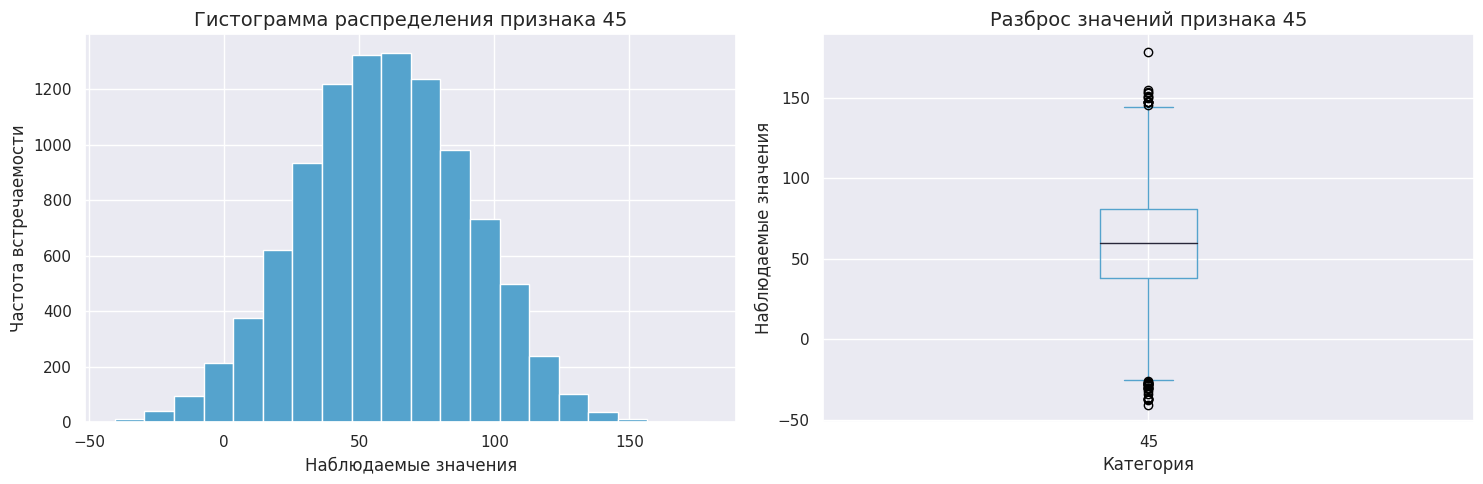

count   9,999.000
mean      -83.718
std        66.195
min      -297.295
25%      -129.638
50%       -84.515
75%       -39.919
max       176.674
Name: 46, dtype: float64

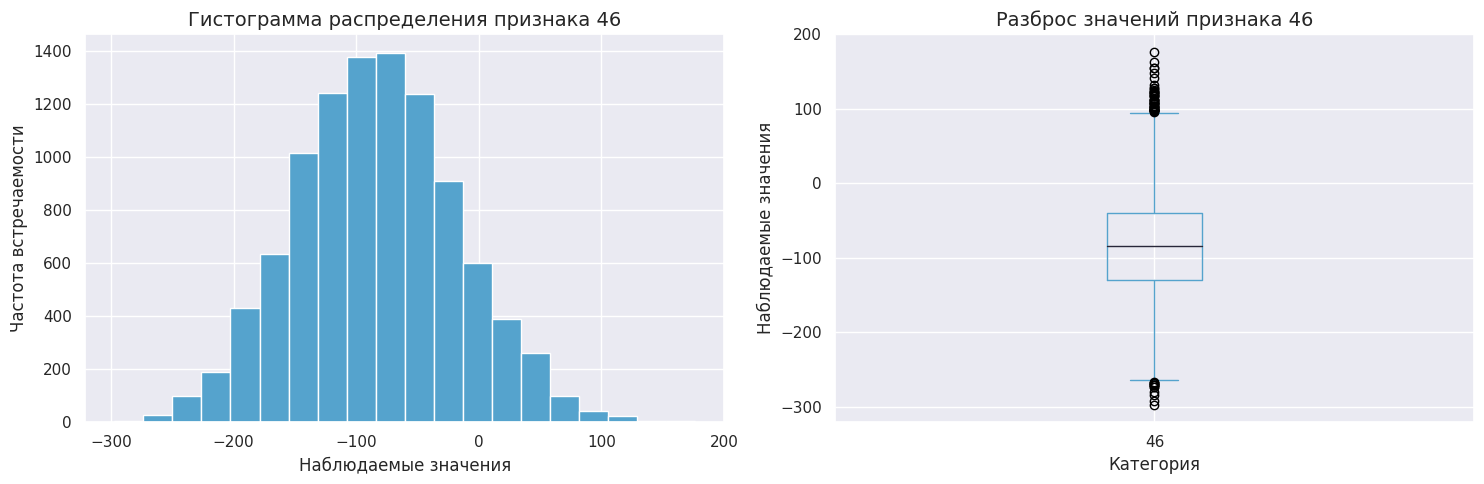

count   9,999.000
mean     -141.372
std        59.716
min      -364.509
25%      -181.844
50%      -141.210
75%      -101.350
max        88.153
Name: 47, dtype: float64

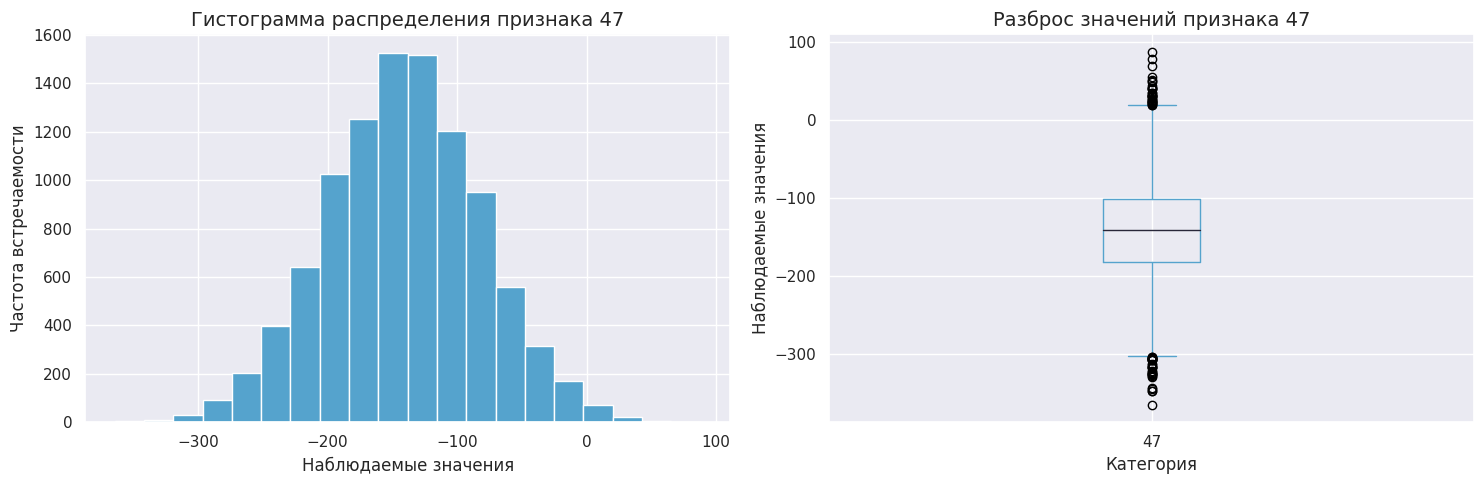

count   9,999.000
mean       45.602
std        45.974
min      -108.377
25%        14.723
50%        44.618
75%        76.465
max       204.514
Name: 48, dtype: float64

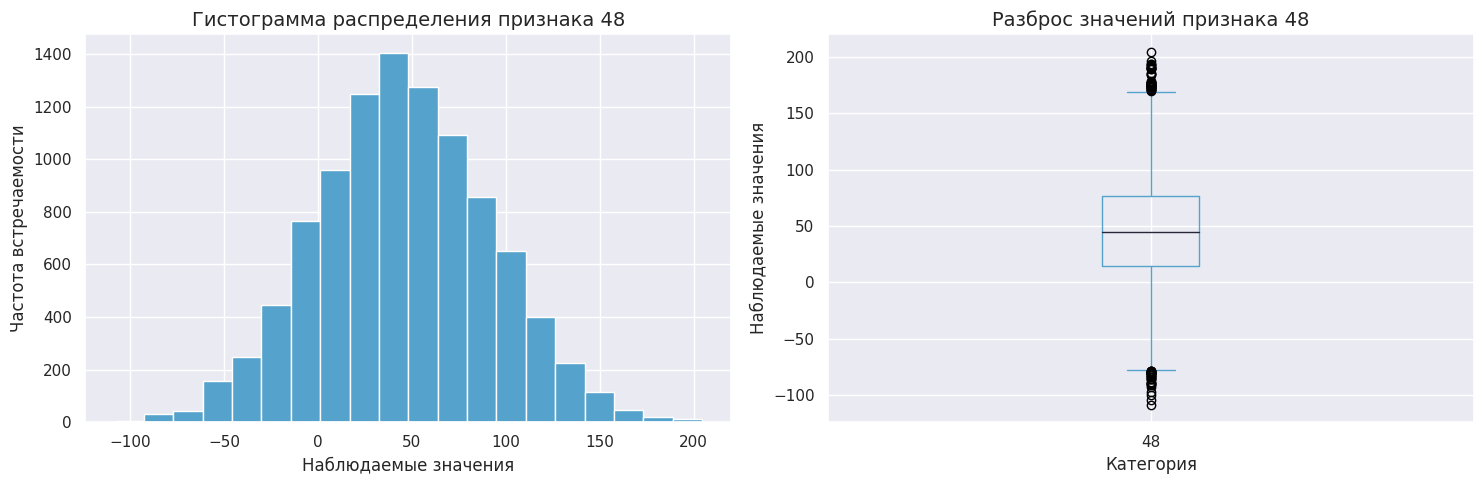

count   9,999.000
mean      -34.662
std        59.540
min      -251.945
25%       -73.511
50%       -32.288
75%         6.798
max       173.932
Name: 49, dtype: float64

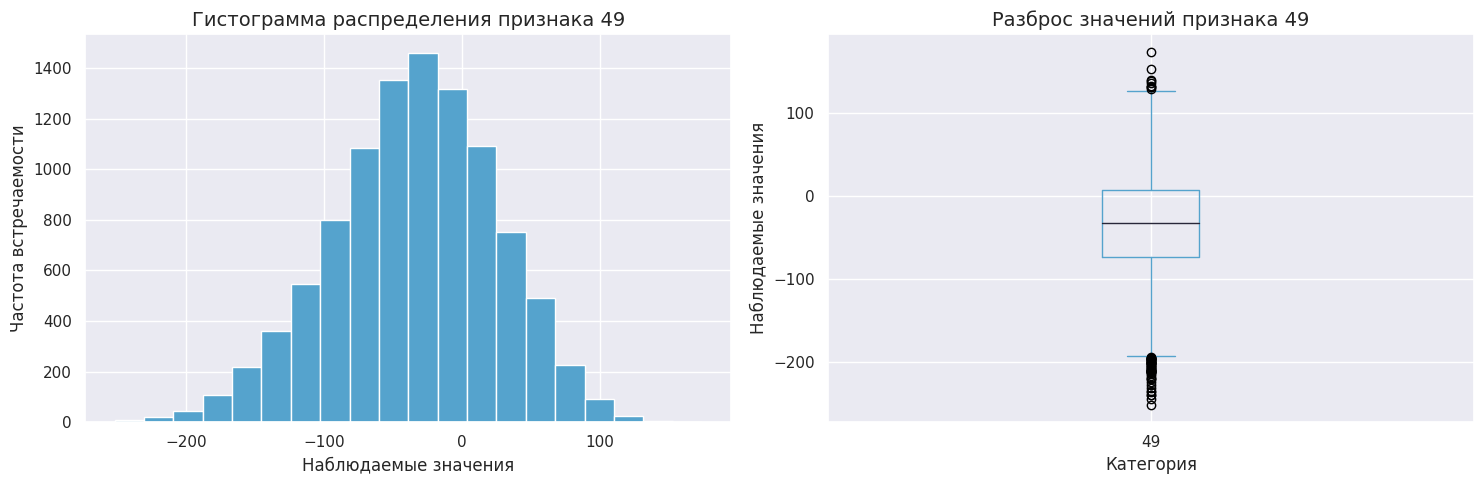

count   9,999.000
mean       30.470
std        60.658
min      -217.258
25%        -9.890
50%        31.698
75%        72.010
max       237.228
Name: 50, dtype: float64

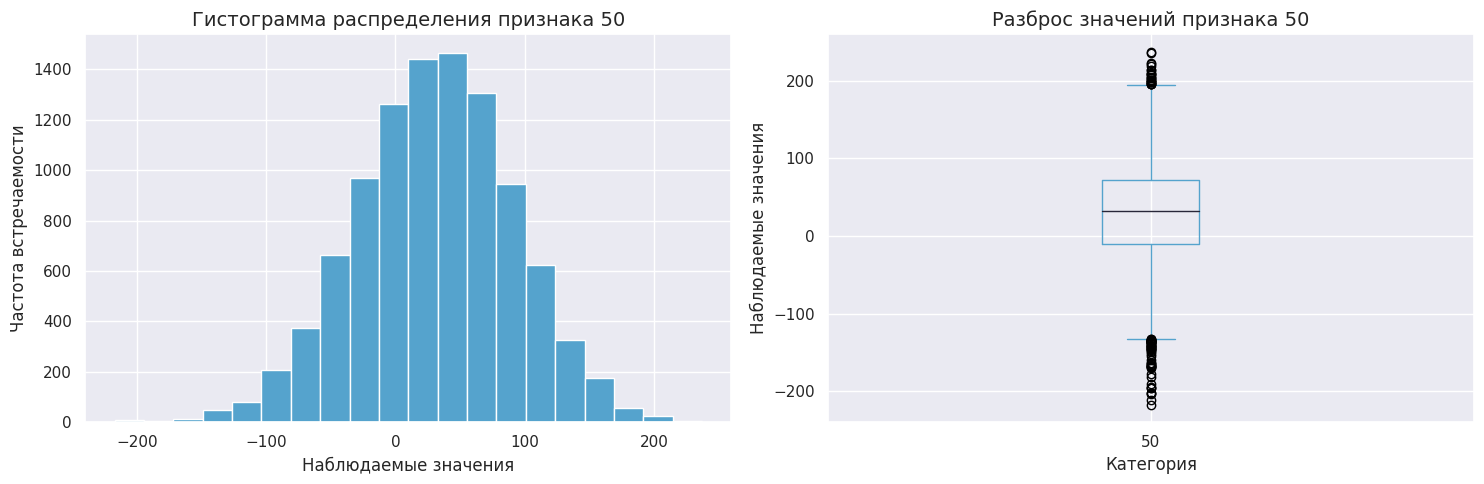

count   9,999.000
mean      -23.010
std        55.722
min      -216.835
25%       -60.959
50%       -23.760
75%        14.877
max       163.437
Name: 51, dtype: float64

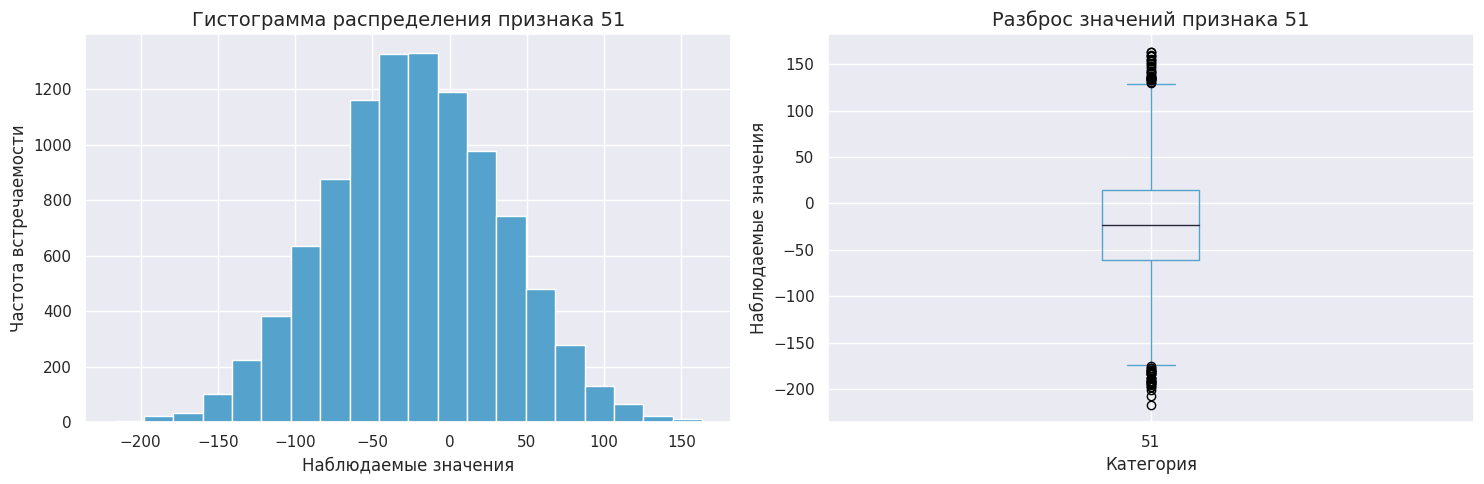

count   9,999.000
mean       67.467
std        13.077
min        21.089
25%        58.273
50%        67.151
75%        76.427
max       115.809
Name: 52, dtype: float64

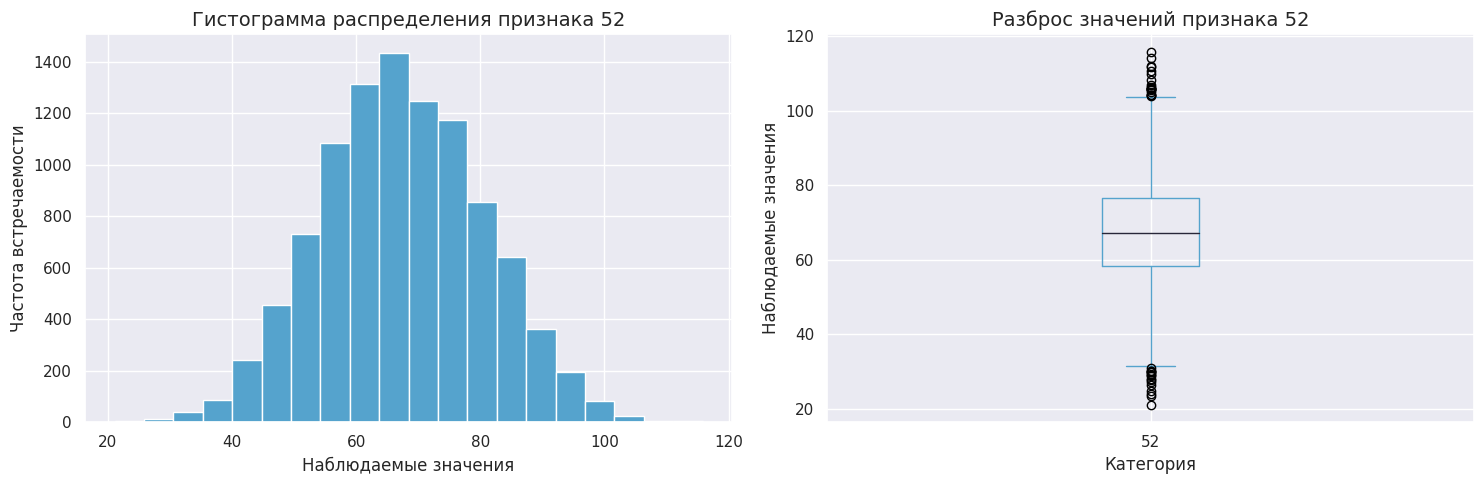

count   9,999.000
mean     -120.630
std        56.004
min      -321.384
25%      -158.783
50%      -120.672
75%       -81.555
max        74.526
Name: 53, dtype: float64

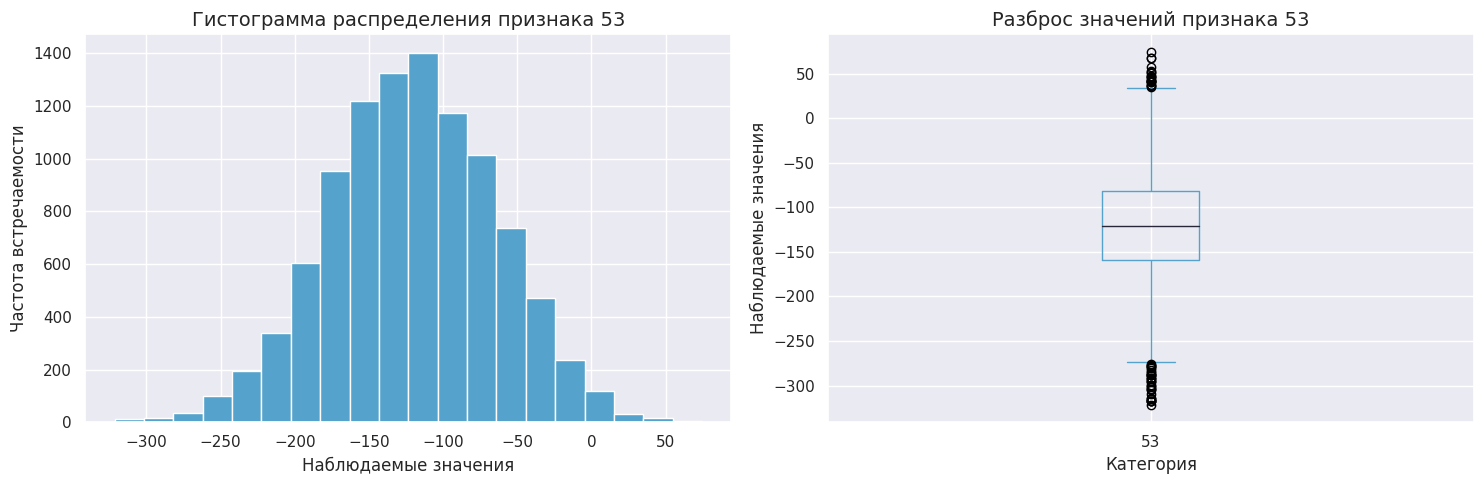

count   9,999.000
mean       88.182
std         4.769
min        70.049
25%        84.935
50%        88.198
75%        91.407
max       107.090
Name: 54, dtype: float64

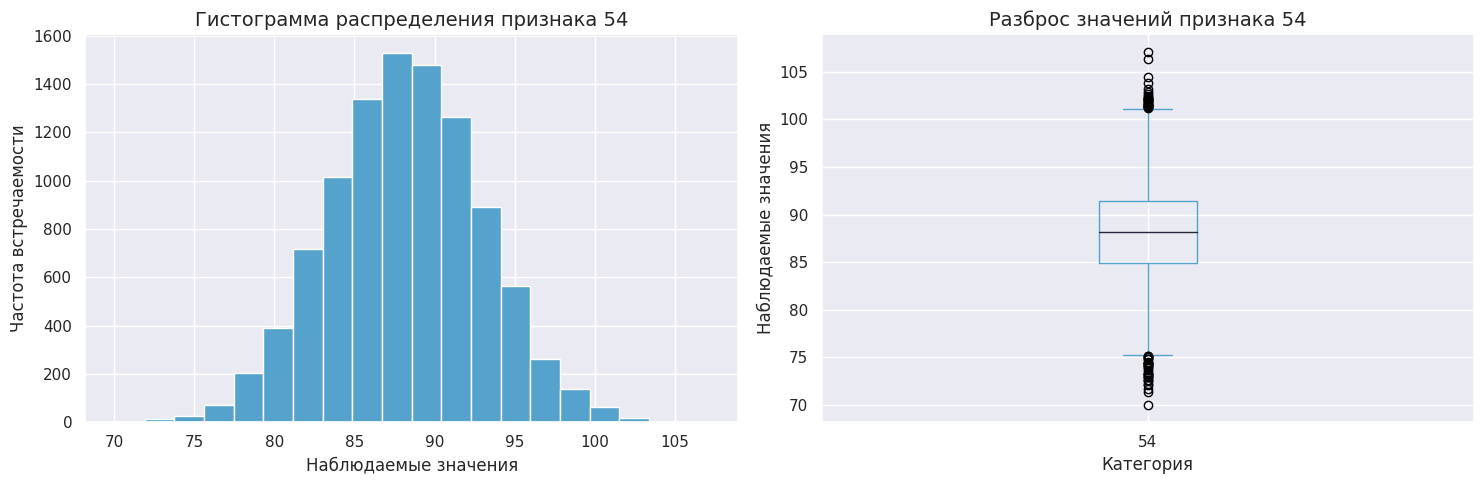

count   9,999.000
mean       69.499
std        12.431
min        22.669
25%        61.168
50%        69.473
75%        78.014
max       112.399
Name: 55, dtype: float64

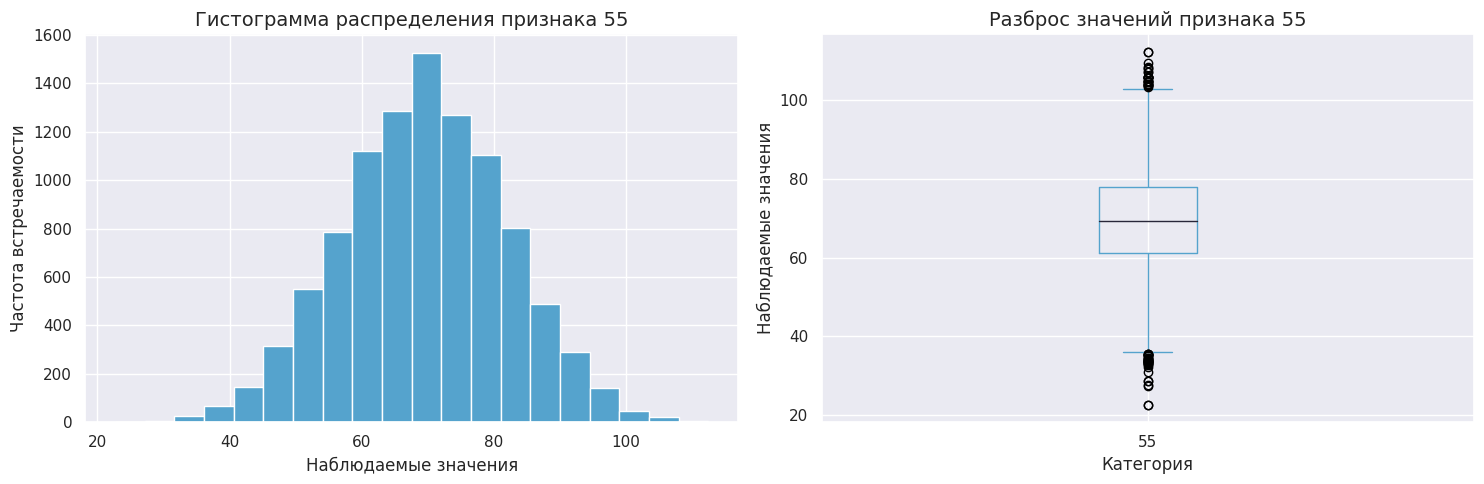

count   9,999.000
mean     -132.557
std         7.979
min      -161.125
25%      -137.984
50%      -132.528
75%      -127.056
max      -102.505
Name: 56, dtype: float64

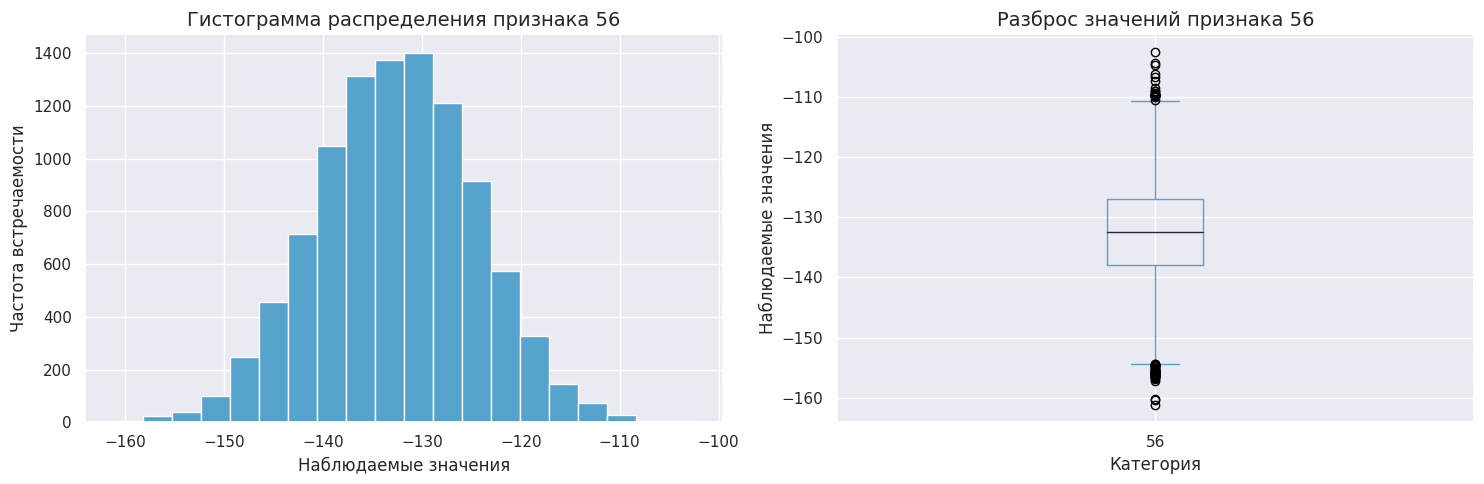

count   9,999.000
mean       14.618
std        49.141
min      -134.082
25%       -19.463
50%        14.172
75%        47.460
max       187.687
Name: 57, dtype: float64

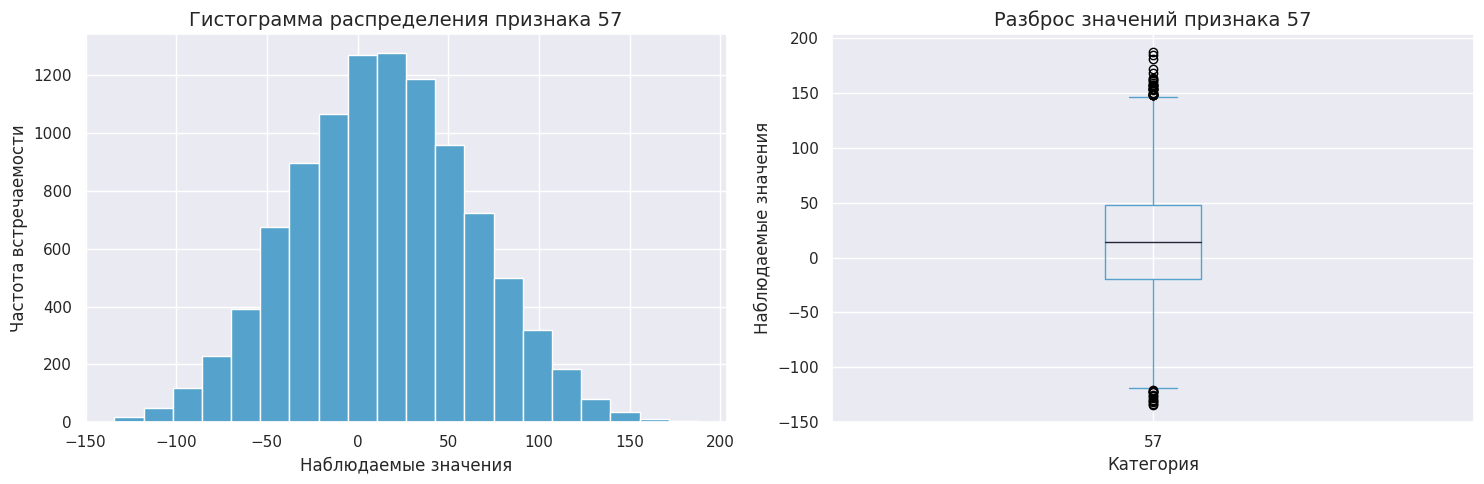

count   9,999.000
mean     -119.978
std        55.662
min      -318.880
25%      -158.366
50%      -120.550
75%       -81.602
max        78.903
Name: 58, dtype: float64

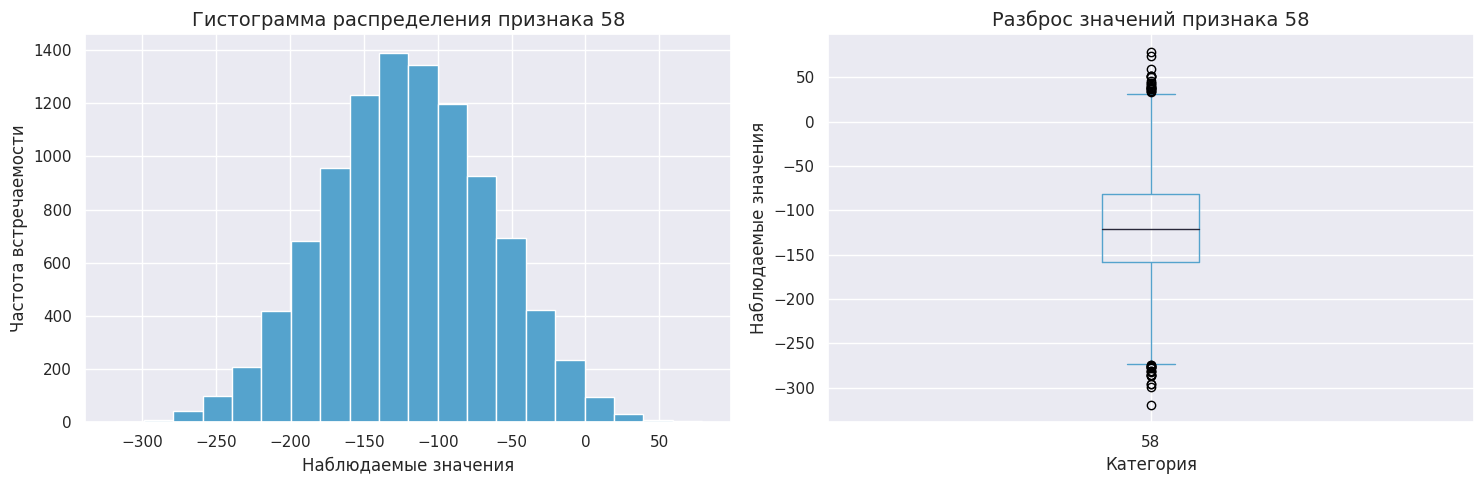

count   9,999.000
mean     -314.115
std       209.603
min      -681.033
25%      -495.741
50%      -309.590
75%      -132.403
max        48.657
Name: 59, dtype: float64

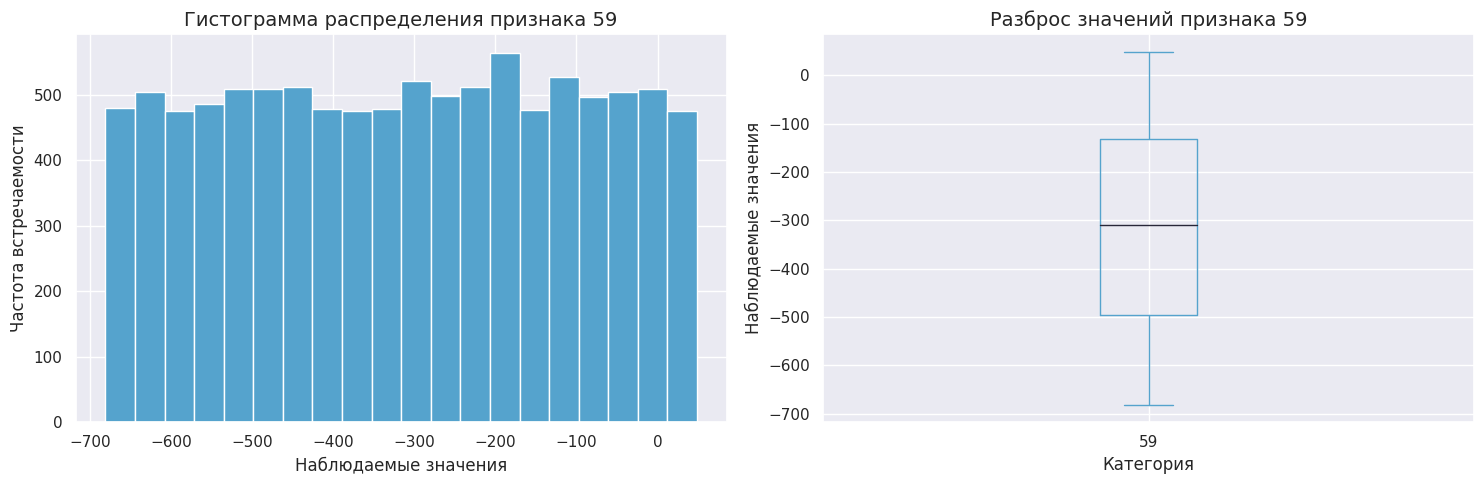

count   9,999.000
mean      -66.975
std        64.483
min      -301.453
25%      -111.154
50%       -66.140
75%       -22.475
max       175.577
Name: 60, dtype: float64

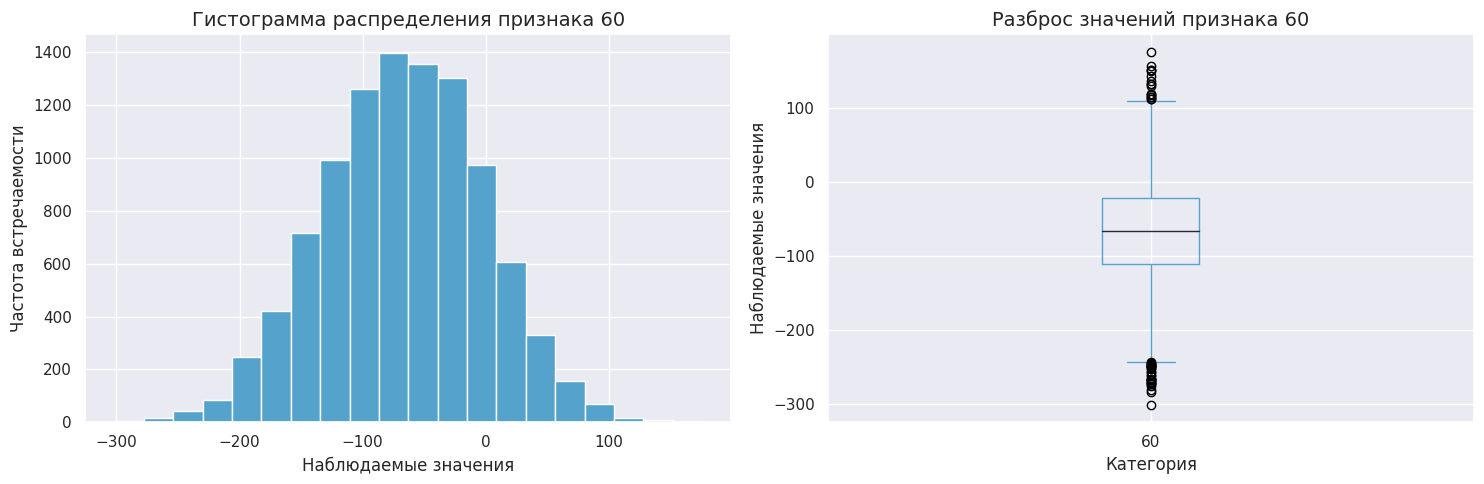

count   9,999.000
mean     -130.516
std         9.370
min      -167.331
25%      -136.764
50%      -130.572
75%      -124.236
max       -98.809
Name: 61, dtype: float64

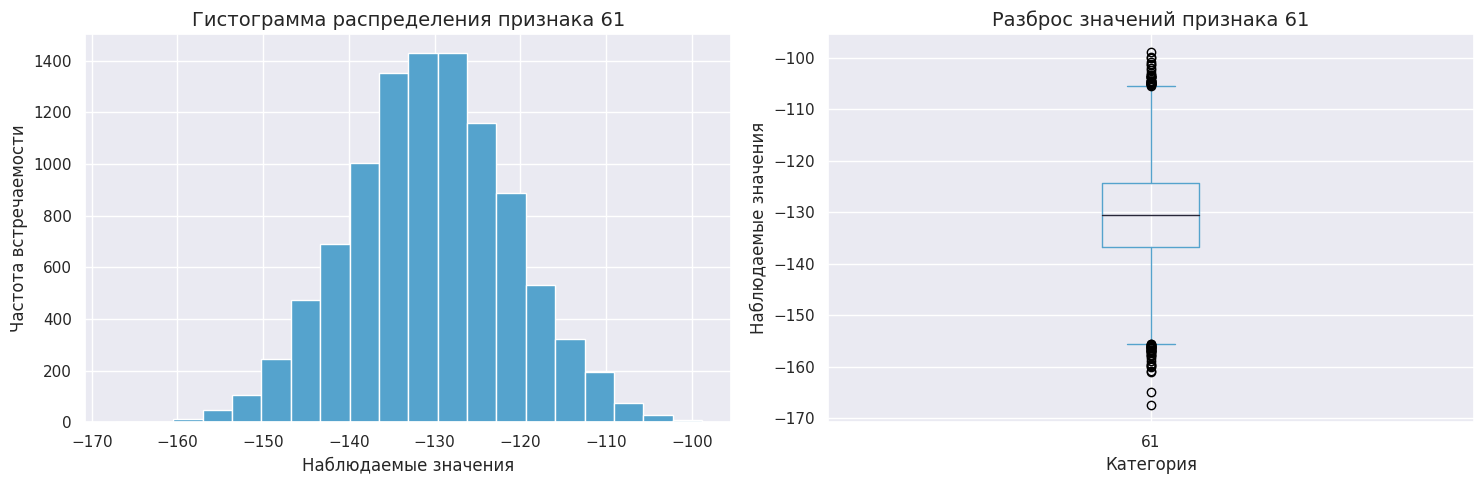

count   9,999.000
mean      -81.374
std        30.629
min      -191.308
25%      -101.776
50%       -81.767
75%       -60.619
max        20.979
Name: 62, dtype: float64

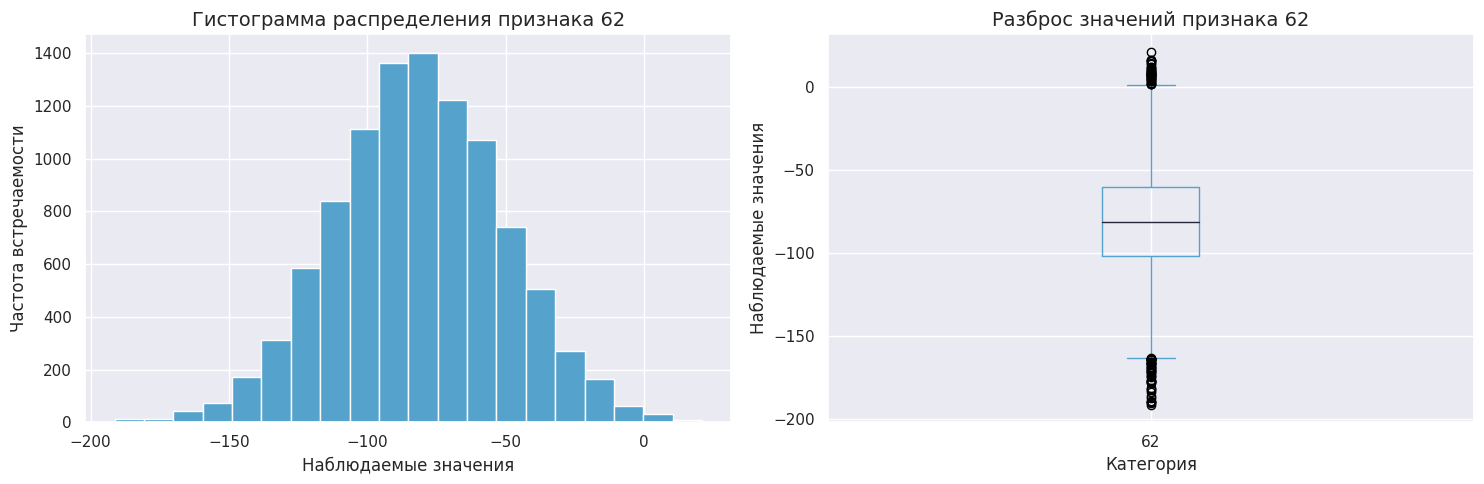

count   9,999.000
mean       37.137
std        25.392
min       -60.515
25%        20.369
50%        36.944
75%        53.902
max       137.559
Name: 63, dtype: float64

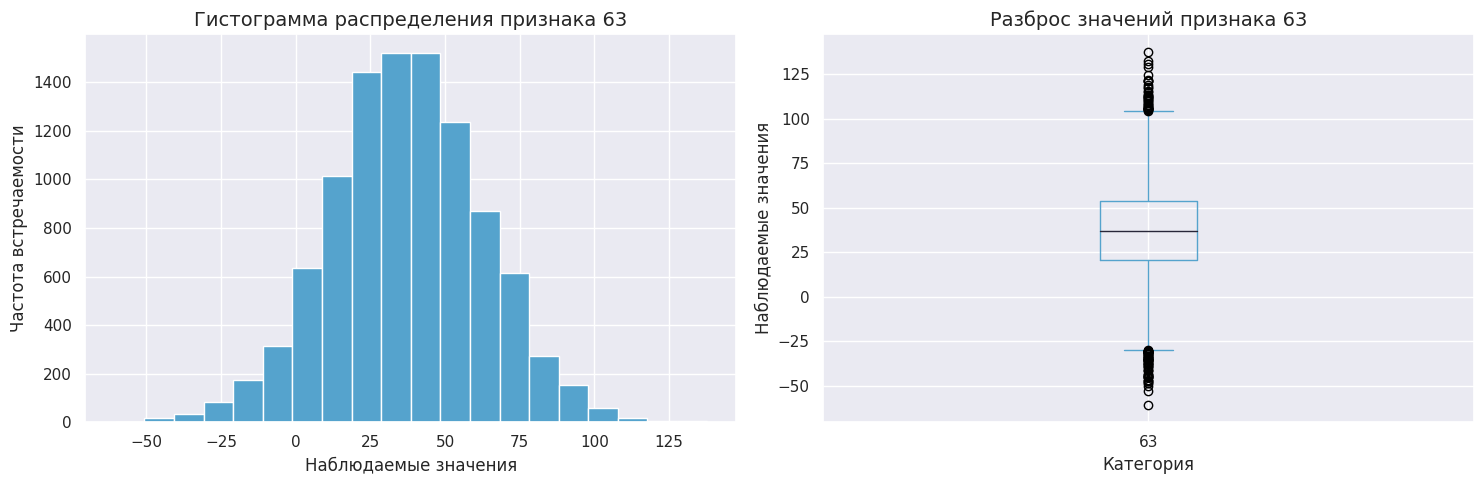

count   9,999.000
mean     -152.474
std        41.110
min      -306.838
25%      -179.337
50%      -151.395
75%      -124.285
max       -18.955
Name: 64, dtype: float64

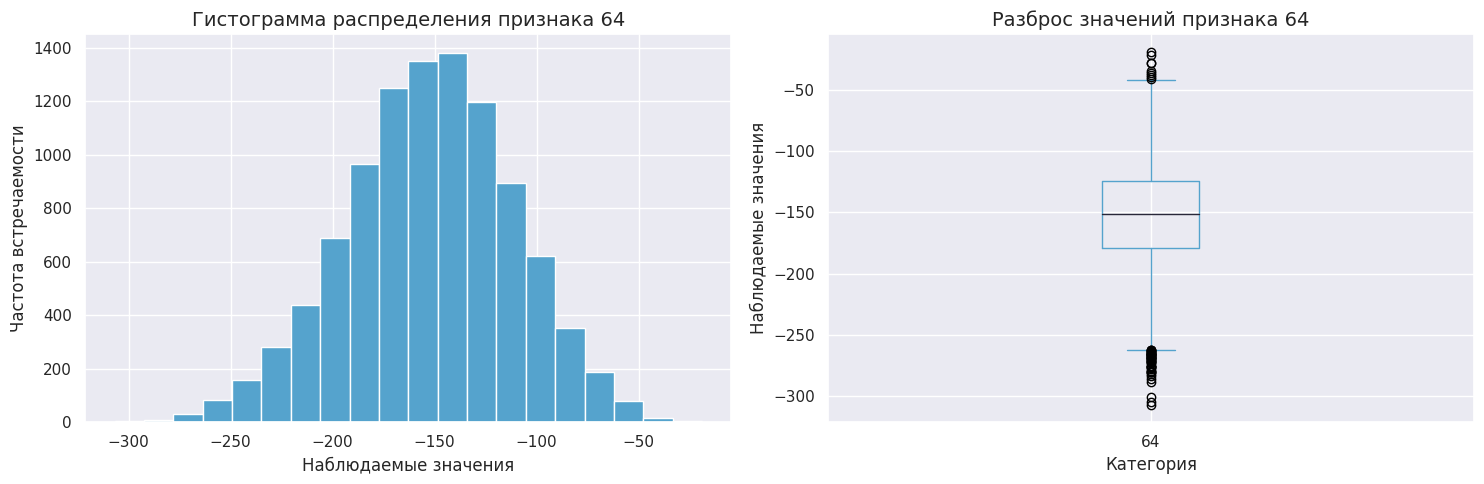

count   9,999.000
mean       16.534
std        98.956
min      -157.579
25%       -67.498
50%        16.008
75%       101.774
max       185.056
Name: 65, dtype: float64

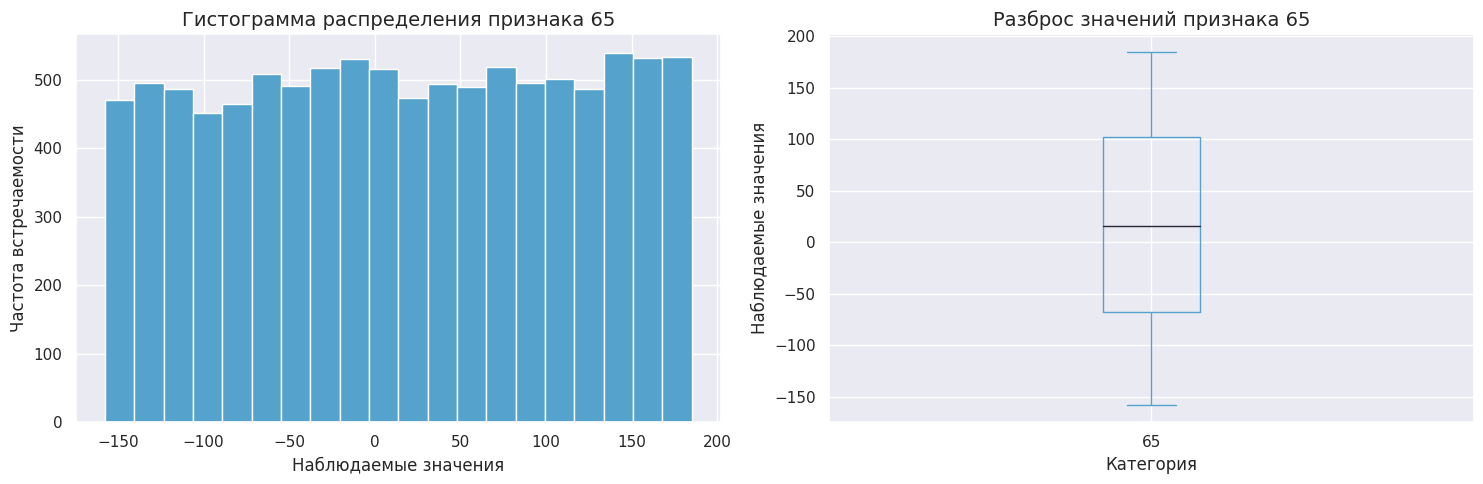

count   9,999.000
mean       67.804
std         1.876
min        61.340
25%        66.535
50%        67.820
75%        69.087
max        74.122
Name: 66, dtype: float64

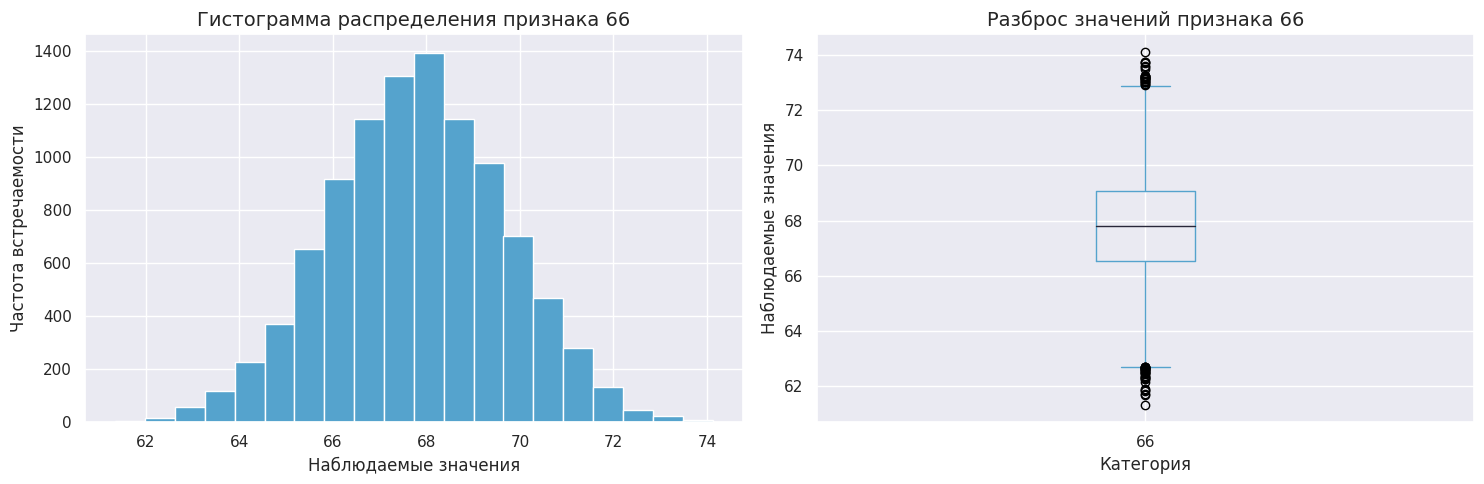

count   9,999.000
mean       23.750
std        54.838
min      -165.361
25%       -12.361
50%        24.146
75%        59.302
max       236.385
Name: 67, dtype: float64

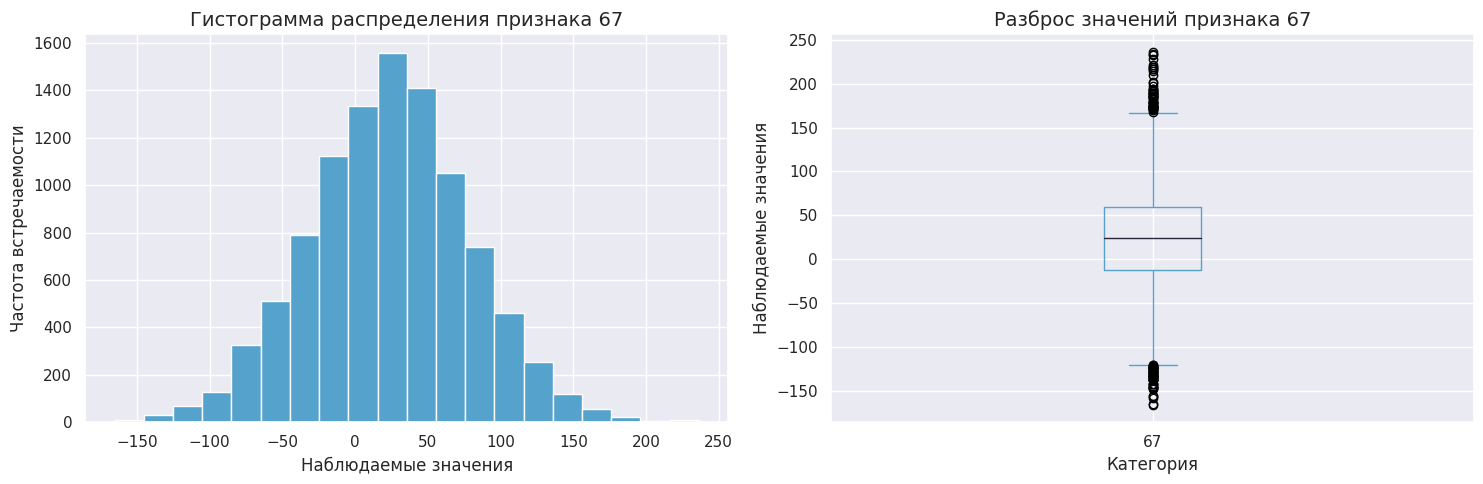

count   9,999.000
mean       73.255
std        61.459
min      -127.018
25%        32.034
50%        73.178
75%       113.039
max       304.392
Name: 68, dtype: float64

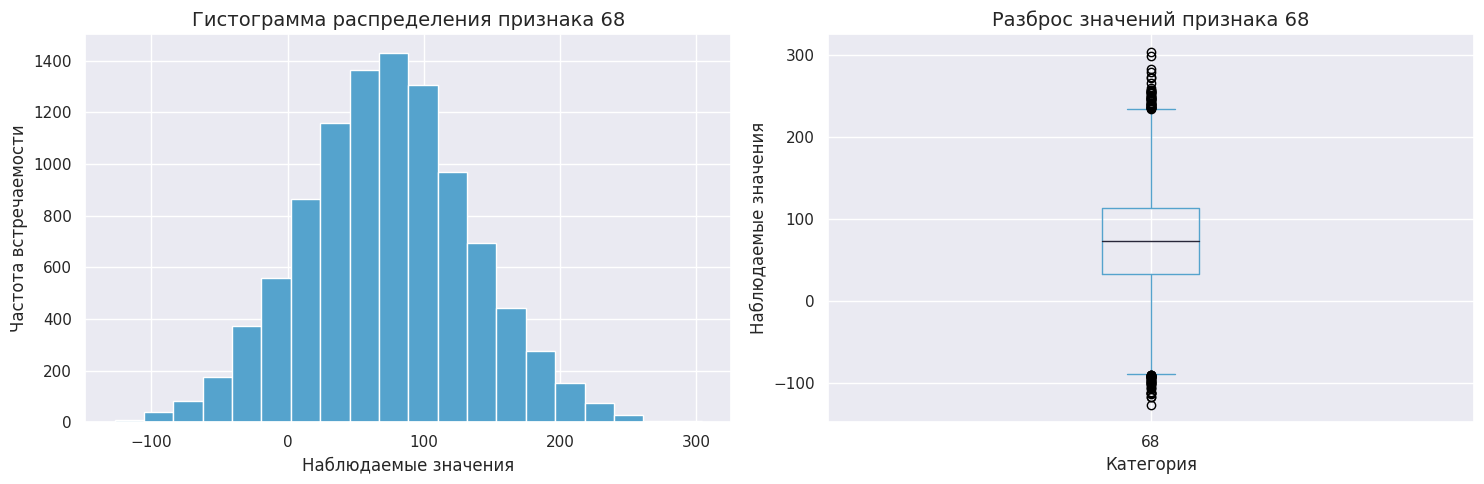

count   9,999.000
mean      115.411
std        21.641
min        34.696
25%       100.510
50%       115.813
75%       130.226
max       187.621
Name: 69, dtype: float64

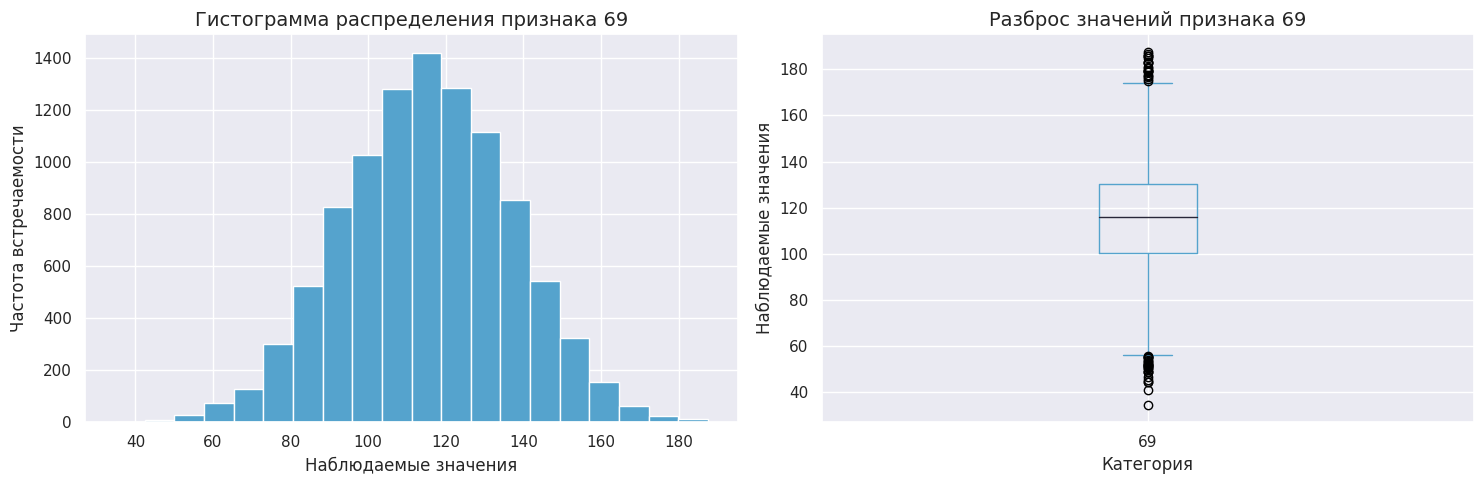

count    9,999.000
mean      -708.825
std        405.687
min     -1,297.872
25%     -1,074.465
50%       -800.297
75%       -362.487
max         97.788
Name: 70, dtype: float64

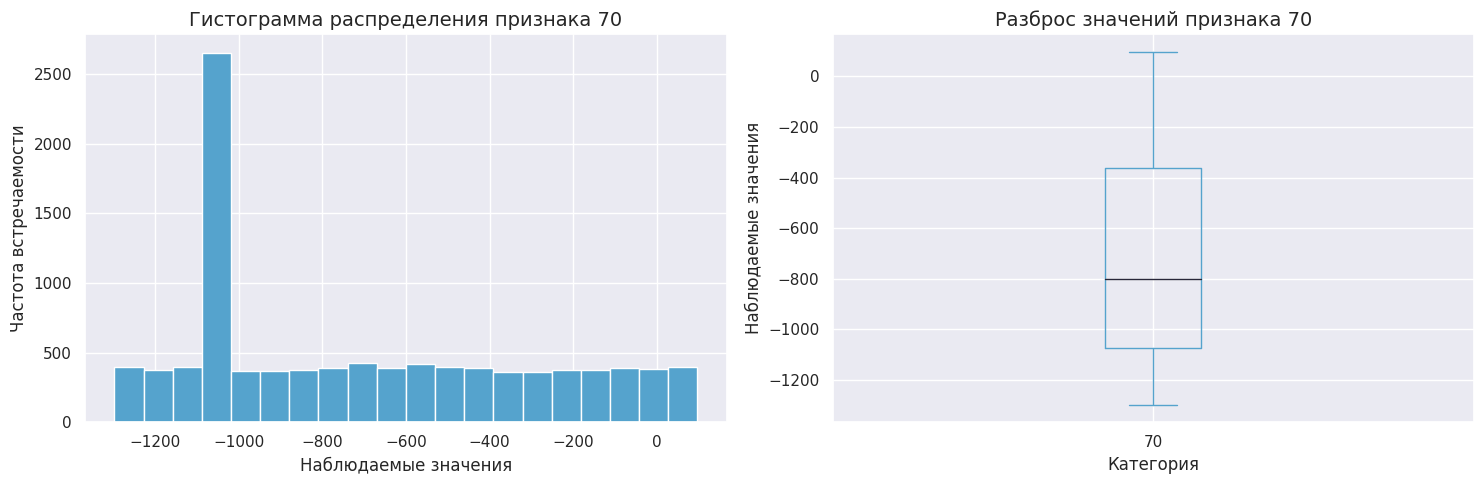

count   9,999.000
mean      -48.325
std        40.900
min      -208.277
25%       -75.271
50%       -49.027
75%       -21.845
max       111.832
Name: 71, dtype: float64

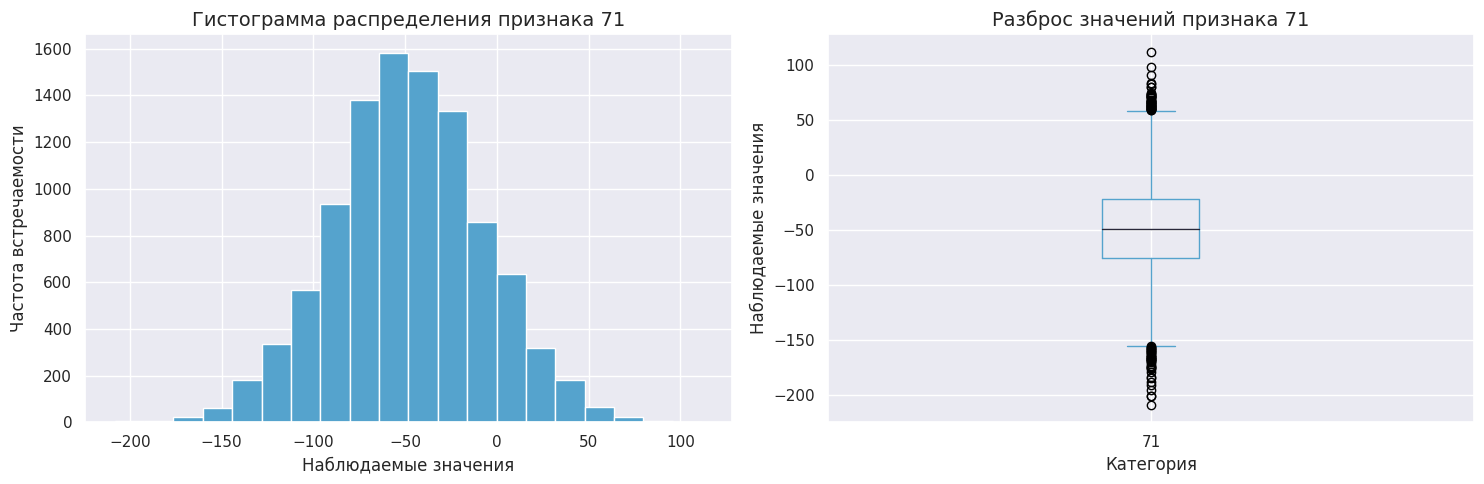

In [112]:
for feature in product_train.columns[:-1]:
    visualize_feature_distribution(product_train, feature)

Большинство признаков имеют нормальное распределение с минимальным кол-вом выбросов на коробчатой гистограмме.

При этом имеются признаки с ненормальным (дискретным, равномерным) распределением: 65, 59,  33.

И признаки, в которых одно значение втречается значительно чаще всех остальных: 70, 44, 25, 21, 6.

Изучим кол-во уникальных значений признаков и выведем метод `describe()` для сэмпла всего датафрейма, чтобы  сравнить масштаб данных.

In [113]:
# Рассчет процента уникальных значений в каждом столбце и отбор столбцов
unique_percentages = {}
total_rows = len(product_train)
selected_columns = []

for column in product_train.columns:
    unique_values_count = product_train[column].nunique()
    unique_percentage = (unique_values_count / total_rows) * 100
    unique_percentages[column] = unique_percentage

    if unique_percentage < 20:
        selected_columns.append(column)

print("\nСтолбцы с менее чем 20% уникальных значений:")
for column in selected_columns:
    print(column)


Столбцы с менее чем 20% уникальных значений:
25
33


**Вывод:**

Признаки 25 и 33 содержат менее 20% уникальных значений.

Признак теряет свою информативность, если показывает одинаковые свойства у 80% товаров, удалим их из датафреймов на этапе отбора признаков для обучения модели.

In [114]:
# визучим масштаб данных
product_train.sample(frac=0.1).describe()

0         1         2         3         4         5         6  \
count 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000   
mean    -85.020     7.670   -44.328  -146.010   110.862   -72.800  -453.589   
std      25.429     5.082    38.212    19.756    45.639    27.878   280.510   
min    -153.745    -6.994  -171.254  -201.906   -33.627  -151.056  -789.932   
25%    -103.459     4.148   -69.031  -159.123    80.356   -91.413  -759.626   
50%     -84.852     7.562   -43.918  -146.605   109.671   -73.279  -522.416   
75%     -66.913    11.135   -16.812  -132.556   140.174   -53.642  -226.275   
max      -2.350    23.194    70.071   -80.377   275.081    13.490   108.654   

              7         8         9        10        11        12        13  \
count 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000   
mean     21.189   123.308   124.060  -139.908   -68.989   -40.988     5.700   
std      67.856     6.465    64.070    39.790    51.832    41.813    38.254   
min    -250.681   103.140   -85.766  -287.203  -299.734  -186.011  -101.780   
25%     -21.377   118.880    78.950  -165.570  -103.252   -68.119   -20.249   
50%      20.355   123.363   123.168  -138.184   -68.525   -38.556     5.583   
75%      68.363   127.646   167.682  -113.122   -33.556   -12.771    30.554   
max     227.608   145.038   295.485   -38.085    99.637    81.451   125.562   

             14        15        16        17        18        19        20  \
count 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000   
mean    147.961   -24.268    -2.148   -16.239  -139.276   -79.198   -97.051   
std      33.267    12.960    20.350    53.565    48.454     0.786    27.680   
min      25.673   -66.183   -63.716  -195.639  -286.531   -81.604  -228.986   
25%     126.634   -32.722   -15.030   -53.042  -170.037   -79.689  -114.600   
50%     149.018   -24.698    -2.033   -13.352  -139.815   -79.190   -96.095   
75%     170.094   -15.661    10.387    20.941  -109.189   -78.651   -78.621   
max     278.276    14.375    64.781   149.013    50.731   -77.148   -12.953   

             21        22        23        24        25        26        27  \
count 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000   
mean  1,293.728    -0.217    56.940    23.824   739.420   -64.433    16.251   
std     386.517    49.600    33.856    41.162   190.709    63.412     4.914   
min     141.881  -171.390   -32.543  -118.211   -53.593  -289.375     3.127   
25%   1,250.424   -34.299    34.327    -4.119   813.770  -106.829    12.830   
50%   1,507.231    -0.601    57.784    23.124   813.770   -64.344    16.316   
75%   1,507.231    31.618    77.581    53.426   813.770   -22.935    19.443   
max   1,555.080   167.167   160.621   148.529   841.929   189.972    31.126   

             28        29        30        31        32         33        34  \
count 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000  1,000.000 1,000.000   
mean    -85.980   152.456   -13.644  -146.872    88.459   -577.037    36.219   
std      49.359    10.368    30.280    37.341    27.980    269.206    38.929   
min    -260.600   120.547  -115.408  -261.523    -5.888 -1,040.372   -77.795   
25%    -120.163   145.538   -34.834  -172.075    69.513   -780.449    10.080   
50%     -88.559   152.410   -12.384  -147.137    88.435   -547.946    35.473   
75%     -52.492   158.974     6.713  -121.852   108.019   -341.782    62.279   
max      56.295   184.936    63.613   -20.929   164.299   -137.647   153.617   

             35        36        37        38        39        40        41  \
count 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000 1,000.000   
mean     72.800   -13.095  -146.821  -118.489   -40.729    -9.262     4.333   
std      19.721    24.897    10.054    13.446    20.191     8.321     5.898   
min       2.339   -93.767  -176.957  -163.110  -123.062   -34.952   -13.783   
25%      60.057   -29.572  -153.825  -127.212   -5

**Вывод:**

Признаки имеют различный масштаб, учтём это на этапе построения модели: потребуется масштабирование данных.

---

### Целевой признак

Изучим уникальность целевого признака `Target`.

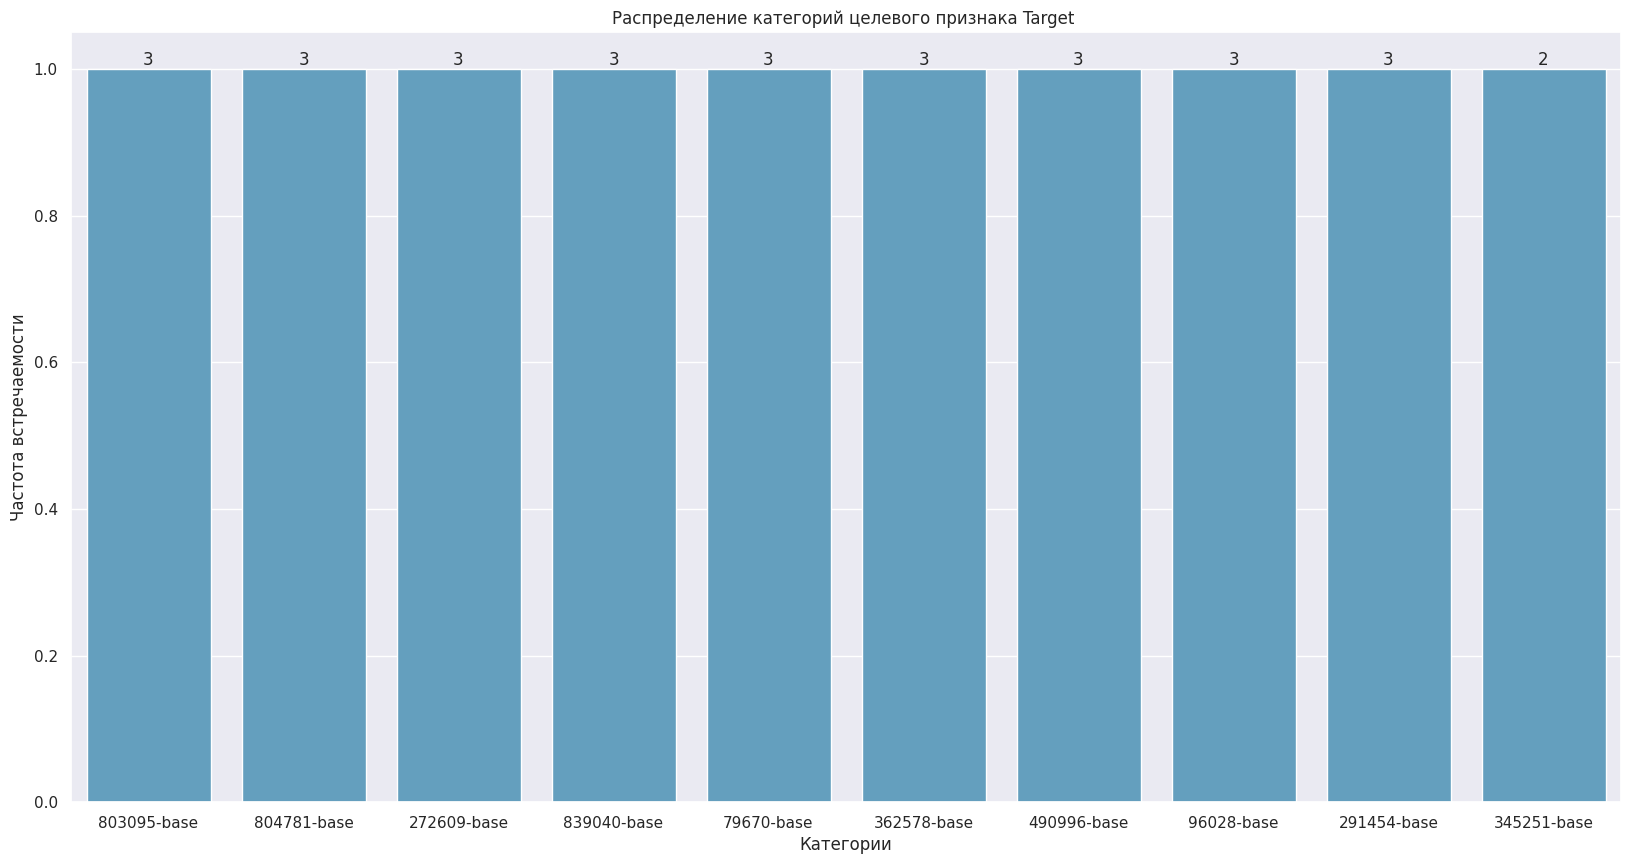

In [115]:
ax = sns.countplot(x=product_train['Target'].unique(),
                   order=product_train['Target'].value_counts(ascending=False).head(10).index);

abs_values = product_train['Target'].value_counts(ascending=False).head(10).values

ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Распределение категорий целевого признака Target ' )
ax.set(xlabel='Категории', ylabel='Частота встречаемости')
ax.figure.set_size_inches(20,10);

**Вывод:**

Визуализация показывает, что самый популярный товар в целевом признаке встречается всего лишь 3 раза.

Можно сделать вывод, что при поиске 5 похожих товаров на тренировочной выборке, максимально можно найти только 3 правильных ответа для одного запроса.

---
**Вывод раздела:**

В датафрейме `product_train` 71 количественный и 1 категориальный признак (целевой).
    
В выборке обнаружены признаки, имеющие не нормальное распределение, а также признаки с низким количеством уникальных значений - удалим данные признаки на этапе формирования выборок для модели.


Выбросы и аномалии в данных изучены.

---

## Корреляционный анализ

Проведём корреляционный анализ признаков датафрейма `product_train`.

Признак `Target` - целевой, изучим взаимосвязь входных признаков с целевым, а также проверим выборку на наличие мультиколлинеарности признакового описания.

Корреляцию признаков рассмотрим с помощью матрицы корреляций `phik_matrix()`.

In [116]:
# функция построения матрицы корреляций phik
def phik_matrix(df):
    # список интервальных признаков
    interval_cols = df.select_dtypes(include='number').columns.tolist()

    # вычисление коэффициентов корреляции phi для датафрейма
    phik_overview = df.phik_matrix(interval_cols=interval_cols)

    # визуализация тепловой карты коэффициентов корреляции
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        title=r"Матрица корреляции $\phi_K$",
        fontsize_factor=1.5,
        figsize=(100, 50)
    )

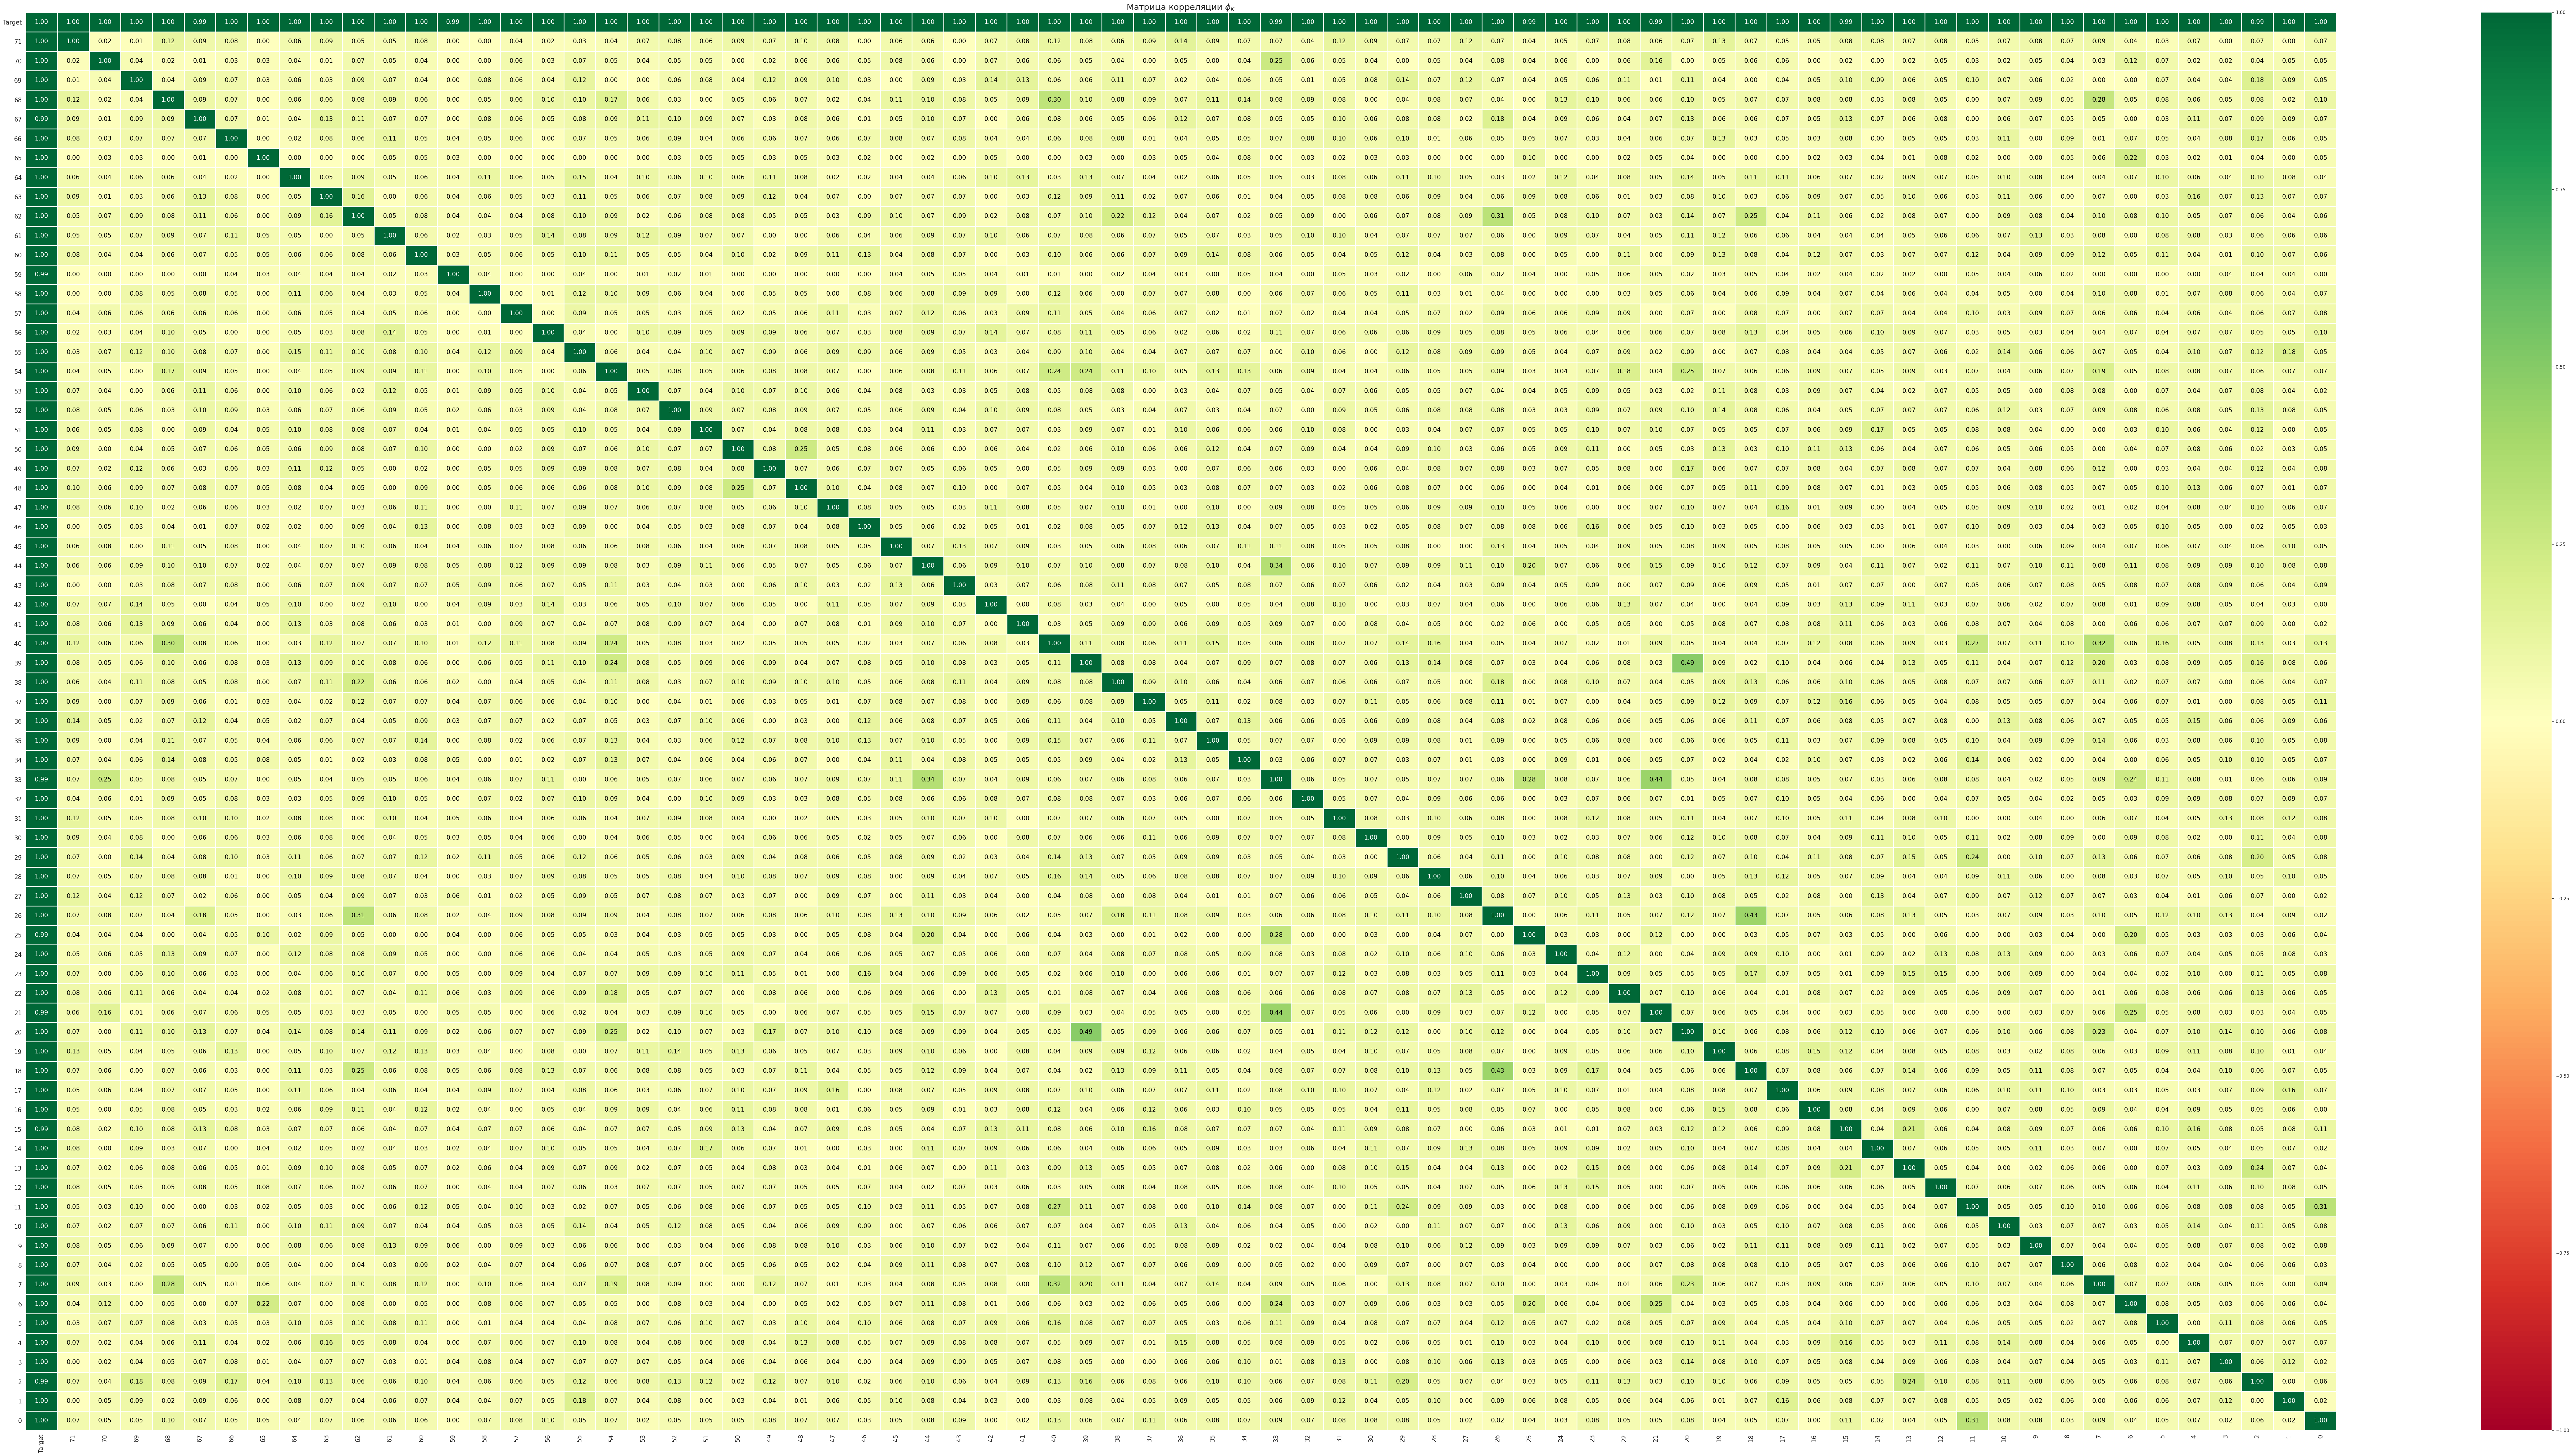

In [117]:
phik_matrix(product_train)

Мультиколлинеарность признакового описания отсутствует.

Все признаки имеют высокую корреляцию с целевым.

---

**Вывод раздела**

Зависимость с целевым признаком `Target` выявлена у всех признаков датафрейма.
    
Мультиколлинеарность признакового описания отсутствует.


## Отбор признаков

В ходе изучения признакового описания выявлены следующие особенности данных:

- признаки, имеющие не нормальное распределение: 65, 59.

- признаки, в которых одно значение втречается значительно чаще всех остальных: 70, 44, 21, 6.

- признаки, в которых уникальных значения составляют менее 20%: 25, 33

Удалим данные признаки из датафреймов:

In [22]:
print("До изменений:", product_train .shape)

# кол-во уникальных значений < 20%
del product_train['25']
del product_train['33']

# не нормальное распределение
del product_train['70']
del product_train['65']
del product_train['59']
del product_train['44']
del product_train['21']
del product_train['6']

#Проверим результат
print("После изменений:", product_train .shape)

До изменений: (9999, 73)
После изменений: (9999, 65)


In [23]:
print("До изменений:", product_base .shape)

# кол-во уникальных значений < 20%
del product_base['25']
del product_base['33']

# не нормальное распределение
del product_base['70']
del product_base['65']
del product_base['59']
del product_base['44']
del product_base['21']
del product_base['6']

#Проверим результат
print("После изменений:", product_base .shape)

До изменений: (291813, 72)
После изменений: (291813, 64)


In [24]:
print("До изменений:", product_valid .shape)

# кол-во уникальных значений < 20%
del product_valid['25']
del product_valid['33']

# не нормальное распределение
del product_valid['70']
del product_valid['65']
del product_valid['59']
del product_valid['44']
del product_valid['21']
del product_valid['6']

#Проверим результат
print("После изменений:", product_valid .shape)

До изменений: (10000, 72)
После изменений: (10000, 64)


Анализ данных завершён, посмотрим, как изменился тренировочный датафрейм после всех преобразований:

In [25]:
# считаем процент  уменьшения данных
row_decrease_percentage = ((len(product_train_unprocessed) - len(product_train)) / len(product_train_unprocessed)) * 100
column_decrease_percentage = ((len(product_train_unprocessed.columns) - len(product_train.columns)) / len(product_train_unprocessed.columns)) * 100

# удаляем копию датафрейма с исходными данными
del product_train_unprocessed

print(f"Процент удалённых строк: {row_decrease_percentage:.2f}%")
print(f"Процент удалённых столбцов: {column_decrease_percentage:.2f}%")

Процент удалённых строк: 0.00%
Процент удалённых столбцов: 10.96%


---

**Вывод раздела**

Произведён отбор признаков, сформированы выборки для модели.

В результате отбора исходный датафрейм уменьшился на 8 признаков (11% столбцов).

---

## FAISS

Целью исследования является поиск 5 похожих товаров по схожести признакового описания (Similarity Search).

Базовые модели для поиска ближайших соседей в больших наборах данных:
- FAISS;
- KNN;
- Annoy.

Для решения задачи выберем модель FAISS за её преимущества:
1. Эффективность в работе с большими объемами данных;
2. Поддержка GPU;
3. Масштабируемость и высокая производительность;
4. Поддержка различных типов поиска.

**План работы с FAISS**:
- выполним подготовку к использованию модели;
- отберём подходящие для исследования индексы FAISS;
- определим лучшие параметры выбранных индексов;
- определим лучший скейлер для масштабирования данных;
- выберем индекс с помощью метрики;
- получим прогноз на тестовой выборке `product_valid`.

### Основные параметры

Выполним подготовку к использованию модели:

- обозначим входные и целевой признаки;
- преобразуем данные в массив numpy;
-  зададим основные константные переменные.

In [26]:
# обозначим входные и целевой признаки
targets = product_train["Target"]
product_train.drop("Target", axis=1, inplace=True)

# преобразуем данные для оптимизации памяти и ускорения вычислений
product_base_vectors = np.ascontiguousarray(product_base.values).astype('float32')
query_vectors = np.ascontiguousarray(product_train.values).astype('float32')

k = 5 # поиск 5 ближайших соседей
dimension = product_base.shape[1] # размерность векторов

### Метрика

Качество модели оценим метрикой `Accuracy`, напишем функция для расчёта `Accuracy@5`.

In [27]:
# получим индексы всех товаров основной выборки
base_index = {k: v for k, v in enumerate(product_base.index.to_list())}

def accuracy_at_k(indices):
    acc = 0
    for target, el in zip(targets.values.tolist(), indices.tolist()):
        acc += int(target in [base_index[r] for r in el])

    accuracy = acc / len(indices) * 100
    return accuracy

### Масштабирование данных

В ходе изучения данных было выявлено, что исходные данные имеют различный масштаб, подготовим несколько скейлеров для масштабирования выборки:

In [28]:
# определим скейлер
standard = StandardScaler()

# масштабируем данные
product_base_vectors_standard = standard.fit_transform(product_base_vectors)
query_vectors_standard = standard.transform(query_vectors)

# проверим результат
print("Product_base shape до масштабирования:", product_base_vectors.shape)
print("Product_base:")
print(product_base_vectors[:2])

print("\nProduct_base shape после масштабирования:", product_base_vectors_standard.shape)
print("Product_base:")
print(product_base_vectors_standard[:2])

print("\nQuery_vectors shape до масштабирования:", query_vectors.shape)
print("Query_vectors:")
print(query_vectors_standard[:2])

print("\nQuery_vectors shape после масштабирования:", query_vectors_standard.shape)
print("Query_vectors:")
print(query_vectors_standard[:2])

Product_base shape до масштабирования: (291813, 64)
Product_base:
[[-4.39462433e+01  1.53643780e+01  1.75158539e+01 -1.32311462e+02
   1.57064423e+02 -4.06925201e+00 -5.75501404e+01  1.28398224e+02
   4.50909576e+01 -1.26843742e+02  4.49452209e+00 -9.98423080e+01
   4.49269028e+01  1.77521729e+02 -1.22917900e+01  3.84703598e+01
   1.05357651e+02 -1.42460236e+02 -8.01632614e+01 -1.10368935e+02
  -6.95946198e+01  6.63135376e+01  8.48738708e+01 -8.10387802e+01
   1.61629639e+01 -9.82448807e+01  1.59534058e+02  2.75549126e+01
  -2.09184280e+02  6.20597687e+01  1.14598328e+02  9.04698944e+01
  -2.02569141e+01 -1.64768005e+02 -1.33313873e+02 -4.12529602e+01
  -1.02511930e+01  8.28903770e+00 -1.31312714e+02  7.57044983e+01
   4.07710381e+01 -1.46096741e+02 -1.43407684e+02  4.98079872e+01
   6.34344788e+01 -3.02500801e+01  2.04702625e+01  7.80799103e+01
  -1.28915314e+02  9.23276825e+01  6.38855705e+01 -1.41174637e+02
   1.42902588e+02 -9.30685959e+01 -9.00186920e+01 -1.29015671e+02
  -7.19271

In [29]:
# определим скейлер
minmax = MinMaxScaler()

# масштабируем данные
product_base_vectors_minmax = minmax.fit_transform(product_base_vectors)
query_vectors_minmax = minmax.transform(query_vectors)

# проверим результат
print("Product_base shape до масштабирования:", product_base_vectors.shape)
print("Product_base:")
print(product_base_vectors[:2])

print("\nProduct_base shape после масштабирования:", product_base_vectors_minmax.shape)
print("Product_base:")
print(product_base_vectors_minmax[:2])

print("\nQuery_vectors shape до масштабирования:", query_vectors.shape)
print("Query_vectors:")
print(query_vectors_minmax[:2])

print("\nQuery_vectors shape после масштабирования:", query_vectors_minmax.shape)
print("Query_vectors:")
print(query_vectors_minmax[:2])

Product_base shape до масштабирования: (291813, 64)
Product_base:
[[-4.39462433e+01  1.53643780e+01  1.75158539e+01 -1.32311462e+02
   1.57064423e+02 -4.06925201e+00 -5.75501404e+01  1.28398224e+02
   4.50909576e+01 -1.26843742e+02  4.49452209e+00 -9.98423080e+01
   4.49269028e+01  1.77521729e+02 -1.22917900e+01  3.84703598e+01
   1.05357651e+02 -1.42460236e+02 -8.01632614e+01 -1.10368935e+02
  -6.95946198e+01  6.63135376e+01  8.48738708e+01 -8.10387802e+01
   1.61629639e+01 -9.82448807e+01  1.59534058e+02  2.75549126e+01
  -2.09184280e+02  6.20597687e+01  1.14598328e+02  9.04698944e+01
  -2.02569141e+01 -1.64768005e+02 -1.33313873e+02 -4.12529602e+01
  -1.02511930e+01  8.28903770e+00 -1.31312714e+02  7.57044983e+01
   4.07710381e+01 -1.46096741e+02 -1.43407684e+02  4.98079872e+01
   6.34344788e+01 -3.02500801e+01  2.04702625e+01  7.80799103e+01
  -1.28915314e+02  9.23276825e+01  6.38855705e+01 -1.41174637e+02
   1.42902588e+02 -9.30685959e+01 -9.00186920e+01 -1.29015671e+02
  -7.19271

In [30]:
# определим скейлер
robust = RobustScaler()

# масштабируем данные
product_base_vectors_robust = robust.fit_transform(product_base_vectors)
query_vectors_robust = robust.transform(query_vectors)

# проверим результат
print("Product_base shape до масштабирования:", product_base_vectors.shape)
print("Product_base:")
print(product_base_vectors[:2])

print("\nProduct_base shape после масштабирования:", product_base_vectors_robust.shape)
print("Product_base:")
print(product_base_vectors_minmax[:2])

print("\nQuery_vectors shape до масштабирования:", query_vectors.shape)
print("Query_vectors:")
print(query_vectors_robust[:2])

print("\nQuery_vectors shape после масштабирования:", query_vectors_robust.shape)
print("Query_vectors:")
print(query_vectors_robust[:2])

Product_base shape до масштабирования: (291813, 64)
Product_base:
[[-4.39462433e+01  1.53643780e+01  1.75158539e+01 -1.32311462e+02
   1.57064423e+02 -4.06925201e+00 -5.75501404e+01  1.28398224e+02
   4.50909576e+01 -1.26843742e+02  4.49452209e+00 -9.98423080e+01
   4.49269028e+01  1.77521729e+02 -1.22917900e+01  3.84703598e+01
   1.05357651e+02 -1.42460236e+02 -8.01632614e+01 -1.10368935e+02
  -6.95946198e+01  6.63135376e+01  8.48738708e+01 -8.10387802e+01
   1.61629639e+01 -9.82448807e+01  1.59534058e+02  2.75549126e+01
  -2.09184280e+02  6.20597687e+01  1.14598328e+02  9.04698944e+01
  -2.02569141e+01 -1.64768005e+02 -1.33313873e+02 -4.12529602e+01
  -1.02511930e+01  8.28903770e+00 -1.31312714e+02  7.57044983e+01
   4.07710381e+01 -1.46096741e+02 -1.43407684e+02  4.98079872e+01
   6.34344788e+01 -3.02500801e+01  2.04702625e+01  7.80799103e+01
  -1.28915314e+02  9.23276825e+01  6.38855705e+01 -1.41174637e+02
   1.42902588e+02 -9.30685959e+01 -9.00186920e+01 -1.29015671e+02
  -7.19271

**Вывод:**

Выполнена подготовка к использованию модели:

- заданы основные параметры;
- написана функция для расчёта метрики;
- данные масштабированы разными скейлерами.

### Выбор индексов

Перед выбором подходящего индекса рассмотрим особенности исходных данных и задачу исследования:

- **Размер**: датафрейм `product_base` среднего размера: содержит 291 813 товаров;
- **Размерность**: финальная выборка содержит 64 признака, что является низкой размерностью;
- **k**: цель задачи - поиск 5 похожих товаров;
- **Метрика расстояния**: используем Евклидово расстояние, так как данная метрика реализована в FAISS лучше всего.

Исходя из данных особенностей выберем следующие индексы:

- `IndexIVFFlat`: использует диаграмму Вороного для поиска, имеет оптимальный баланс скорости и точности на выборках среднего размера;

- `IndexHNSWFlat`: использует графовую структуру для организации данных и ускорения поиска ближайших соседей.

### Параметры индексов

Начнём работу с моделью с подбора оптимальных параметров выбранных индексов `IndexIVFFlat` и `IndexHNSWFlat`.

#### Inverted File Index

Для `IndexIVFFlat` подберём параметры `nlist` и `npobe`. В качестве квантизатора используем `IndexFlatL2`.

Подбор параметров осуществим на исходных данных без масштабирования, выбор скейлера осуществим на следующем шаге исследования.

In [32]:
nlist_values = [10, 20, 50, 100, 200]  # количество ячеек Вороного
nprobe_values = [1, 5, 10, 20] # сколько ячеек Вороного будет использовано для поиска соседей
best_params = None
best_score = 0

for nlist in nlist_values:
    for nprobe in nprobe_values:
        quantizer = faiss.IndexFlatL2(dimension) # определим квантизатор
        index_IVF = faiss.IndexIVFFlat(quantizer, dimension, nlist) # создадим индекс
        index_IVF.train(product_base_vectors)  # обучим индекс на наборе векторов
        index_IVF.add(product_base_vectors) # добавим векторы в индекс
        index_IVF.nprobe = nprobe
        distances, indices = index_IVF.search(query_vectors, k) # выполним поиск
        score = accuracy_at_k(indices) # рассчитаем метрику
        if score > best_score:
            best_score = score
            best_params = {"nlist": nlist, "nprobe": nprobe}

print(f"Лучшие параметры для IndexIVFFlat: {best_params}")
print(f"Лучшая метрика: {best_score}")

Лучшие параметры для IndexIVFFlat: {'nlist': 10, 'nprobe': 10}
Лучшая метрика: 76.95769576957696


**Вывод:**

Лучшие параметры модели:
- `nlist`: 10
- `nprobe`: 10

Используем данные параметры в дальнейшем исследовании.

#### IndexHNSWFlat

Для `IndexHNSWFlat` подберём параметры: `M`, `efConstruction` и `efSearch`.

Подбор параметров осуществим на исходных данных без масштабирования, выбор скейлера осуществим на следующем шаге исследования.

In [33]:
M_values = [32, 64] # количество рёбер, используемых для соединения каждой вставленной вершины в графе
Construction_values = [50, 150, 200] # сколько ближайших соседей учитывать при построении
Search_values = [10, 50, 150] # сколько ближайших соседей учитывать при поиске
best_params = None
best_score = 0

for M in M_values:
    for C in Construction_values:
        for S in Search_values:
            # создаём индекс
            index_HNSW = faiss.IndexHNSWFlat(dimension, M)
            index_HNSW.hnsw.efConstruction = C
            index_HNSW.hnsw.efSearch = S
            index_HNSW.add(product_base_vectors) # добавим векторы в индекс
            distances, indices = index_HNSW.search(query_vectors, k) # выполним поиск
            score = accuracy_at_k(indices) # рассчитаем метрику
            if score > best_score:
                best_score = score
                best_params = {"M": M, "efConstruction": C, "efSearch": S}

print(f"Лучшие параметры для IndexHNSWFlat: {best_params}")
print(f"Лучшая метрика: {best_score}")

Лучшие параметры для IndexHNSWFlat: {'M': 64, 'efConstruction': 50, 'efSearch': 150}
Лучшая метрика: 76.87768776877688


**Вывод:**

Лучшие параметры модели:
- `M`: 64
- `efConstruction`: 50
- `efSearch`: 150

Используем данные параметры в дальнейшем исследовании.

### Выбор скейлера

В данном шаге исследования выберем лучший скейлер для масштабирования данных.

Испытывать скейлеры будем на полученных лучших параметрах индексов.

#### Inverted File Index

In [71]:
nlist = 10
nprobe = 10

start_time = time.perf_counter()

quantizer = faiss.IndexFlatL2(dimension)
index_IVF_standard = faiss.IndexIVFFlat(quantizer, dimension, nlist)

index_IVF_standard.train(product_base_vectors_standard)
index_IVF_standard.add(product_base_vectors_standard)

index_IVF_standard.nprobe = nprobe
distances, indices = index_IVF_standard.search(query_vectors_standard, k)

time_IVF_standard = time.perf_counter() - start_time
acc_IVF_standard = accuracy_at_k(indices)

print(f"StandardScaler &  IndexIVFFlat accuracy: {acc_IVF_standard:.1f}, time: {time_IVF_standard:.2f}")

StandardScaler &  IndexIVFFlat accuracy: 78.8, time: 217.06


In [72]:
nlist = 10
nprobe = 10

start_time = time.perf_counter()

quantizer = faiss.IndexFlatL2(dimension)
index_IVF_minmax = faiss.IndexIVFFlat(quantizer, dimension, nlist)

index_IVF_minmax.train(product_base_vectors_minmax)
index_IVF_minmax.add(product_base_vectors_minmax)

index_IVF_minmax.nprobe = nprobe
distances, indices= index_IVF_minmax.search(query_vectors_minmax, k)

time_IVF_minmax = time.perf_counter() - start_time
acc_IVF_minmax = accuracy_at_k(indices)

print(f"Minmax Scaler &  IndexIVFFlat accuracy: {acc_IVF_minmax:.1f}, time: {time_IVF_minmax:.2f}")

Minmax Scaler &  IndexIVFFlat accuracy: 78.9, time: 212.54


In [73]:
nlist = 10
nprobe = 10

start_time = time.perf_counter()

quantizer = faiss.IndexFlatL2(dimension)
index_IVF_robust = faiss.IndexIVFFlat(quantizer, dimension, nlist)

index_IVF_robust.train(product_base_vectors_robust)
index_IVF_robust.add(product_base_vectors_robust)

index_IVF_robust.nprobe = nprobe
distances_r, indices_r = index_IVF_robust.search(query_vectors_robust, k)

time_IVF_robust = time.perf_counter() - start_time
acc_IVF_robust = accuracy_at_k(indices_r)

print(f"Robust Scaler &  IndexIVFFlat accuracy: {acc_IVF_robust:.1f}, time: {time_IVF_robust:.2f}")

Robust Scaler &  IndexIVFFlat accuracy: 78.8, time: 213.33


#### IndexHNSWFlat

In [74]:
M = 64
C = 50
S = 150

start_HNSW = time.perf_counter()

index_HNSW_standard = faiss.IndexHNSWFlat(dimension, M)
index_HNSW_standard.hnsw.efConstruction = C
index_HNSW_standard.hnsw.efSearch = S

index_HNSW_standard.add(product_base_vectors_standard)
distances, indices = index_HNSW_standard.search(query_vectors_standard, k)

time_HNSW_standard = time.perf_counter() - start_HNSW
acc_HNSW_standad = accuracy_at_k(indices)

print(f"Standard Scaler &  IndexHNSWFlat accuracy: {acc_HNSW_standad:.1f}, time: {time_HNSW_standard:.2f}")

Standard Scaler &  IndexHNSWFlat accuracy: 78.3, time: 674.52


In [75]:
M = 64
C = 50
S = 150

start_HNSW = time.perf_counter()

index_HNSW_minmax = faiss.IndexHNSWFlat(dimension, M)
index_HNSW_minmax.hnsw.efConstruction = C
index_HNSW_minmax.hnsw.efSearch = S

index_HNSW_minmax.add(product_base_vectors_minmax)
distances, indices = index_HNSW_minmax.search(query_vectors_minmax, k)

time_HNSW_minmax = time.perf_counter() - start_HNSW
acc_HNSW_minmax= accuracy_at_k(indices)

print(f"MinMax Scaler &  IndexHNSWFlat accuracy: {acc_HNSW_minmax:.1f}, time: {time_HNSW_minmax:.2f}")

MinMax Scaler &  IndexHNSWFlat accuracy: 78.3, time: 663.86


In [76]:
M = 64
C = 50
S = 150

start_HNSW = time.perf_counter()

index_HNSW_robust = faiss.IndexHNSWFlat(dimension, M)
index_HNSW_robust.hnsw.efConstruction = C
index_HNSW_robust.hnsw.efSearch = S

index_HNSW_robust.add(product_base_vectors_robust)

distances, indices = index_HNSW_robust.search(query_vectors_robust, k)
time_HNSW_robust = time.perf_counter() - start_HNSW
acc_HNSW_robust= accuracy_at_k(indices)

print(f"Robust Scaler &  IndexHNSWFlat accuracy: {acc_HNSW_robust:.1f}, time: {time_HNSW_robust:.2f}")

Robust Scaler &  IndexHNSWFlat accuracy: 78.3, time: 669.16


**Вывод:**

Получены метрики качества и время работы модели на каждом из скейлеров.

Используем данные показатели для выбора лучшего индекса.

### Выбор индекса

Для удобства запишем полученные метрики качества и скорости в сравнительную таблицу.

In [77]:
results = pd.DataFrame(
    {'scalers': ['Standard Scaler IVF',  'MinMax Scaler IVF', 'Robust Scaler IVF', 'Standard Scaler HNSW',  'MinMax Scaler HNSW', 'Robust Scaler HNSW'],
     'Accuracy @ 5': [acc_IVF_standard, acc_IVF_minmax, acc_IVF_robust, acc_HNSW_standad, acc_HNSW_minmax, acc_HNSW_robust],
     'Time': [time_IVF_standard, time_IVF_minmax, time_IVF_robust, time_HNSW_standard, time_HNSW_minmax, time_HNSW_robust]
    })

In [78]:
results

scalers  Accuracy @ 5    Time
0   Standard Scaler IVF        78.818 217.061
1     MinMax Scaler IVF        78.868 212.538
2     Robust Scaler IVF        78.828 213.333
3  Standard Scaler HNSW        78.278 674.524
4    MinMax Scaler HNSW        78.308 663.860
5    Robust Scaler HNSW        78.318 669.156

**Вывод:**

На основании полученных результатов для дальнейшего исследования и получения прогноза выберем индекс `IndexIVFFlat` и скейлер `Robust Scaler()`.

Данная комбинация показала оптимальное сочетание качества и скорости работы модели.

### Получение прогноза

Выполним подготовку данных к получению прогноза.

In [93]:
# преобразуем данные
query_vectors_valid = np.ascontiguousarray(product_valid.values).astype('float32')

# выполним масштабирование данных
query_vectors_valid_robust = robust.transform(query_vectors_valid)

# проверим результат
print("Query Data shape:", query_vectors_valid.shape)
print("Query Data (first row):")
print(query_vectors_valid[:1])

# Before searching
print("\nQuery Data scaled shape:", query_vectors_valid_robust.shape)
print("Query Data scaled (first row):")
print(query_vectors_valid_robust[:1])

Query Data shape: (10000, 64)
Query Data (first row):
[[ -59.38342      8.5634365  -28.203072  -134.22534     82.73661
  -150.57217     23.670555   125.66636    108.809586  -129.48387
  -178.98306   -109.600174    -8.7998085  172.95998    -20.794373
   -30.065893   -14.889741  -213.47429    -81.44286    -92.55872
    96.50842     87.97525     55.862797     1.6479721   16.160482
   -77.401474   166.08685     -7.0859447 -114.40581    116.56427
    40.185913    73.085365   -37.582203  -140.10822   -113.26041
   -64.86323    -16.001427     7.2237215   -5.791832   154.65631
    52.748238   -34.976818  -160.45952    -28.526081    11.436787
   107.38664     33.11757     56.67899    -43.842407    95.18327
    51.950043  -123.31064    -10.645209   -52.291348    53.718872
  -129.38846   -103.48163     79.56453   -120.31357     68.50073
    32.681908    84.19686    136.41296    -21.233612 ]]

Query Data scaled shape: (10000, 64)
Query Data scaled (first row):
[[ 0.7942467   0.0774596   0.3137007 

Напишем функцию для расчёта метрики `Accuracy@5`.

In [94]:
targets_valid = product_valid_answer['Expected']

def accuracy_at_k_valid(indices):
    acc = 0
    for target, el in zip(targets_valid.values.tolist(), indices.tolist()):
        acc += int(target in [base_index[r] for r in el])

    accuracy = acc / len(indices) * 100
    return accuracy

In [95]:
# выполним поиск с помощью обученного ранее индекса
distances, indices = index_IVF_robust.search(query_vectors_valid_robust, k)

In [96]:
# получим метрику на тестовой выборке
acc_valid = accuracy_at_k_valid(indices)
print(f"Accuracy at 5: {acc_valid:.2f}%")

Accuracy at 5: 78.15%


**Вывод:**

На тестовых данных получена метрика качества Accuracy at 5 равная 78.15%.

## Общий вывод

**Шаг 1. Знакомство с данными**

Перед проведением исследования данные были считаны:

- импортированы соответствующие библиотеки;
- загружен уменьшенный датасет;
- анонимизированный набор товаров считан и сохранён в переменную `product_base`;
- обучающий датасет считан и сохранён в переменную `product_train`;
- валидационные датасеты считаны и сохранены в переменные `product_valid` и `product_valid_answer`;
- изучена общая информация о полученных датафреймах;
- изучены имеющиеся пропуски в данных, тип данных, именование столбцов.

*Вывод:*

Для проведения исследования доступны следующие данные:

  * `product_base` — анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72. В выборке 291 813 объектов;

- `product_train` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов). В выборке 9 999 объектов;

- `product_valid` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из product_base. В выборке 10 000 объектов;

- `product_valid_answer`- правильные ответы к предыдущему файлу. В выборке 10 000 объектов

Предварительно можно утверждать, что данных достаточно для проведения исследования.
    
В датасетах отсутствуют пропущенные значения и имеется корректный тип данных.

---

**Шаг 2. Предобработка данных**

Проведена предобработка данных:
- изучены пропуски в датафреймах;
- проверены явные дубликаты в датафреймах.

*Вывод:*

Пропущенные значения отсутствуют во всех датафреймах.

Датафреймы содержат явные дубликаты - это может означать, что одному искомому товару в выборке соответствует несколько.

Дубликаты сохранены в выборках.

---

**Шаг 3. Исследовательский анализ данных**

Проведён исследовательский анализ всех признаков датафреймов.

*Вывод:*

В датафрейме `product_train` 71 количественный и 1 категориальный признак (целевой).
    
В выборке обнаружены признаки, имеющие не нормальное распределение, а также признаки с низким количеством уникальных значений - удалим данные признаки на этапе формирования выборок для модели.

Выбросы и аномалии в данных изучены.

---

**Шаг 4. Корреляционный анализ**

Проведён корреляционный анализ целевого и входных признаков датафрейма.

*Вывод:*

Зависимость с целевым признаком `Target` выявлена у всех признаков датафрейма.
    
Мультиколлинеарность признакового описания отсутствует.

---

**Шаг 5. Отбор признаков**

В ходе изучения признакового описания выявлены следующие особенности данных:

- признаки, имеющие не нормальное распределение: 65, 59.

- признаки, в которых одно значение втречается значительно чаще всех остальных: 70, 44, 21, 6.

- признаки, в которых уникальных значения составляют менее 20%: 25, 33

Данные признаки удалены из датафреймов.

*Вывод:*

Произведён отбор признаков, сформированы выборки для модели.

В результате отбора исходный датафрейм уменьшился на 8 признаков (11% столбцов).

---

**Шаг 6. FAISS**

Целью исследования является поиск 5 похожих товаров по схожести признакового описания (Similarity Search).

Базовые модели для поиска ближайших соседей в больших наборах данных:
- FAISS;
- KNN;
- Annoy.

Для решения задачи выберем модель FAISS за её преимущества:
1. Эффективность в работе с большими объемами данных;
2. Поддержка GPU;
3. Масштабируемость и высокая производительность;
4. Поддержка различных типов поиска.

**План работы с FAISS**:
- выполним подготовку к использованию модели;
- отберём подходящие для исследования индексы FAISS;
- определим лучшие параметры выбранных индексов;
- определим лучший скейлер для масштабирования данных;
- выберем индекс с помощью метрики;
- получим прогноз на тестовой (valid) выборке.



1. `Основные параметры`

Выполнена подготовка к использованию модели:

- обозначены входные и целевой признаки;
- данные преобразованы в массив numpy;
- заданы основные константные переменные.

2. `Метрика`

Качество модели оценивается метрикой Accuracy, написана функция для расчёта Accuracy@5.

3. `Масштабирование данных`

В ходе изучения данных выявлено, что исходные данные имеют различный масштаб, подготовлено несколько скейлеров для масштабирования выборки.

4. `Выбор индексов`

Перед выбором подходящего индекса рассмотрим особенности исходных данных и задачу исследования:

- **Размер**: датафрейм с товарами содержит 291 813 объекта и имеет средний размер;
- **Размерность**: финальная выборка содержит 64 признака, что является низкой размерностью;
- **k**: цель задачи - поиск 5 похожих товаров;
- **Метрика расстояния**: используем Евклидово расстояние, так как данная метрика реализована в FAISS лучше всего.

Исходя из данных особенностей выбраны следующие индексы:

- **IndexIVFFlat**: использует диаграмму Вороного для поиска, имеет оптимальный баланс скорости и точности на выборках среднего размера;

- **IndexHNSWFlat**: использует графовую структуру для организации данных и ускорения поиска ближайших соседей.

5. `Параметры  индексов`

Для IndexIVFFlat подберём параметры nlist и npobe. В качестве квантизатора используем IndexFlatL2.

Подбор параметров осуществим на исходных данных без масштабирования, выбор скейлера осуществим на следующем шаге исследования.

*Вывод*:

Лучшие параметры модели:

- nlist: 10
- nprobe: 10

Используем данные параметры в дальнейшем исследовании.

Для IndexHNSWFlat подберём параметры: M, efConstruction и efSearch.

Подбор параметров осуществим на исходных данных без масштабирования, выбор скейлера осуществим на следующем шаге исследования.

*Вывод*:

Лучшие параметры модели:

- M: 64
- efConstruction: 50
- efSearch: 150

Используем данные параметры в дальнейшем исследовании.

6. `Выбор  скейлера`

В данном шаге исследования выберем лучший скейлер для масштабирования данных.

Испытывать скейлеры будем на полученных лучших параметрах индексов.

*Вывод*:

Получены метрики качества и время работы модели на каждом из скейлеров.

Используем данные показатели для выбора лучшего индекса.

7. `Выбор  скейлера`

Полученные метрики качества и скорости записаны в сравнительную таблицу.

*Вывод*:

На основании полученных результатов для дальнейшего исследования и получения прогноза выберем индекс IndexIVFFlat и скейлер Robust Scaler().

Данная комбинация показала оптимальное сочетание качества и скорости работы модели.

8. `Получение  прогноза`

Данные подготовлены к получению прогноза. Для получения метрики Accuracy@5 написана функция.

*Вывод*:

На тестовых данных получена метрика качества Accuracy at 5 равная 78.15%.

---

**Заключение:**

Данное исследование проводилось с целью поиска 5 похожих товаров по схожести признакового описания.

В ходе исследования удалось написать и оптимизировать модель FAISS, в результате чего на тестовых данных получена удовлетворительная метрика Accuracy@5 = 78.15%.

Для повышения качества работы модели стоит расширить исследование в следующих направлениях:
- использовать полный датасет с данными о товарах;
- использовать больше индексов для поиска ближайших соседей, в том числе и комбинации индексов;
- использовать различные метрики расстояния (косинусное, Канберры, Махаланобиса);
- использовать последовательный поиск: найти 20 ближайших соседей, из которых в дальнейшем отобрать 5 похожих товаров.

Данные улучшения и доработки помогут повысить качество модели и улучшить полученную метрику.